# Normal DCGAN

In [23]:
import os
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch

from torchvision.utils import save_image
from torchvision import datasets
from torch.utils.data import DataLoader

In [34]:
%matplotlib inline
os.makedirs('images', exist_ok=True)
os.makedirs('data', exist_ok=True)
os.makedirs('saved_models', exist_ok=True)

# Enable GPU
cuda = True if torch.cuda.is_available() else False

Parameters

In [40]:
# General

epochs = 50
batch_size = 64
n_cpu = 1
samples = 500
seed = 1
sample_interval = 5000
checkpoint_interval = 10

# Hyperparameters: Adam optimizer parameters (learning rate and momentum decay)

lr = 0.0002
b1 = 0.5
b2 = 0.999

# Dimensions of latent space

latent_dim = 100

Configuring dataset and checking images

In [26]:
# Configure data loader and image parameters

img_dim = 32
img_channels = 3

os.makedirs('./data/cifar10', exist_ok=True)

transform=transforms.Compose([
    transforms.Resize(img_dim),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True,
                       transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


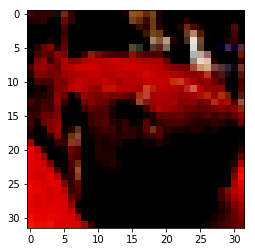

In [27]:
i, _ = dataset[5]
show(i)

Setting seed

In [28]:
# CPU
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# GPU
if torch.cuda.is_available():
        print("Using cuda.")
        torch.cuda.manual_seed_all(seed)

Using cuda.


Generator

In [29]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_dim // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128*self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

Discriminator

In [30]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [   nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_dim // 2**4
        self.adv_layer = nn.Sequential( nn.Linear(128*ds_size**2, 1),
                                        nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

Function to initialise weights

In [31]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

Initialising and configuring metrics

In [32]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

print(generator)
print(discriminator)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Upsample(scale_factor=2, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2

Training

In [44]:
gen_loss = []
disc_loss = []

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Tensor(imgs.shape[0], 1).fill_(1.0)
        fake = Tensor(imgs.shape[0], 1).fill_(0.0)

        # Configure input
        real_imgs = imgs.type(Tensor)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        
        gen_loss.append(g_loss)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        disc_loss.append(d_loss)

        d_loss.backward()
        optimizer_D.step()

        print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, epochs, i, len(dataloader),
                                                            d_loss.item(), g_loss.item()))

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], 'images/%d.png' % batches_done, nrow=5, normalize=True)
            
    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), 'saved_models/generator_%d.pth' % epoch)
        torch.save(discriminator.state_dict(), 'saved_models/discriminator_%d.pth' % epoch)


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


[Epoch 0/50] [Batch 0/782] [D loss: 0.691972] [G loss: 0.699853]
[Epoch 0/50] [Batch 1/782] [D loss: 0.670377] [G loss: 0.701314]
[Epoch 0/50] [Batch 2/782] [D loss: 0.730370] [G loss: 0.700695]
[Epoch 0/50] [Batch 3/782] [D loss: 0.689253] [G loss: 0.669729]
[Epoch 0/50] [Batch 4/782] [D loss: 0.698361] [G loss: 0.721205]
[Epoch 0/50] [Batch 5/782] [D loss: 0.702641] [G loss: 0.724985]
[Epoch 0/50] [Batch 6/782] [D loss: 0.685831] [G loss: 0.724777]
[Epoch 0/50] [Batch 7/782] [D loss: 0.672131] [G loss: 0.731447]
[Epoch 0/50] [Batch 8/782] [D loss: 0.700935] [G loss: 0.688304]
[Epoch 0/50] [Batch 9/782] [D loss: 0.697249] [G loss: 0.705061]
[Epoch 0/50] [Batch 10/782] [D loss: 0.676201] [G loss: 0.693507]
[Epoch 0/50] [Batch 11/782] [D loss: 0.684600] [G loss: 0.686336]
[Epoch 0/50] [Batch 12/782] [D loss: 0.696045] [G loss: 0.690587]
[Epoch 0/50] [Batch 13/782] [D loss: 0.690476] [G loss: 0.681210]
[Epoch 0/50] [Batch 14/782] [D loss: 0.680075] [G loss: 0.680895]
[Epoch 0/50] [Batch 

[Epoch 0/50] [Batch 125/782] [D loss: 0.681876] [G loss: 0.694780]
[Epoch 0/50] [Batch 126/782] [D loss: 0.681884] [G loss: 0.706914]
[Epoch 0/50] [Batch 127/782] [D loss: 0.696497] [G loss: 0.681622]
[Epoch 0/50] [Batch 128/782] [D loss: 0.711930] [G loss: 0.688922]
[Epoch 0/50] [Batch 129/782] [D loss: 0.686026] [G loss: 0.690436]
[Epoch 0/50] [Batch 130/782] [D loss: 0.685813] [G loss: 0.683880]
[Epoch 0/50] [Batch 131/782] [D loss: 0.691667] [G loss: 0.731292]
[Epoch 0/50] [Batch 132/782] [D loss: 0.670341] [G loss: 0.711435]
[Epoch 0/50] [Batch 133/782] [D loss: 0.698966] [G loss: 0.694148]
[Epoch 0/50] [Batch 134/782] [D loss: 0.700100] [G loss: 0.729441]
[Epoch 0/50] [Batch 135/782] [D loss: 0.684531] [G loss: 0.758953]
[Epoch 0/50] [Batch 136/782] [D loss: 0.697784] [G loss: 0.716392]
[Epoch 0/50] [Batch 137/782] [D loss: 0.695865] [G loss: 0.740708]
[Epoch 0/50] [Batch 138/782] [D loss: 0.691753] [G loss: 0.734898]
[Epoch 0/50] [Batch 139/782] [D loss: 0.699295] [G loss: 0.720

[Epoch 0/50] [Batch 251/782] [D loss: 0.711594] [G loss: 0.686148]
[Epoch 0/50] [Batch 252/782] [D loss: 0.677397] [G loss: 0.711010]
[Epoch 0/50] [Batch 253/782] [D loss: 0.697255] [G loss: 0.696768]
[Epoch 0/50] [Batch 254/782] [D loss: 0.712031] [G loss: 0.677806]
[Epoch 0/50] [Batch 255/782] [D loss: 0.691287] [G loss: 0.713560]
[Epoch 0/50] [Batch 256/782] [D loss: 0.689689] [G loss: 0.713046]
[Epoch 0/50] [Batch 257/782] [D loss: 0.679691] [G loss: 0.693871]
[Epoch 0/50] [Batch 258/782] [D loss: 0.707349] [G loss: 0.720366]
[Epoch 0/50] [Batch 259/782] [D loss: 0.689266] [G loss: 0.716254]
[Epoch 0/50] [Batch 260/782] [D loss: 0.708997] [G loss: 0.688267]
[Epoch 0/50] [Batch 261/782] [D loss: 0.688038] [G loss: 0.689345]
[Epoch 0/50] [Batch 262/782] [D loss: 0.697375] [G loss: 0.708190]
[Epoch 0/50] [Batch 263/782] [D loss: 0.671519] [G loss: 0.694263]
[Epoch 0/50] [Batch 264/782] [D loss: 0.689017] [G loss: 0.661302]
[Epoch 0/50] [Batch 265/782] [D loss: 0.698928] [G loss: 0.671

[Epoch 0/50] [Batch 377/782] [D loss: 0.688220] [G loss: 0.693230]
[Epoch 0/50] [Batch 378/782] [D loss: 0.712195] [G loss: 0.696901]
[Epoch 0/50] [Batch 379/782] [D loss: 0.698088] [G loss: 0.740047]
[Epoch 0/50] [Batch 380/782] [D loss: 0.690962] [G loss: 0.688277]
[Epoch 0/50] [Batch 381/782] [D loss: 0.725084] [G loss: 0.691599]
[Epoch 0/50] [Batch 382/782] [D loss: 0.688892] [G loss: 0.689828]
[Epoch 0/50] [Batch 383/782] [D loss: 0.699931] [G loss: 0.698720]
[Epoch 0/50] [Batch 384/782] [D loss: 0.688487] [G loss: 0.677539]
[Epoch 0/50] [Batch 385/782] [D loss: 0.692760] [G loss: 0.692197]
[Epoch 0/50] [Batch 386/782] [D loss: 0.704946] [G loss: 0.679690]
[Epoch 0/50] [Batch 387/782] [D loss: 0.681790] [G loss: 0.679441]
[Epoch 0/50] [Batch 388/782] [D loss: 0.705257] [G loss: 0.724416]
[Epoch 0/50] [Batch 389/782] [D loss: 0.693887] [G loss: 0.673542]
[Epoch 0/50] [Batch 390/782] [D loss: 0.663509] [G loss: 0.706378]
[Epoch 0/50] [Batch 391/782] [D loss: 0.684609] [G loss: 0.707

[Epoch 0/50] [Batch 503/782] [D loss: 0.680985] [G loss: 0.716963]
[Epoch 0/50] [Batch 504/782] [D loss: 0.675981] [G loss: 0.731689]
[Epoch 0/50] [Batch 505/782] [D loss: 0.705349] [G loss: 0.713206]
[Epoch 0/50] [Batch 506/782] [D loss: 0.694565] [G loss: 0.724851]
[Epoch 0/50] [Batch 507/782] [D loss: 0.694707] [G loss: 0.693789]
[Epoch 0/50] [Batch 508/782] [D loss: 0.671376] [G loss: 0.706951]
[Epoch 0/50] [Batch 509/782] [D loss: 0.683738] [G loss: 0.699321]
[Epoch 0/50] [Batch 510/782] [D loss: 0.687772] [G loss: 0.691096]
[Epoch 0/50] [Batch 511/782] [D loss: 0.694367] [G loss: 0.668444]
[Epoch 0/50] [Batch 512/782] [D loss: 0.684487] [G loss: 0.711074]
[Epoch 0/50] [Batch 513/782] [D loss: 0.658297] [G loss: 0.679740]
[Epoch 0/50] [Batch 514/782] [D loss: 0.675336] [G loss: 0.687099]
[Epoch 0/50] [Batch 515/782] [D loss: 0.693054] [G loss: 0.682370]
[Epoch 0/50] [Batch 516/782] [D loss: 0.670247] [G loss: 0.647675]
[Epoch 0/50] [Batch 517/782] [D loss: 0.670570] [G loss: 0.689

[Epoch 0/50] [Batch 629/782] [D loss: 0.701371] [G loss: 0.710512]
[Epoch 0/50] [Batch 630/782] [D loss: 0.659243] [G loss: 0.711227]
[Epoch 0/50] [Batch 631/782] [D loss: 0.660706] [G loss: 0.723544]
[Epoch 0/50] [Batch 632/782] [D loss: 0.692350] [G loss: 0.714638]
[Epoch 0/50] [Batch 633/782] [D loss: 0.683282] [G loss: 0.684981]
[Epoch 0/50] [Batch 634/782] [D loss: 0.703784] [G loss: 0.698756]
[Epoch 0/50] [Batch 635/782] [D loss: 0.689752] [G loss: 0.664241]
[Epoch 0/50] [Batch 636/782] [D loss: 0.685090] [G loss: 0.667103]
[Epoch 0/50] [Batch 637/782] [D loss: 0.698624] [G loss: 0.702750]
[Epoch 0/50] [Batch 638/782] [D loss: 0.685086] [G loss: 0.687019]
[Epoch 0/50] [Batch 639/782] [D loss: 0.694961] [G loss: 0.664501]
[Epoch 0/50] [Batch 640/782] [D loss: 0.694121] [G loss: 0.652278]
[Epoch 0/50] [Batch 641/782] [D loss: 0.729488] [G loss: 0.685772]
[Epoch 0/50] [Batch 642/782] [D loss: 0.701740] [G loss: 0.690082]
[Epoch 0/50] [Batch 643/782] [D loss: 0.706945] [G loss: 0.722

[Epoch 0/50] [Batch 755/782] [D loss: 0.685093] [G loss: 0.707256]
[Epoch 0/50] [Batch 756/782] [D loss: 0.683727] [G loss: 0.730798]
[Epoch 0/50] [Batch 757/782] [D loss: 0.688521] [G loss: 0.713016]
[Epoch 0/50] [Batch 758/782] [D loss: 0.676365] [G loss: 0.724052]
[Epoch 0/50] [Batch 759/782] [D loss: 0.682669] [G loss: 0.695557]
[Epoch 0/50] [Batch 760/782] [D loss: 0.658323] [G loss: 0.681418]
[Epoch 0/50] [Batch 761/782] [D loss: 0.681446] [G loss: 0.679958]
[Epoch 0/50] [Batch 762/782] [D loss: 0.682077] [G loss: 0.714777]
[Epoch 0/50] [Batch 763/782] [D loss: 0.670602] [G loss: 0.714425]
[Epoch 0/50] [Batch 764/782] [D loss: 0.706799] [G loss: 0.687947]
[Epoch 0/50] [Batch 765/782] [D loss: 0.694070] [G loss: 0.703054]
[Epoch 0/50] [Batch 766/782] [D loss: 0.690271] [G loss: 0.719556]
[Epoch 0/50] [Batch 767/782] [D loss: 0.700063] [G loss: 0.724657]
[Epoch 0/50] [Batch 768/782] [D loss: 0.701732] [G loss: 0.693985]
[Epoch 0/50] [Batch 769/782] [D loss: 0.700479] [G loss: 0.696

[Epoch 1/50] [Batch 102/782] [D loss: 0.690695] [G loss: 0.712305]
[Epoch 1/50] [Batch 103/782] [D loss: 0.709032] [G loss: 0.722751]
[Epoch 1/50] [Batch 104/782] [D loss: 0.689453] [G loss: 0.698516]
[Epoch 1/50] [Batch 105/782] [D loss: 0.682692] [G loss: 0.701376]
[Epoch 1/50] [Batch 106/782] [D loss: 0.698197] [G loss: 0.734954]
[Epoch 1/50] [Batch 107/782] [D loss: 0.683117] [G loss: 0.695539]
[Epoch 1/50] [Batch 108/782] [D loss: 0.692053] [G loss: 0.705495]
[Epoch 1/50] [Batch 109/782] [D loss: 0.712121] [G loss: 0.682235]
[Epoch 1/50] [Batch 110/782] [D loss: 0.691143] [G loss: 0.719202]
[Epoch 1/50] [Batch 111/782] [D loss: 0.697808] [G loss: 0.681141]
[Epoch 1/50] [Batch 112/782] [D loss: 0.695111] [G loss: 0.718202]
[Epoch 1/50] [Batch 113/782] [D loss: 0.697153] [G loss: 0.684414]
[Epoch 1/50] [Batch 114/782] [D loss: 0.700762] [G loss: 0.692056]
[Epoch 1/50] [Batch 115/782] [D loss: 0.693686] [G loss: 0.703980]
[Epoch 1/50] [Batch 116/782] [D loss: 0.697593] [G loss: 0.693

[Epoch 1/50] [Batch 228/782] [D loss: 0.710167] [G loss: 0.701283]
[Epoch 1/50] [Batch 229/782] [D loss: 0.717668] [G loss: 0.713754]
[Epoch 1/50] [Batch 230/782] [D loss: 0.694685] [G loss: 0.726617]
[Epoch 1/50] [Batch 231/782] [D loss: 0.664801] [G loss: 0.719673]
[Epoch 1/50] [Batch 232/782] [D loss: 0.705218] [G loss: 0.721223]
[Epoch 1/50] [Batch 233/782] [D loss: 0.691279] [G loss: 0.694130]
[Epoch 1/50] [Batch 234/782] [D loss: 0.686265] [G loss: 0.713510]
[Epoch 1/50] [Batch 235/782] [D loss: 0.715048] [G loss: 0.689846]
[Epoch 1/50] [Batch 236/782] [D loss: 0.689884] [G loss: 0.679574]
[Epoch 1/50] [Batch 237/782] [D loss: 0.718167] [G loss: 0.664752]
[Epoch 1/50] [Batch 238/782] [D loss: 0.691550] [G loss: 0.698479]
[Epoch 1/50] [Batch 239/782] [D loss: 0.722970] [G loss: 0.699682]
[Epoch 1/50] [Batch 240/782] [D loss: 0.694233] [G loss: 0.722675]
[Epoch 1/50] [Batch 241/782] [D loss: 0.702698] [G loss: 0.706589]
[Epoch 1/50] [Batch 242/782] [D loss: 0.688941] [G loss: 0.699

[Epoch 1/50] [Batch 354/782] [D loss: 0.665994] [G loss: 0.720716]
[Epoch 1/50] [Batch 355/782] [D loss: 0.696227] [G loss: 0.719257]
[Epoch 1/50] [Batch 356/782] [D loss: 0.660399] [G loss: 0.702900]
[Epoch 1/50] [Batch 357/782] [D loss: 0.683544] [G loss: 0.682762]
[Epoch 1/50] [Batch 358/782] [D loss: 0.697503] [G loss: 0.720294]
[Epoch 1/50] [Batch 359/782] [D loss: 0.709300] [G loss: 0.720924]
[Epoch 1/50] [Batch 360/782] [D loss: 0.687572] [G loss: 0.733128]
[Epoch 1/50] [Batch 361/782] [D loss: 0.695069] [G loss: 0.725883]
[Epoch 1/50] [Batch 362/782] [D loss: 0.683387] [G loss: 0.700022]
[Epoch 1/50] [Batch 363/782] [D loss: 0.707562] [G loss: 0.707589]
[Epoch 1/50] [Batch 364/782] [D loss: 0.687732] [G loss: 0.675655]
[Epoch 1/50] [Batch 365/782] [D loss: 0.682543] [G loss: 0.709136]
[Epoch 1/50] [Batch 366/782] [D loss: 0.685613] [G loss: 0.701717]
[Epoch 1/50] [Batch 367/782] [D loss: 0.692209] [G loss: 0.694612]
[Epoch 1/50] [Batch 368/782] [D loss: 0.695069] [G loss: 0.717

[Epoch 1/50] [Batch 480/782] [D loss: 0.709459] [G loss: 0.717015]
[Epoch 1/50] [Batch 481/782] [D loss: 0.680607] [G loss: 0.703359]
[Epoch 1/50] [Batch 482/782] [D loss: 0.695572] [G loss: 0.676753]
[Epoch 1/50] [Batch 483/782] [D loss: 0.667372] [G loss: 0.706004]
[Epoch 1/50] [Batch 484/782] [D loss: 0.683038] [G loss: 0.695975]
[Epoch 1/50] [Batch 485/782] [D loss: 0.705361] [G loss: 0.691903]
[Epoch 1/50] [Batch 486/782] [D loss: 0.695158] [G loss: 0.707590]
[Epoch 1/50] [Batch 487/782] [D loss: 0.676870] [G loss: 0.692402]
[Epoch 1/50] [Batch 488/782] [D loss: 0.693777] [G loss: 0.698115]
[Epoch 1/50] [Batch 489/782] [D loss: 0.681426] [G loss: 0.697742]
[Epoch 1/50] [Batch 490/782] [D loss: 0.679788] [G loss: 0.707079]
[Epoch 1/50] [Batch 491/782] [D loss: 0.687036] [G loss: 0.685841]
[Epoch 1/50] [Batch 492/782] [D loss: 0.674596] [G loss: 0.690618]
[Epoch 1/50] [Batch 493/782] [D loss: 0.677748] [G loss: 0.679836]
[Epoch 1/50] [Batch 494/782] [D loss: 0.704065] [G loss: 0.684

[Epoch 1/50] [Batch 606/782] [D loss: 0.687914] [G loss: 0.707681]
[Epoch 1/50] [Batch 607/782] [D loss: 0.699849] [G loss: 0.664276]
[Epoch 1/50] [Batch 608/782] [D loss: 0.691945] [G loss: 0.718626]
[Epoch 1/50] [Batch 609/782] [D loss: 0.662326] [G loss: 0.715149]
[Epoch 1/50] [Batch 610/782] [D loss: 0.694679] [G loss: 0.708270]
[Epoch 1/50] [Batch 611/782] [D loss: 0.690367] [G loss: 0.714535]
[Epoch 1/50] [Batch 612/782] [D loss: 0.684517] [G loss: 0.711851]
[Epoch 1/50] [Batch 613/782] [D loss: 0.692756] [G loss: 0.719133]
[Epoch 1/50] [Batch 614/782] [D loss: 0.700577] [G loss: 0.682722]
[Epoch 1/50] [Batch 615/782] [D loss: 0.679992] [G loss: 0.691757]
[Epoch 1/50] [Batch 616/782] [D loss: 0.686455] [G loss: 0.680806]
[Epoch 1/50] [Batch 617/782] [D loss: 0.673299] [G loss: 0.705124]
[Epoch 1/50] [Batch 618/782] [D loss: 0.700592] [G loss: 0.681361]
[Epoch 1/50] [Batch 619/782] [D loss: 0.717361] [G loss: 0.693702]
[Epoch 1/50] [Batch 620/782] [D loss: 0.685744] [G loss: 0.694

[Epoch 1/50] [Batch 732/782] [D loss: 0.708312] [G loss: 0.653689]
[Epoch 1/50] [Batch 733/782] [D loss: 0.681840] [G loss: 0.728562]
[Epoch 1/50] [Batch 734/782] [D loss: 0.705987] [G loss: 0.689191]
[Epoch 1/50] [Batch 735/782] [D loss: 0.710406] [G loss: 0.707305]
[Epoch 1/50] [Batch 736/782] [D loss: 0.686379] [G loss: 0.666152]
[Epoch 1/50] [Batch 737/782] [D loss: 0.697862] [G loss: 0.667629]
[Epoch 1/50] [Batch 738/782] [D loss: 0.693754] [G loss: 0.688513]
[Epoch 1/50] [Batch 739/782] [D loss: 0.703212] [G loss: 0.701016]
[Epoch 1/50] [Batch 740/782] [D loss: 0.692322] [G loss: 0.702257]
[Epoch 1/50] [Batch 741/782] [D loss: 0.686369] [G loss: 0.692422]
[Epoch 1/50] [Batch 742/782] [D loss: 0.686949] [G loss: 0.689986]
[Epoch 1/50] [Batch 743/782] [D loss: 0.693171] [G loss: 0.708217]
[Epoch 1/50] [Batch 744/782] [D loss: 0.696562] [G loss: 0.706767]
[Epoch 1/50] [Batch 745/782] [D loss: 0.703514] [G loss: 0.689446]
[Epoch 1/50] [Batch 746/782] [D loss: 0.691633] [G loss: 0.683

[Epoch 2/50] [Batch 78/782] [D loss: 0.699131] [G loss: 0.689968]
[Epoch 2/50] [Batch 79/782] [D loss: 0.687026] [G loss: 0.687432]
[Epoch 2/50] [Batch 80/782] [D loss: 0.696384] [G loss: 0.686176]
[Epoch 2/50] [Batch 81/782] [D loss: 0.687585] [G loss: 0.672436]
[Epoch 2/50] [Batch 82/782] [D loss: 0.696677] [G loss: 0.693459]
[Epoch 2/50] [Batch 83/782] [D loss: 0.687050] [G loss: 0.679909]
[Epoch 2/50] [Batch 84/782] [D loss: 0.709255] [G loss: 0.716286]
[Epoch 2/50] [Batch 85/782] [D loss: 0.718986] [G loss: 0.674118]
[Epoch 2/50] [Batch 86/782] [D loss: 0.697320] [G loss: 0.693811]
[Epoch 2/50] [Batch 87/782] [D loss: 0.686393] [G loss: 0.702437]
[Epoch 2/50] [Batch 88/782] [D loss: 0.682887] [G loss: 0.659197]
[Epoch 2/50] [Batch 89/782] [D loss: 0.690740] [G loss: 0.684586]
[Epoch 2/50] [Batch 90/782] [D loss: 0.683300] [G loss: 0.679430]
[Epoch 2/50] [Batch 91/782] [D loss: 0.685818] [G loss: 0.715048]
[Epoch 2/50] [Batch 92/782] [D loss: 0.706981] [G loss: 0.750016]
[Epoch 2/5

[Epoch 2/50] [Batch 204/782] [D loss: 0.687968] [G loss: 0.691172]
[Epoch 2/50] [Batch 205/782] [D loss: 0.689304] [G loss: 0.724327]
[Epoch 2/50] [Batch 206/782] [D loss: 0.697084] [G loss: 0.671237]
[Epoch 2/50] [Batch 207/782] [D loss: 0.682080] [G loss: 0.701958]
[Epoch 2/50] [Batch 208/782] [D loss: 0.702036] [G loss: 0.677414]
[Epoch 2/50] [Batch 209/782] [D loss: 0.698003] [G loss: 0.707134]
[Epoch 2/50] [Batch 210/782] [D loss: 0.665677] [G loss: 0.700558]
[Epoch 2/50] [Batch 211/782] [D loss: 0.694778] [G loss: 0.689281]
[Epoch 2/50] [Batch 212/782] [D loss: 0.702417] [G loss: 0.683117]
[Epoch 2/50] [Batch 213/782] [D loss: 0.683832] [G loss: 0.693185]
[Epoch 2/50] [Batch 214/782] [D loss: 0.700536] [G loss: 0.696873]
[Epoch 2/50] [Batch 215/782] [D loss: 0.705531] [G loss: 0.706461]
[Epoch 2/50] [Batch 216/782] [D loss: 0.712053] [G loss: 0.687992]
[Epoch 2/50] [Batch 217/782] [D loss: 0.692877] [G loss: 0.692426]
[Epoch 2/50] [Batch 218/782] [D loss: 0.686804] [G loss: 0.685

[Epoch 2/50] [Batch 330/782] [D loss: 0.697867] [G loss: 0.701962]
[Epoch 2/50] [Batch 331/782] [D loss: 0.705302] [G loss: 0.721036]
[Epoch 2/50] [Batch 332/782] [D loss: 0.698715] [G loss: 0.673549]
[Epoch 2/50] [Batch 333/782] [D loss: 0.711139] [G loss: 0.665917]
[Epoch 2/50] [Batch 334/782] [D loss: 0.697000] [G loss: 0.707859]
[Epoch 2/50] [Batch 335/782] [D loss: 0.685871] [G loss: 0.699446]
[Epoch 2/50] [Batch 336/782] [D loss: 0.706149] [G loss: 0.689129]
[Epoch 2/50] [Batch 337/782] [D loss: 0.702614] [G loss: 0.695076]
[Epoch 2/50] [Batch 338/782] [D loss: 0.689635] [G loss: 0.717769]
[Epoch 2/50] [Batch 339/782] [D loss: 0.678962] [G loss: 0.698787]
[Epoch 2/50] [Batch 340/782] [D loss: 0.697326] [G loss: 0.690354]
[Epoch 2/50] [Batch 341/782] [D loss: 0.696713] [G loss: 0.679200]
[Epoch 2/50] [Batch 342/782] [D loss: 0.694307] [G loss: 0.711100]
[Epoch 2/50] [Batch 343/782] [D loss: 0.703231] [G loss: 0.678868]
[Epoch 2/50] [Batch 344/782] [D loss: 0.680295] [G loss: 0.644

[Epoch 2/50] [Batch 456/782] [D loss: 0.700092] [G loss: 0.716433]
[Epoch 2/50] [Batch 457/782] [D loss: 0.687854] [G loss: 0.716916]
[Epoch 2/50] [Batch 458/782] [D loss: 0.698253] [G loss: 0.662748]
[Epoch 2/50] [Batch 459/782] [D loss: 0.681899] [G loss: 0.684438]
[Epoch 2/50] [Batch 460/782] [D loss: 0.687828] [G loss: 0.696186]
[Epoch 2/50] [Batch 461/782] [D loss: 0.682400] [G loss: 0.669800]
[Epoch 2/50] [Batch 462/782] [D loss: 0.687198] [G loss: 0.695211]
[Epoch 2/50] [Batch 463/782] [D loss: 0.707642] [G loss: 0.695921]
[Epoch 2/50] [Batch 464/782] [D loss: 0.707242] [G loss: 0.712048]
[Epoch 2/50] [Batch 465/782] [D loss: 0.691430] [G loss: 0.682295]
[Epoch 2/50] [Batch 466/782] [D loss: 0.697358] [G loss: 0.715801]
[Epoch 2/50] [Batch 467/782] [D loss: 0.681189] [G loss: 0.715879]
[Epoch 2/50] [Batch 468/782] [D loss: 0.718354] [G loss: 0.693567]
[Epoch 2/50] [Batch 469/782] [D loss: 0.690671] [G loss: 0.716993]
[Epoch 2/50] [Batch 470/782] [D loss: 0.698480] [G loss: 0.679

[Epoch 2/50] [Batch 582/782] [D loss: 0.694812] [G loss: 0.688952]
[Epoch 2/50] [Batch 583/782] [D loss: 0.678494] [G loss: 0.693014]
[Epoch 2/50] [Batch 584/782] [D loss: 0.709965] [G loss: 0.693645]
[Epoch 2/50] [Batch 585/782] [D loss: 0.718174] [G loss: 0.696676]
[Epoch 2/50] [Batch 586/782] [D loss: 0.694161] [G loss: 0.709519]
[Epoch 2/50] [Batch 587/782] [D loss: 0.680522] [G loss: 0.694320]
[Epoch 2/50] [Batch 588/782] [D loss: 0.695800] [G loss: 0.701094]
[Epoch 2/50] [Batch 589/782] [D loss: 0.697365] [G loss: 0.720954]
[Epoch 2/50] [Batch 590/782] [D loss: 0.675922] [G loss: 0.682391]
[Epoch 2/50] [Batch 591/782] [D loss: 0.693891] [G loss: 0.700123]
[Epoch 2/50] [Batch 592/782] [D loss: 0.685197] [G loss: 0.659387]
[Epoch 2/50] [Batch 593/782] [D loss: 0.674487] [G loss: 0.700496]
[Epoch 2/50] [Batch 594/782] [D loss: 0.682943] [G loss: 0.687928]
[Epoch 2/50] [Batch 595/782] [D loss: 0.698244] [G loss: 0.663426]
[Epoch 2/50] [Batch 596/782] [D loss: 0.691743] [G loss: 0.701

[Epoch 2/50] [Batch 708/782] [D loss: 0.680551] [G loss: 0.698631]
[Epoch 2/50] [Batch 709/782] [D loss: 0.695387] [G loss: 0.706315]
[Epoch 2/50] [Batch 710/782] [D loss: 0.699270] [G loss: 0.690435]
[Epoch 2/50] [Batch 711/782] [D loss: 0.696388] [G loss: 0.697459]
[Epoch 2/50] [Batch 712/782] [D loss: 0.698091] [G loss: 0.698495]
[Epoch 2/50] [Batch 713/782] [D loss: 0.689343] [G loss: 0.685116]
[Epoch 2/50] [Batch 714/782] [D loss: 0.681032] [G loss: 0.692985]
[Epoch 2/50] [Batch 715/782] [D loss: 0.715949] [G loss: 0.679320]
[Epoch 2/50] [Batch 716/782] [D loss: 0.693520] [G loss: 0.707394]
[Epoch 2/50] [Batch 717/782] [D loss: 0.695071] [G loss: 0.674401]
[Epoch 2/50] [Batch 718/782] [D loss: 0.711785] [G loss: 0.649100]
[Epoch 2/50] [Batch 719/782] [D loss: 0.675416] [G loss: 0.690163]
[Epoch 2/50] [Batch 720/782] [D loss: 0.677865] [G loss: 0.659339]
[Epoch 2/50] [Batch 721/782] [D loss: 0.697804] [G loss: 0.709805]
[Epoch 2/50] [Batch 722/782] [D loss: 0.682663] [G loss: 0.673

[Epoch 3/50] [Batch 54/782] [D loss: 0.700903] [G loss: 0.690400]
[Epoch 3/50] [Batch 55/782] [D loss: 0.681573] [G loss: 0.676019]
[Epoch 3/50] [Batch 56/782] [D loss: 0.689071] [G loss: 0.695935]
[Epoch 3/50] [Batch 57/782] [D loss: 0.702347] [G loss: 0.702736]
[Epoch 3/50] [Batch 58/782] [D loss: 0.692586] [G loss: 0.705207]
[Epoch 3/50] [Batch 59/782] [D loss: 0.680809] [G loss: 0.686797]
[Epoch 3/50] [Batch 60/782] [D loss: 0.701941] [G loss: 0.690769]
[Epoch 3/50] [Batch 61/782] [D loss: 0.686416] [G loss: 0.732135]
[Epoch 3/50] [Batch 62/782] [D loss: 0.696323] [G loss: 0.722106]
[Epoch 3/50] [Batch 63/782] [D loss: 0.688787] [G loss: 0.702828]
[Epoch 3/50] [Batch 64/782] [D loss: 0.695732] [G loss: 0.711659]
[Epoch 3/50] [Batch 65/782] [D loss: 0.698350] [G loss: 0.695240]
[Epoch 3/50] [Batch 66/782] [D loss: 0.696594] [G loss: 0.698313]
[Epoch 3/50] [Batch 67/782] [D loss: 0.688376] [G loss: 0.681782]
[Epoch 3/50] [Batch 68/782] [D loss: 0.674492] [G loss: 0.742345]
[Epoch 3/5

[Epoch 3/50] [Batch 180/782] [D loss: 0.680096] [G loss: 0.705058]
[Epoch 3/50] [Batch 181/782] [D loss: 0.679747] [G loss: 0.713694]
[Epoch 3/50] [Batch 182/782] [D loss: 0.692334] [G loss: 0.703614]
[Epoch 3/50] [Batch 183/782] [D loss: 0.679809] [G loss: 0.681640]
[Epoch 3/50] [Batch 184/782] [D loss: 0.707859] [G loss: 0.681045]
[Epoch 3/50] [Batch 185/782] [D loss: 0.679383] [G loss: 0.710386]
[Epoch 3/50] [Batch 186/782] [D loss: 0.671421] [G loss: 0.688902]
[Epoch 3/50] [Batch 187/782] [D loss: 0.681382] [G loss: 0.680903]
[Epoch 3/50] [Batch 188/782] [D loss: 0.698831] [G loss: 0.725524]
[Epoch 3/50] [Batch 189/782] [D loss: 0.694701] [G loss: 0.719602]
[Epoch 3/50] [Batch 190/782] [D loss: 0.692347] [G loss: 0.719003]
[Epoch 3/50] [Batch 191/782] [D loss: 0.669837] [G loss: 0.706876]
[Epoch 3/50] [Batch 192/782] [D loss: 0.682818] [G loss: 0.703285]
[Epoch 3/50] [Batch 193/782] [D loss: 0.681210] [G loss: 0.715185]
[Epoch 3/50] [Batch 194/782] [D loss: 0.693595] [G loss: 0.696

[Epoch 3/50] [Batch 306/782] [D loss: 0.704050] [G loss: 0.682684]
[Epoch 3/50] [Batch 307/782] [D loss: 0.722151] [G loss: 0.681769]
[Epoch 3/50] [Batch 308/782] [D loss: 0.695912] [G loss: 0.708108]
[Epoch 3/50] [Batch 309/782] [D loss: 0.703759] [G loss: 0.656197]
[Epoch 3/50] [Batch 310/782] [D loss: 0.692125] [G loss: 0.698159]
[Epoch 3/50] [Batch 311/782] [D loss: 0.703591] [G loss: 0.717536]
[Epoch 3/50] [Batch 312/782] [D loss: 0.699187] [G loss: 0.684314]
[Epoch 3/50] [Batch 313/782] [D loss: 0.684393] [G loss: 0.686614]
[Epoch 3/50] [Batch 314/782] [D loss: 0.685028] [G loss: 0.710388]
[Epoch 3/50] [Batch 315/782] [D loss: 0.673868] [G loss: 0.719490]
[Epoch 3/50] [Batch 316/782] [D loss: 0.694525] [G loss: 0.700644]
[Epoch 3/50] [Batch 317/782] [D loss: 0.712215] [G loss: 0.698988]
[Epoch 3/50] [Batch 318/782] [D loss: 0.683636] [G loss: 0.691617]
[Epoch 3/50] [Batch 319/782] [D loss: 0.674185] [G loss: 0.709483]
[Epoch 3/50] [Batch 320/782] [D loss: 0.698941] [G loss: 0.733

[Epoch 3/50] [Batch 432/782] [D loss: 0.686347] [G loss: 0.692821]
[Epoch 3/50] [Batch 433/782] [D loss: 0.696781] [G loss: 0.697177]
[Epoch 3/50] [Batch 434/782] [D loss: 0.687438] [G loss: 0.704000]
[Epoch 3/50] [Batch 435/782] [D loss: 0.695903] [G loss: 0.712369]
[Epoch 3/50] [Batch 436/782] [D loss: 0.680857] [G loss: 0.718977]
[Epoch 3/50] [Batch 437/782] [D loss: 0.678064] [G loss: 0.710764]
[Epoch 3/50] [Batch 438/782] [D loss: 0.697722] [G loss: 0.689590]
[Epoch 3/50] [Batch 439/782] [D loss: 0.702825] [G loss: 0.701470]
[Epoch 3/50] [Batch 440/782] [D loss: 0.678734] [G loss: 0.701052]
[Epoch 3/50] [Batch 441/782] [D loss: 0.701268] [G loss: 0.694827]
[Epoch 3/50] [Batch 442/782] [D loss: 0.688598] [G loss: 0.718024]
[Epoch 3/50] [Batch 443/782] [D loss: 0.685089] [G loss: 0.706280]
[Epoch 3/50] [Batch 444/782] [D loss: 0.695864] [G loss: 0.699546]
[Epoch 3/50] [Batch 445/782] [D loss: 0.694592] [G loss: 0.697071]
[Epoch 3/50] [Batch 446/782] [D loss: 0.687391] [G loss: 0.692

[Epoch 3/50] [Batch 558/782] [D loss: 0.685201] [G loss: 0.711841]
[Epoch 3/50] [Batch 559/782] [D loss: 0.693253] [G loss: 0.683432]
[Epoch 3/50] [Batch 560/782] [D loss: 0.684233] [G loss: 0.701860]
[Epoch 3/50] [Batch 561/782] [D loss: 0.690197] [G loss: 0.674893]
[Epoch 3/50] [Batch 562/782] [D loss: 0.685399] [G loss: 0.724753]
[Epoch 3/50] [Batch 563/782] [D loss: 0.682548] [G loss: 0.689646]
[Epoch 3/50] [Batch 564/782] [D loss: 0.685548] [G loss: 0.673975]
[Epoch 3/50] [Batch 565/782] [D loss: 0.685053] [G loss: 0.718798]
[Epoch 3/50] [Batch 566/782] [D loss: 0.668518] [G loss: 0.694301]
[Epoch 3/50] [Batch 567/782] [D loss: 0.687044] [G loss: 0.730860]
[Epoch 3/50] [Batch 568/782] [D loss: 0.681508] [G loss: 0.718235]
[Epoch 3/50] [Batch 569/782] [D loss: 0.680127] [G loss: 0.724445]
[Epoch 3/50] [Batch 570/782] [D loss: 0.686140] [G loss: 0.720077]
[Epoch 3/50] [Batch 571/782] [D loss: 0.685818] [G loss: 0.701747]
[Epoch 3/50] [Batch 572/782] [D loss: 0.684739] [G loss: 0.737

[Epoch 3/50] [Batch 684/782] [D loss: 0.679497] [G loss: 0.677948]
[Epoch 3/50] [Batch 685/782] [D loss: 0.684897] [G loss: 0.674310]
[Epoch 3/50] [Batch 686/782] [D loss: 0.673506] [G loss: 0.718146]
[Epoch 3/50] [Batch 687/782] [D loss: 0.714777] [G loss: 0.668051]
[Epoch 3/50] [Batch 688/782] [D loss: 0.663854] [G loss: 0.716035]
[Epoch 3/50] [Batch 689/782] [D loss: 0.657094] [G loss: 0.718306]
[Epoch 3/50] [Batch 690/782] [D loss: 0.672628] [G loss: 0.704188]
[Epoch 3/50] [Batch 691/782] [D loss: 0.673535] [G loss: 0.697530]
[Epoch 3/50] [Batch 692/782] [D loss: 0.695635] [G loss: 0.713102]
[Epoch 3/50] [Batch 693/782] [D loss: 0.725604] [G loss: 0.711719]
[Epoch 3/50] [Batch 694/782] [D loss: 0.667944] [G loss: 0.695402]
[Epoch 3/50] [Batch 695/782] [D loss: 0.691021] [G loss: 0.693272]
[Epoch 3/50] [Batch 696/782] [D loss: 0.687652] [G loss: 0.691746]
[Epoch 3/50] [Batch 697/782] [D loss: 0.664162] [G loss: 0.693615]
[Epoch 3/50] [Batch 698/782] [D loss: 0.674534] [G loss: 0.668

[Epoch 4/50] [Batch 25/782] [D loss: 0.692307] [G loss: 0.722657]
[Epoch 4/50] [Batch 26/782] [D loss: 0.714282] [G loss: 0.681833]
[Epoch 4/50] [Batch 27/782] [D loss: 0.698326] [G loss: 0.685433]
[Epoch 4/50] [Batch 28/782] [D loss: 0.684908] [G loss: 0.664185]
[Epoch 4/50] [Batch 29/782] [D loss: 0.676308] [G loss: 0.711656]
[Epoch 4/50] [Batch 30/782] [D loss: 0.678710] [G loss: 0.747370]
[Epoch 4/50] [Batch 31/782] [D loss: 0.700004] [G loss: 0.707969]
[Epoch 4/50] [Batch 32/782] [D loss: 0.680930] [G loss: 0.718182]
[Epoch 4/50] [Batch 33/782] [D loss: 0.691521] [G loss: 0.680258]
[Epoch 4/50] [Batch 34/782] [D loss: 0.705463] [G loss: 0.719105]
[Epoch 4/50] [Batch 35/782] [D loss: 0.716317] [G loss: 0.729028]
[Epoch 4/50] [Batch 36/782] [D loss: 0.696416] [G loss: 0.674691]
[Epoch 4/50] [Batch 37/782] [D loss: 0.695295] [G loss: 0.696871]
[Epoch 4/50] [Batch 38/782] [D loss: 0.694002] [G loss: 0.715955]
[Epoch 4/50] [Batch 39/782] [D loss: 0.674462] [G loss: 0.702969]
[Epoch 4/5

[Epoch 4/50] [Batch 150/782] [D loss: 0.687344] [G loss: 0.732036]
[Epoch 4/50] [Batch 151/782] [D loss: 0.676423] [G loss: 0.722788]
[Epoch 4/50] [Batch 152/782] [D loss: 0.697137] [G loss: 0.707195]
[Epoch 4/50] [Batch 153/782] [D loss: 0.700275] [G loss: 0.679031]
[Epoch 4/50] [Batch 154/782] [D loss: 0.678359] [G loss: 0.702878]
[Epoch 4/50] [Batch 155/782] [D loss: 0.679953] [G loss: 0.716242]
[Epoch 4/50] [Batch 156/782] [D loss: 0.698171] [G loss: 0.688442]
[Epoch 4/50] [Batch 157/782] [D loss: 0.682201] [G loss: 0.702793]
[Epoch 4/50] [Batch 158/782] [D loss: 0.706129] [G loss: 0.675587]
[Epoch 4/50] [Batch 159/782] [D loss: 0.690086] [G loss: 0.716291]
[Epoch 4/50] [Batch 160/782] [D loss: 0.680081] [G loss: 0.679189]
[Epoch 4/50] [Batch 161/782] [D loss: 0.690484] [G loss: 0.739065]
[Epoch 4/50] [Batch 162/782] [D loss: 0.675738] [G loss: 0.719444]
[Epoch 4/50] [Batch 163/782] [D loss: 0.673449] [G loss: 0.679467]
[Epoch 4/50] [Batch 164/782] [D loss: 0.689444] [G loss: 0.744

[Epoch 4/50] [Batch 276/782] [D loss: 0.689170] [G loss: 0.662524]
[Epoch 4/50] [Batch 277/782] [D loss: 0.668214] [G loss: 0.723713]
[Epoch 4/50] [Batch 278/782] [D loss: 0.693190] [G loss: 0.633012]
[Epoch 4/50] [Batch 279/782] [D loss: 0.708146] [G loss: 0.705254]
[Epoch 4/50] [Batch 280/782] [D loss: 0.706273] [G loss: 0.661775]
[Epoch 4/50] [Batch 281/782] [D loss: 0.691194] [G loss: 0.658202]
[Epoch 4/50] [Batch 282/782] [D loss: 0.678836] [G loss: 0.692114]
[Epoch 4/50] [Batch 283/782] [D loss: 0.707494] [G loss: 0.695253]
[Epoch 4/50] [Batch 284/782] [D loss: 0.681276] [G loss: 0.674739]
[Epoch 4/50] [Batch 285/782] [D loss: 0.688331] [G loss: 0.707845]
[Epoch 4/50] [Batch 286/782] [D loss: 0.691810] [G loss: 0.716070]
[Epoch 4/50] [Batch 287/782] [D loss: 0.715466] [G loss: 0.711776]
[Epoch 4/50] [Batch 288/782] [D loss: 0.702892] [G loss: 0.705495]
[Epoch 4/50] [Batch 289/782] [D loss: 0.688398] [G loss: 0.728523]
[Epoch 4/50] [Batch 290/782] [D loss: 0.675960] [G loss: 0.683

[Epoch 4/50] [Batch 402/782] [D loss: 0.698958] [G loss: 0.694963]
[Epoch 4/50] [Batch 403/782] [D loss: 0.700453] [G loss: 0.657682]
[Epoch 4/50] [Batch 404/782] [D loss: 0.700734] [G loss: 0.688181]
[Epoch 4/50] [Batch 405/782] [D loss: 0.702549] [G loss: 0.671432]
[Epoch 4/50] [Batch 406/782] [D loss: 0.680482] [G loss: 0.662998]
[Epoch 4/50] [Batch 407/782] [D loss: 0.714082] [G loss: 0.699825]
[Epoch 4/50] [Batch 408/782] [D loss: 0.710290] [G loss: 0.659121]
[Epoch 4/50] [Batch 409/782] [D loss: 0.674432] [G loss: 0.654071]
[Epoch 4/50] [Batch 410/782] [D loss: 0.684440] [G loss: 0.703174]
[Epoch 4/50] [Batch 411/782] [D loss: 0.697816] [G loss: 0.684373]
[Epoch 4/50] [Batch 412/782] [D loss: 0.707985] [G loss: 0.711369]
[Epoch 4/50] [Batch 413/782] [D loss: 0.705279] [G loss: 0.684656]
[Epoch 4/50] [Batch 414/782] [D loss: 0.696198] [G loss: 0.691253]
[Epoch 4/50] [Batch 415/782] [D loss: 0.691648] [G loss: 0.657534]
[Epoch 4/50] [Batch 416/782] [D loss: 0.695511] [G loss: 0.680

[Epoch 4/50] [Batch 528/782] [D loss: 0.684576] [G loss: 0.691037]
[Epoch 4/50] [Batch 529/782] [D loss: 0.678651] [G loss: 0.724885]
[Epoch 4/50] [Batch 530/782] [D loss: 0.685701] [G loss: 0.671840]
[Epoch 4/50] [Batch 531/782] [D loss: 0.678982] [G loss: 0.699629]
[Epoch 4/50] [Batch 532/782] [D loss: 0.686114] [G loss: 0.695639]
[Epoch 4/50] [Batch 533/782] [D loss: 0.687127] [G loss: 0.687361]
[Epoch 4/50] [Batch 534/782] [D loss: 0.668667] [G loss: 0.692035]
[Epoch 4/50] [Batch 535/782] [D loss: 0.691967] [G loss: 0.742744]
[Epoch 4/50] [Batch 536/782] [D loss: 0.681213] [G loss: 0.732578]
[Epoch 4/50] [Batch 537/782] [D loss: 0.675745] [G loss: 0.718313]
[Epoch 4/50] [Batch 538/782] [D loss: 0.698896] [G loss: 0.672224]
[Epoch 4/50] [Batch 539/782] [D loss: 0.697864] [G loss: 0.675296]
[Epoch 4/50] [Batch 540/782] [D loss: 0.677055] [G loss: 0.673277]
[Epoch 4/50] [Batch 541/782] [D loss: 0.667473] [G loss: 0.703337]
[Epoch 4/50] [Batch 542/782] [D loss: 0.718355] [G loss: 0.666

[Epoch 4/50] [Batch 654/782] [D loss: 0.700768] [G loss: 0.694732]
[Epoch 4/50] [Batch 655/782] [D loss: 0.659531] [G loss: 0.667848]
[Epoch 4/50] [Batch 656/782] [D loss: 0.674444] [G loss: 0.758097]
[Epoch 4/50] [Batch 657/782] [D loss: 0.699595] [G loss: 0.722165]
[Epoch 4/50] [Batch 658/782] [D loss: 0.698442] [G loss: 0.716170]
[Epoch 4/50] [Batch 659/782] [D loss: 0.699508] [G loss: 0.694791]
[Epoch 4/50] [Batch 660/782] [D loss: 0.675538] [G loss: 0.715190]
[Epoch 4/50] [Batch 661/782] [D loss: 0.673527] [G loss: 0.709415]
[Epoch 4/50] [Batch 662/782] [D loss: 0.681344] [G loss: 0.714164]
[Epoch 4/50] [Batch 663/782] [D loss: 0.677274] [G loss: 0.709119]
[Epoch 4/50] [Batch 664/782] [D loss: 0.674656] [G loss: 0.747793]
[Epoch 4/50] [Batch 665/782] [D loss: 0.691532] [G loss: 0.703482]
[Epoch 4/50] [Batch 666/782] [D loss: 0.649289] [G loss: 0.744554]
[Epoch 4/50] [Batch 667/782] [D loss: 0.667952] [G loss: 0.704786]
[Epoch 4/50] [Batch 668/782] [D loss: 0.674190] [G loss: 0.697

[Epoch 4/50] [Batch 780/782] [D loss: 0.708552] [G loss: 0.647092]
[Epoch 4/50] [Batch 781/782] [D loss: 0.705362] [G loss: 0.617756]
[Epoch 5/50] [Batch 0/782] [D loss: 0.685015] [G loss: 0.719714]
[Epoch 5/50] [Batch 1/782] [D loss: 0.693611] [G loss: 0.711563]
[Epoch 5/50] [Batch 2/782] [D loss: 0.689798] [G loss: 0.671278]
[Epoch 5/50] [Batch 3/782] [D loss: 0.696444] [G loss: 0.689427]
[Epoch 5/50] [Batch 4/782] [D loss: 0.704204] [G loss: 0.681515]
[Epoch 5/50] [Batch 5/782] [D loss: 0.683289] [G loss: 0.660260]
[Epoch 5/50] [Batch 6/782] [D loss: 0.699564] [G loss: 0.683079]
[Epoch 5/50] [Batch 7/782] [D loss: 0.691718] [G loss: 0.705724]
[Epoch 5/50] [Batch 8/782] [D loss: 0.701889] [G loss: 0.683301]
[Epoch 5/50] [Batch 9/782] [D loss: 0.706966] [G loss: 0.683629]
[Epoch 5/50] [Batch 10/782] [D loss: 0.709648] [G loss: 0.701244]
[Epoch 5/50] [Batch 11/782] [D loss: 0.678684] [G loss: 0.668069]
[Epoch 5/50] [Batch 12/782] [D loss: 0.690606] [G loss: 0.699486]
[Epoch 5/50] [Batc

[Epoch 5/50] [Batch 126/782] [D loss: 0.651019] [G loss: 0.730761]
[Epoch 5/50] [Batch 127/782] [D loss: 0.683504] [G loss: 0.732407]
[Epoch 5/50] [Batch 128/782] [D loss: 0.693132] [G loss: 0.699269]
[Epoch 5/50] [Batch 129/782] [D loss: 0.705651] [G loss: 0.686690]
[Epoch 5/50] [Batch 130/782] [D loss: 0.693380] [G loss: 0.714022]
[Epoch 5/50] [Batch 131/782] [D loss: 0.676419] [G loss: 0.717387]
[Epoch 5/50] [Batch 132/782] [D loss: 0.680830] [G loss: 0.713077]
[Epoch 5/50] [Batch 133/782] [D loss: 0.690233] [G loss: 0.710224]
[Epoch 5/50] [Batch 134/782] [D loss: 0.699012] [G loss: 0.767078]
[Epoch 5/50] [Batch 135/782] [D loss: 0.656617] [G loss: 0.752844]
[Epoch 5/50] [Batch 136/782] [D loss: 0.703682] [G loss: 0.708871]
[Epoch 5/50] [Batch 137/782] [D loss: 0.719697] [G loss: 0.702224]
[Epoch 5/50] [Batch 138/782] [D loss: 0.663002] [G loss: 0.701060]
[Epoch 5/50] [Batch 139/782] [D loss: 0.657785] [G loss: 0.684015]
[Epoch 5/50] [Batch 140/782] [D loss: 0.723567] [G loss: 0.679

[Epoch 5/50] [Batch 252/782] [D loss: 0.673856] [G loss: 0.671909]
[Epoch 5/50] [Batch 253/782] [D loss: 0.711025] [G loss: 0.744076]
[Epoch 5/50] [Batch 254/782] [D loss: 0.668630] [G loss: 0.696820]
[Epoch 5/50] [Batch 255/782] [D loss: 0.725831] [G loss: 0.688146]
[Epoch 5/50] [Batch 256/782] [D loss: 0.663211] [G loss: 0.721309]
[Epoch 5/50] [Batch 257/782] [D loss: 0.698465] [G loss: 0.694378]
[Epoch 5/50] [Batch 258/782] [D loss: 0.714528] [G loss: 0.715564]
[Epoch 5/50] [Batch 259/782] [D loss: 0.688917] [G loss: 0.709222]
[Epoch 5/50] [Batch 260/782] [D loss: 0.691593] [G loss: 0.705088]
[Epoch 5/50] [Batch 261/782] [D loss: 0.693766] [G loss: 0.728310]
[Epoch 5/50] [Batch 262/782] [D loss: 0.706834] [G loss: 0.686083]
[Epoch 5/50] [Batch 263/782] [D loss: 0.714375] [G loss: 0.659911]
[Epoch 5/50] [Batch 264/782] [D loss: 0.738257] [G loss: 0.709614]
[Epoch 5/50] [Batch 265/782] [D loss: 0.703510] [G loss: 0.704224]
[Epoch 5/50] [Batch 266/782] [D loss: 0.696915] [G loss: 0.717

[Epoch 5/50] [Batch 378/782] [D loss: 0.704987] [G loss: 0.692354]
[Epoch 5/50] [Batch 379/782] [D loss: 0.672111] [G loss: 0.701616]
[Epoch 5/50] [Batch 380/782] [D loss: 0.696578] [G loss: 0.693242]
[Epoch 5/50] [Batch 381/782] [D loss: 0.683830] [G loss: 0.684137]
[Epoch 5/50] [Batch 382/782] [D loss: 0.695585] [G loss: 0.698736]
[Epoch 5/50] [Batch 383/782] [D loss: 0.684821] [G loss: 0.672452]
[Epoch 5/50] [Batch 384/782] [D loss: 0.686181] [G loss: 0.672980]
[Epoch 5/50] [Batch 385/782] [D loss: 0.705518] [G loss: 0.672673]
[Epoch 5/50] [Batch 386/782] [D loss: 0.691923] [G loss: 0.701558]
[Epoch 5/50] [Batch 387/782] [D loss: 0.688049] [G loss: 0.714108]
[Epoch 5/50] [Batch 388/782] [D loss: 0.682381] [G loss: 0.725528]
[Epoch 5/50] [Batch 389/782] [D loss: 0.692869] [G loss: 0.688468]
[Epoch 5/50] [Batch 390/782] [D loss: 0.686569] [G loss: 0.700194]
[Epoch 5/50] [Batch 391/782] [D loss: 0.696490] [G loss: 0.673223]
[Epoch 5/50] [Batch 392/782] [D loss: 0.696141] [G loss: 0.686

[Epoch 5/50] [Batch 504/782] [D loss: 0.717844] [G loss: 0.681733]
[Epoch 5/50] [Batch 505/782] [D loss: 0.697338] [G loss: 0.694667]
[Epoch 5/50] [Batch 506/782] [D loss: 0.682801] [G loss: 0.681828]
[Epoch 5/50] [Batch 507/782] [D loss: 0.715737] [G loss: 0.688547]
[Epoch 5/50] [Batch 508/782] [D loss: 0.700354] [G loss: 0.715545]
[Epoch 5/50] [Batch 509/782] [D loss: 0.687931] [G loss: 0.688344]
[Epoch 5/50] [Batch 510/782] [D loss: 0.711621] [G loss: 0.688502]
[Epoch 5/50] [Batch 511/782] [D loss: 0.686481] [G loss: 0.703089]
[Epoch 5/50] [Batch 512/782] [D loss: 0.722952] [G loss: 0.677905]
[Epoch 5/50] [Batch 513/782] [D loss: 0.700631] [G loss: 0.701585]
[Epoch 5/50] [Batch 514/782] [D loss: 0.704529] [G loss: 0.693363]
[Epoch 5/50] [Batch 515/782] [D loss: 0.701349] [G loss: 0.669033]
[Epoch 5/50] [Batch 516/782] [D loss: 0.706854] [G loss: 0.714241]
[Epoch 5/50] [Batch 517/782] [D loss: 0.694734] [G loss: 0.666441]
[Epoch 5/50] [Batch 518/782] [D loss: 0.700367] [G loss: 0.681

[Epoch 5/50] [Batch 627/782] [D loss: 0.703382] [G loss: 0.687992]
[Epoch 5/50] [Batch 628/782] [D loss: 0.698128] [G loss: 0.670169]
[Epoch 5/50] [Batch 629/782] [D loss: 0.687389] [G loss: 0.684945]
[Epoch 5/50] [Batch 630/782] [D loss: 0.697777] [G loss: 0.654570]
[Epoch 5/50] [Batch 631/782] [D loss: 0.703799] [G loss: 0.714705]
[Epoch 5/50] [Batch 632/782] [D loss: 0.693907] [G loss: 0.693494]
[Epoch 5/50] [Batch 633/782] [D loss: 0.710325] [G loss: 0.692311]
[Epoch 5/50] [Batch 634/782] [D loss: 0.689144] [G loss: 0.685401]
[Epoch 5/50] [Batch 635/782] [D loss: 0.707114] [G loss: 0.684797]
[Epoch 5/50] [Batch 636/782] [D loss: 0.694103] [G loss: 0.701161]
[Epoch 5/50] [Batch 637/782] [D loss: 0.699670] [G loss: 0.698350]
[Epoch 5/50] [Batch 638/782] [D loss: 0.698702] [G loss: 0.714729]
[Epoch 5/50] [Batch 639/782] [D loss: 0.702549] [G loss: 0.691698]
[Epoch 5/50] [Batch 640/782] [D loss: 0.686881] [G loss: 0.698712]
[Epoch 5/50] [Batch 641/782] [D loss: 0.694158] [G loss: 0.686

[Epoch 5/50] [Batch 753/782] [D loss: 0.697765] [G loss: 0.709123]
[Epoch 5/50] [Batch 754/782] [D loss: 0.692065] [G loss: 0.692577]
[Epoch 5/50] [Batch 755/782] [D loss: 0.690477] [G loss: 0.692237]
[Epoch 5/50] [Batch 756/782] [D loss: 0.702849] [G loss: 0.682560]
[Epoch 5/50] [Batch 757/782] [D loss: 0.677393] [G loss: 0.702749]
[Epoch 5/50] [Batch 758/782] [D loss: 0.677485] [G loss: 0.700644]
[Epoch 5/50] [Batch 759/782] [D loss: 0.677137] [G loss: 0.708219]
[Epoch 5/50] [Batch 760/782] [D loss: 0.704318] [G loss: 0.684743]
[Epoch 5/50] [Batch 761/782] [D loss: 0.696253] [G loss: 0.668095]
[Epoch 5/50] [Batch 762/782] [D loss: 0.662702] [G loss: 0.679538]
[Epoch 5/50] [Batch 763/782] [D loss: 0.680668] [G loss: 0.712952]
[Epoch 5/50] [Batch 764/782] [D loss: 0.680870] [G loss: 0.692623]
[Epoch 5/50] [Batch 765/782] [D loss: 0.685864] [G loss: 0.668414]
[Epoch 5/50] [Batch 766/782] [D loss: 0.682469] [G loss: 0.670394]
[Epoch 5/50] [Batch 767/782] [D loss: 0.690088] [G loss: 0.650

[Epoch 6/50] [Batch 96/782] [D loss: 0.696034] [G loss: 0.679578]
[Epoch 6/50] [Batch 97/782] [D loss: 0.716639] [G loss: 0.696671]
[Epoch 6/50] [Batch 98/782] [D loss: 0.685054] [G loss: 0.705702]
[Epoch 6/50] [Batch 99/782] [D loss: 0.692735] [G loss: 0.695738]
[Epoch 6/50] [Batch 100/782] [D loss: 0.693792] [G loss: 0.689914]
[Epoch 6/50] [Batch 101/782] [D loss: 0.698624] [G loss: 0.726694]
[Epoch 6/50] [Batch 102/782] [D loss: 0.685431] [G loss: 0.693056]
[Epoch 6/50] [Batch 103/782] [D loss: 0.694550] [G loss: 0.708056]
[Epoch 6/50] [Batch 104/782] [D loss: 0.687379] [G loss: 0.712100]
[Epoch 6/50] [Batch 105/782] [D loss: 0.681868] [G loss: 0.729331]
[Epoch 6/50] [Batch 106/782] [D loss: 0.686057] [G loss: 0.703954]
[Epoch 6/50] [Batch 107/782] [D loss: 0.694348] [G loss: 0.693105]
[Epoch 6/50] [Batch 108/782] [D loss: 0.688141] [G loss: 0.687812]
[Epoch 6/50] [Batch 109/782] [D loss: 0.666833] [G loss: 0.702989]
[Epoch 6/50] [Batch 110/782] [D loss: 0.690653] [G loss: 0.701269]

[Epoch 6/50] [Batch 222/782] [D loss: 0.686624] [G loss: 0.730908]
[Epoch 6/50] [Batch 223/782] [D loss: 0.694082] [G loss: 0.722464]
[Epoch 6/50] [Batch 224/782] [D loss: 0.681920] [G loss: 0.738863]
[Epoch 6/50] [Batch 225/782] [D loss: 0.705035] [G loss: 0.712346]
[Epoch 6/50] [Batch 226/782] [D loss: 0.701035] [G loss: 0.717363]
[Epoch 6/50] [Batch 227/782] [D loss: 0.686301] [G loss: 0.738003]
[Epoch 6/50] [Batch 228/782] [D loss: 0.694405] [G loss: 0.700112]
[Epoch 6/50] [Batch 229/782] [D loss: 0.714324] [G loss: 0.680063]
[Epoch 6/50] [Batch 230/782] [D loss: 0.699026] [G loss: 0.737938]
[Epoch 6/50] [Batch 231/782] [D loss: 0.689075] [G loss: 0.700407]
[Epoch 6/50] [Batch 232/782] [D loss: 0.701171] [G loss: 0.704663]
[Epoch 6/50] [Batch 233/782] [D loss: 0.717235] [G loss: 0.709263]
[Epoch 6/50] [Batch 234/782] [D loss: 0.688714] [G loss: 0.703368]
[Epoch 6/50] [Batch 235/782] [D loss: 0.696527] [G loss: 0.698495]
[Epoch 6/50] [Batch 236/782] [D loss: 0.679142] [G loss: 0.698

[Epoch 6/50] [Batch 347/782] [D loss: 0.695699] [G loss: 0.693143]
[Epoch 6/50] [Batch 348/782] [D loss: 0.696425] [G loss: 0.709234]
[Epoch 6/50] [Batch 349/782] [D loss: 0.711793] [G loss: 0.672784]
[Epoch 6/50] [Batch 350/782] [D loss: 0.701433] [G loss: 0.709152]
[Epoch 6/50] [Batch 351/782] [D loss: 0.681409] [G loss: 0.699900]
[Epoch 6/50] [Batch 352/782] [D loss: 0.688666] [G loss: 0.709051]
[Epoch 6/50] [Batch 353/782] [D loss: 0.668654] [G loss: 0.704449]
[Epoch 6/50] [Batch 354/782] [D loss: 0.691319] [G loss: 0.714290]
[Epoch 6/50] [Batch 355/782] [D loss: 0.682047] [G loss: 0.709147]
[Epoch 6/50] [Batch 356/782] [D loss: 0.666761] [G loss: 0.722369]
[Epoch 6/50] [Batch 357/782] [D loss: 0.696105] [G loss: 0.720951]
[Epoch 6/50] [Batch 358/782] [D loss: 0.687027] [G loss: 0.681297]
[Epoch 6/50] [Batch 359/782] [D loss: 0.684567] [G loss: 0.675572]
[Epoch 6/50] [Batch 360/782] [D loss: 0.678233] [G loss: 0.700173]
[Epoch 6/50] [Batch 361/782] [D loss: 0.706442] [G loss: 0.720

[Epoch 6/50] [Batch 473/782] [D loss: 0.685011] [G loss: 0.705812]
[Epoch 6/50] [Batch 474/782] [D loss: 0.688275] [G loss: 0.697081]
[Epoch 6/50] [Batch 475/782] [D loss: 0.697842] [G loss: 0.734260]
[Epoch 6/50] [Batch 476/782] [D loss: 0.685090] [G loss: 0.725348]
[Epoch 6/50] [Batch 477/782] [D loss: 0.697265] [G loss: 0.756494]
[Epoch 6/50] [Batch 478/782] [D loss: 0.696584] [G loss: 0.726851]
[Epoch 6/50] [Batch 479/782] [D loss: 0.699509] [G loss: 0.725063]
[Epoch 6/50] [Batch 480/782] [D loss: 0.679902] [G loss: 0.716010]
[Epoch 6/50] [Batch 481/782] [D loss: 0.687536] [G loss: 0.681389]
[Epoch 6/50] [Batch 482/782] [D loss: 0.701731] [G loss: 0.693023]
[Epoch 6/50] [Batch 483/782] [D loss: 0.672571] [G loss: 0.681718]
[Epoch 6/50] [Batch 484/782] [D loss: 0.715228] [G loss: 0.695670]
[Epoch 6/50] [Batch 485/782] [D loss: 0.692402] [G loss: 0.698851]
[Epoch 6/50] [Batch 486/782] [D loss: 0.678216] [G loss: 0.706368]
[Epoch 6/50] [Batch 487/782] [D loss: 0.699424] [G loss: 0.639

[Epoch 6/50] [Batch 600/782] [D loss: 0.702436] [G loss: 0.691724]
[Epoch 6/50] [Batch 601/782] [D loss: 0.700404] [G loss: 0.725603]
[Epoch 6/50] [Batch 602/782] [D loss: 0.689082] [G loss: 0.703194]
[Epoch 6/50] [Batch 603/782] [D loss: 0.689893] [G loss: 0.700174]
[Epoch 6/50] [Batch 604/782] [D loss: 0.704743] [G loss: 0.691033]
[Epoch 6/50] [Batch 605/782] [D loss: 0.699358] [G loss: 0.671492]
[Epoch 6/50] [Batch 606/782] [D loss: 0.693901] [G loss: 0.711078]
[Epoch 6/50] [Batch 607/782] [D loss: 0.699246] [G loss: 0.696221]
[Epoch 6/50] [Batch 608/782] [D loss: 0.688183] [G loss: 0.717007]
[Epoch 6/50] [Batch 609/782] [D loss: 0.675757] [G loss: 0.704462]
[Epoch 6/50] [Batch 610/782] [D loss: 0.689215] [G loss: 0.699163]
[Epoch 6/50] [Batch 611/782] [D loss: 0.685933] [G loss: 0.695012]
[Epoch 6/50] [Batch 612/782] [D loss: 0.699375] [G loss: 0.685387]
[Epoch 6/50] [Batch 613/782] [D loss: 0.685062] [G loss: 0.692794]
[Epoch 6/50] [Batch 614/782] [D loss: 0.695505] [G loss: 0.710

[Epoch 6/50] [Batch 726/782] [D loss: 0.706083] [G loss: 0.692798]
[Epoch 6/50] [Batch 727/782] [D loss: 0.687886] [G loss: 0.707786]
[Epoch 6/50] [Batch 728/782] [D loss: 0.697485] [G loss: 0.700455]
[Epoch 6/50] [Batch 729/782] [D loss: 0.700721] [G loss: 0.720446]
[Epoch 6/50] [Batch 730/782] [D loss: 0.690445] [G loss: 0.701725]
[Epoch 6/50] [Batch 731/782] [D loss: 0.687921] [G loss: 0.720473]
[Epoch 6/50] [Batch 732/782] [D loss: 0.698641] [G loss: 0.685907]
[Epoch 6/50] [Batch 733/782] [D loss: 0.695280] [G loss: 0.691463]
[Epoch 6/50] [Batch 734/782] [D loss: 0.684345] [G loss: 0.702121]
[Epoch 6/50] [Batch 735/782] [D loss: 0.702736] [G loss: 0.694344]
[Epoch 6/50] [Batch 736/782] [D loss: 0.700171] [G loss: 0.702145]
[Epoch 6/50] [Batch 737/782] [D loss: 0.680048] [G loss: 0.667733]
[Epoch 6/50] [Batch 738/782] [D loss: 0.677210] [G loss: 0.706804]
[Epoch 6/50] [Batch 739/782] [D loss: 0.711749] [G loss: 0.689537]
[Epoch 6/50] [Batch 740/782] [D loss: 0.680452] [G loss: 0.673

[Epoch 7/50] [Batch 72/782] [D loss: 0.692069] [G loss: 0.661123]
[Epoch 7/50] [Batch 73/782] [D loss: 0.702827] [G loss: 0.668894]
[Epoch 7/50] [Batch 74/782] [D loss: 0.682005] [G loss: 0.670099]
[Epoch 7/50] [Batch 75/782] [D loss: 0.698617] [G loss: 0.667940]
[Epoch 7/50] [Batch 76/782] [D loss: 0.681065] [G loss: 0.690276]
[Epoch 7/50] [Batch 77/782] [D loss: 0.687111] [G loss: 0.686433]
[Epoch 7/50] [Batch 78/782] [D loss: 0.691548] [G loss: 0.726426]
[Epoch 7/50] [Batch 79/782] [D loss: 0.702603] [G loss: 0.714511]
[Epoch 7/50] [Batch 80/782] [D loss: 0.691649] [G loss: 0.689326]
[Epoch 7/50] [Batch 81/782] [D loss: 0.692340] [G loss: 0.677592]
[Epoch 7/50] [Batch 82/782] [D loss: 0.681327] [G loss: 0.695373]
[Epoch 7/50] [Batch 83/782] [D loss: 0.684168] [G loss: 0.736659]
[Epoch 7/50] [Batch 84/782] [D loss: 0.719724] [G loss: 0.713746]
[Epoch 7/50] [Batch 85/782] [D loss: 0.684421] [G loss: 0.686492]
[Epoch 7/50] [Batch 86/782] [D loss: 0.685619] [G loss: 0.705263]
[Epoch 7/5

[Epoch 7/50] [Batch 198/782] [D loss: 0.682260] [G loss: 0.694502]
[Epoch 7/50] [Batch 199/782] [D loss: 0.705326] [G loss: 0.705822]
[Epoch 7/50] [Batch 200/782] [D loss: 0.680551] [G loss: 0.680989]
[Epoch 7/50] [Batch 201/782] [D loss: 0.686130] [G loss: 0.679394]
[Epoch 7/50] [Batch 202/782] [D loss: 0.692466] [G loss: 0.704391]
[Epoch 7/50] [Batch 203/782] [D loss: 0.674023] [G loss: 0.697721]
[Epoch 7/50] [Batch 204/782] [D loss: 0.681753] [G loss: 0.700788]
[Epoch 7/50] [Batch 205/782] [D loss: 0.693576] [G loss: 0.687861]
[Epoch 7/50] [Batch 206/782] [D loss: 0.675493] [G loss: 0.710894]
[Epoch 7/50] [Batch 207/782] [D loss: 0.688960] [G loss: 0.674034]
[Epoch 7/50] [Batch 208/782] [D loss: 0.686483] [G loss: 0.673405]
[Epoch 7/50] [Batch 209/782] [D loss: 0.681640] [G loss: 0.688255]
[Epoch 7/50] [Batch 210/782] [D loss: 0.692850] [G loss: 0.724769]
[Epoch 7/50] [Batch 211/782] [D loss: 0.674729] [G loss: 0.738012]
[Epoch 7/50] [Batch 212/782] [D loss: 0.661423] [G loss: 0.668

[Epoch 7/50] [Batch 324/782] [D loss: 0.669495] [G loss: 0.696288]
[Epoch 7/50] [Batch 325/782] [D loss: 0.698761] [G loss: 0.710888]
[Epoch 7/50] [Batch 326/782] [D loss: 0.711229] [G loss: 0.726047]
[Epoch 7/50] [Batch 327/782] [D loss: 0.684812] [G loss: 0.681094]
[Epoch 7/50] [Batch 328/782] [D loss: 0.709086] [G loss: 0.660145]
[Epoch 7/50] [Batch 329/782] [D loss: 0.687212] [G loss: 0.691788]
[Epoch 7/50] [Batch 330/782] [D loss: 0.689160] [G loss: 0.704366]
[Epoch 7/50] [Batch 331/782] [D loss: 0.697413] [G loss: 0.676938]
[Epoch 7/50] [Batch 332/782] [D loss: 0.701062] [G loss: 0.669604]
[Epoch 7/50] [Batch 333/782] [D loss: 0.697167] [G loss: 0.670666]
[Epoch 7/50] [Batch 334/782] [D loss: 0.688399] [G loss: 0.694061]
[Epoch 7/50] [Batch 335/782] [D loss: 0.692687] [G loss: 0.710540]
[Epoch 7/50] [Batch 336/782] [D loss: 0.672546] [G loss: 0.683732]
[Epoch 7/50] [Batch 337/782] [D loss: 0.711419] [G loss: 0.690009]
[Epoch 7/50] [Batch 338/782] [D loss: 0.675012] [G loss: 0.694

[Epoch 7/50] [Batch 449/782] [D loss: 0.685912] [G loss: 0.681722]
[Epoch 7/50] [Batch 450/782] [D loss: 0.693866] [G loss: 0.706166]
[Epoch 7/50] [Batch 451/782] [D loss: 0.682814] [G loss: 0.689962]
[Epoch 7/50] [Batch 452/782] [D loss: 0.682647] [G loss: 0.670627]
[Epoch 7/50] [Batch 453/782] [D loss: 0.699189] [G loss: 0.723358]
[Epoch 7/50] [Batch 454/782] [D loss: 0.688820] [G loss: 0.677816]
[Epoch 7/50] [Batch 455/782] [D loss: 0.693600] [G loss: 0.693309]
[Epoch 7/50] [Batch 456/782] [D loss: 0.700438] [G loss: 0.689445]
[Epoch 7/50] [Batch 457/782] [D loss: 0.700460] [G loss: 0.722672]
[Epoch 7/50] [Batch 458/782] [D loss: 0.684803] [G loss: 0.723718]
[Epoch 7/50] [Batch 459/782] [D loss: 0.658386] [G loss: 0.677931]
[Epoch 7/50] [Batch 460/782] [D loss: 0.689010] [G loss: 0.721205]
[Epoch 7/50] [Batch 461/782] [D loss: 0.692349] [G loss: 0.697515]
[Epoch 7/50] [Batch 462/782] [D loss: 0.684119] [G loss: 0.710848]
[Epoch 7/50] [Batch 463/782] [D loss: 0.682712] [G loss: 0.717

[Epoch 7/50] [Batch 575/782] [D loss: 0.696960] [G loss: 0.676357]
[Epoch 7/50] [Batch 576/782] [D loss: 0.682891] [G loss: 0.678680]
[Epoch 7/50] [Batch 577/782] [D loss: 0.706763] [G loss: 0.686249]
[Epoch 7/50] [Batch 578/782] [D loss: 0.690554] [G loss: 0.695327]
[Epoch 7/50] [Batch 579/782] [D loss: 0.697736] [G loss: 0.671348]
[Epoch 7/50] [Batch 580/782] [D loss: 0.687734] [G loss: 0.697588]
[Epoch 7/50] [Batch 581/782] [D loss: 0.702986] [G loss: 0.691792]
[Epoch 7/50] [Batch 582/782] [D loss: 0.709362] [G loss: 0.676163]
[Epoch 7/50] [Batch 583/782] [D loss: 0.688231] [G loss: 0.691081]
[Epoch 7/50] [Batch 584/782] [D loss: 0.696213] [G loss: 0.677895]
[Epoch 7/50] [Batch 585/782] [D loss: 0.686151] [G loss: 0.713467]
[Epoch 7/50] [Batch 586/782] [D loss: 0.699527] [G loss: 0.681426]
[Epoch 7/50] [Batch 587/782] [D loss: 0.705046] [G loss: 0.708079]
[Epoch 7/50] [Batch 588/782] [D loss: 0.689608] [G loss: 0.667654]
[Epoch 7/50] [Batch 589/782] [D loss: 0.689109] [G loss: 0.680

[Epoch 7/50] [Batch 701/782] [D loss: 0.690041] [G loss: 0.678156]
[Epoch 7/50] [Batch 702/782] [D loss: 0.713974] [G loss: 0.726095]
[Epoch 7/50] [Batch 703/782] [D loss: 0.692887] [G loss: 0.708246]
[Epoch 7/50] [Batch 704/782] [D loss: 0.695171] [G loss: 0.706660]
[Epoch 7/50] [Batch 705/782] [D loss: 0.701131] [G loss: 0.712891]
[Epoch 7/50] [Batch 706/782] [D loss: 0.683823] [G loss: 0.715322]
[Epoch 7/50] [Batch 707/782] [D loss: 0.687007] [G loss: 0.684039]
[Epoch 7/50] [Batch 708/782] [D loss: 0.683539] [G loss: 0.705562]
[Epoch 7/50] [Batch 709/782] [D loss: 0.698022] [G loss: 0.707455]
[Epoch 7/50] [Batch 710/782] [D loss: 0.680342] [G loss: 0.696266]
[Epoch 7/50] [Batch 711/782] [D loss: 0.689891] [G loss: 0.659875]
[Epoch 7/50] [Batch 712/782] [D loss: 0.689232] [G loss: 0.747249]
[Epoch 7/50] [Batch 713/782] [D loss: 0.691746] [G loss: 0.671672]
[Epoch 7/50] [Batch 714/782] [D loss: 0.693591] [G loss: 0.721859]
[Epoch 7/50] [Batch 715/782] [D loss: 0.689781] [G loss: 0.721

[Epoch 8/50] [Batch 48/782] [D loss: 0.697593] [G loss: 0.696298]
[Epoch 8/50] [Batch 49/782] [D loss: 0.698624] [G loss: 0.708114]
[Epoch 8/50] [Batch 50/782] [D loss: 0.705839] [G loss: 0.714918]
[Epoch 8/50] [Batch 51/782] [D loss: 0.663093] [G loss: 0.710202]
[Epoch 8/50] [Batch 52/782] [D loss: 0.689723] [G loss: 0.724970]
[Epoch 8/50] [Batch 53/782] [D loss: 0.694343] [G loss: 0.695202]
[Epoch 8/50] [Batch 54/782] [D loss: 0.691299] [G loss: 0.685919]
[Epoch 8/50] [Batch 55/782] [D loss: 0.692436] [G loss: 0.672554]
[Epoch 8/50] [Batch 56/782] [D loss: 0.689698] [G loss: 0.703888]
[Epoch 8/50] [Batch 57/782] [D loss: 0.710574] [G loss: 0.734169]
[Epoch 8/50] [Batch 58/782] [D loss: 0.690808] [G loss: 0.694542]
[Epoch 8/50] [Batch 59/782] [D loss: 0.696053] [G loss: 0.722955]
[Epoch 8/50] [Batch 60/782] [D loss: 0.682089] [G loss: 0.721317]
[Epoch 8/50] [Batch 61/782] [D loss: 0.677870] [G loss: 0.741784]
[Epoch 8/50] [Batch 62/782] [D loss: 0.688930] [G loss: 0.690481]
[Epoch 8/5

[Epoch 8/50] [Batch 174/782] [D loss: 0.704700] [G loss: 0.738022]
[Epoch 8/50] [Batch 175/782] [D loss: 0.694763] [G loss: 0.726316]
[Epoch 8/50] [Batch 176/782] [D loss: 0.693102] [G loss: 0.721849]
[Epoch 8/50] [Batch 177/782] [D loss: 0.681411] [G loss: 0.691388]
[Epoch 8/50] [Batch 178/782] [D loss: 0.689600] [G loss: 0.714023]
[Epoch 8/50] [Batch 179/782] [D loss: 0.687963] [G loss: 0.685373]
[Epoch 8/50] [Batch 180/782] [D loss: 0.700759] [G loss: 0.731985]
[Epoch 8/50] [Batch 181/782] [D loss: 0.679649] [G loss: 0.699871]
[Epoch 8/50] [Batch 182/782] [D loss: 0.696227] [G loss: 0.721862]
[Epoch 8/50] [Batch 183/782] [D loss: 0.689404] [G loss: 0.722213]
[Epoch 8/50] [Batch 184/782] [D loss: 0.717240] [G loss: 0.710399]
[Epoch 8/50] [Batch 185/782] [D loss: 0.706445] [G loss: 0.681290]
[Epoch 8/50] [Batch 186/782] [D loss: 0.682059] [G loss: 0.684340]
[Epoch 8/50] [Batch 187/782] [D loss: 0.686850] [G loss: 0.674013]
[Epoch 8/50] [Batch 188/782] [D loss: 0.705758] [G loss: 0.715

[Epoch 8/50] [Batch 300/782] [D loss: 0.694431] [G loss: 0.674803]
[Epoch 8/50] [Batch 301/782] [D loss: 0.682946] [G loss: 0.696592]
[Epoch 8/50] [Batch 302/782] [D loss: 0.683885] [G loss: 0.685700]
[Epoch 8/50] [Batch 303/782] [D loss: 0.685522] [G loss: 0.677107]
[Epoch 8/50] [Batch 304/782] [D loss: 0.689913] [G loss: 0.705163]
[Epoch 8/50] [Batch 305/782] [D loss: 0.680737] [G loss: 0.673715]
[Epoch 8/50] [Batch 306/782] [D loss: 0.684996] [G loss: 0.699241]
[Epoch 8/50] [Batch 307/782] [D loss: 0.669839] [G loss: 0.722104]
[Epoch 8/50] [Batch 308/782] [D loss: 0.700153] [G loss: 0.716215]
[Epoch 8/50] [Batch 309/782] [D loss: 0.685855] [G loss: 0.686882]
[Epoch 8/50] [Batch 310/782] [D loss: 0.686573] [G loss: 0.698894]
[Epoch 8/50] [Batch 311/782] [D loss: 0.671605] [G loss: 0.708334]
[Epoch 8/50] [Batch 312/782] [D loss: 0.686151] [G loss: 0.705421]
[Epoch 8/50] [Batch 313/782] [D loss: 0.687658] [G loss: 0.698944]
[Epoch 8/50] [Batch 314/782] [D loss: 0.679323] [G loss: 0.704

[Epoch 8/50] [Batch 426/782] [D loss: 0.682973] [G loss: 0.709208]
[Epoch 8/50] [Batch 427/782] [D loss: 0.708942] [G loss: 0.708792]
[Epoch 8/50] [Batch 428/782] [D loss: 0.716401] [G loss: 0.719325]
[Epoch 8/50] [Batch 429/782] [D loss: 0.685311] [G loss: 0.715439]
[Epoch 8/50] [Batch 430/782] [D loss: 0.689492] [G loss: 0.678453]
[Epoch 8/50] [Batch 431/782] [D loss: 0.693373] [G loss: 0.691386]
[Epoch 8/50] [Batch 432/782] [D loss: 0.690451] [G loss: 0.691904]
[Epoch 8/50] [Batch 433/782] [D loss: 0.693112] [G loss: 0.661827]
[Epoch 8/50] [Batch 434/782] [D loss: 0.693359] [G loss: 0.712901]
[Epoch 8/50] [Batch 435/782] [D loss: 0.685974] [G loss: 0.690976]
[Epoch 8/50] [Batch 436/782] [D loss: 0.700740] [G loss: 0.710994]
[Epoch 8/50] [Batch 437/782] [D loss: 0.705923] [G loss: 0.677540]
[Epoch 8/50] [Batch 438/782] [D loss: 0.680384] [G loss: 0.708220]
[Epoch 8/50] [Batch 439/782] [D loss: 0.697055] [G loss: 0.684545]
[Epoch 8/50] [Batch 440/782] [D loss: 0.683538] [G loss: 0.661

[Epoch 8/50] [Batch 552/782] [D loss: 0.715579] [G loss: 0.715007]
[Epoch 8/50] [Batch 553/782] [D loss: 0.684012] [G loss: 0.704388]
[Epoch 8/50] [Batch 554/782] [D loss: 0.695011] [G loss: 0.714165]
[Epoch 8/50] [Batch 555/782] [D loss: 0.695294] [G loss: 0.704058]
[Epoch 8/50] [Batch 556/782] [D loss: 0.683895] [G loss: 0.708702]
[Epoch 8/50] [Batch 557/782] [D loss: 0.700452] [G loss: 0.682974]
[Epoch 8/50] [Batch 558/782] [D loss: 0.682125] [G loss: 0.701123]
[Epoch 8/50] [Batch 559/782] [D loss: 0.690852] [G loss: 0.681106]
[Epoch 8/50] [Batch 560/782] [D loss: 0.691217] [G loss: 0.695710]
[Epoch 8/50] [Batch 561/782] [D loss: 0.698206] [G loss: 0.658739]
[Epoch 8/50] [Batch 562/782] [D loss: 0.687608] [G loss: 0.687778]
[Epoch 8/50] [Batch 563/782] [D loss: 0.710797] [G loss: 0.685789]
[Epoch 8/50] [Batch 564/782] [D loss: 0.678427] [G loss: 0.673154]
[Epoch 8/50] [Batch 565/782] [D loss: 0.690166] [G loss: 0.662975]
[Epoch 8/50] [Batch 566/782] [D loss: 0.707900] [G loss: 0.687

[Epoch 8/50] [Batch 678/782] [D loss: 0.691563] [G loss: 0.719054]
[Epoch 8/50] [Batch 679/782] [D loss: 0.703678] [G loss: 0.670667]
[Epoch 8/50] [Batch 680/782] [D loss: 0.714443] [G loss: 0.702799]
[Epoch 8/50] [Batch 681/782] [D loss: 0.696781] [G loss: 0.700748]
[Epoch 8/50] [Batch 682/782] [D loss: 0.681596] [G loss: 0.712576]
[Epoch 8/50] [Batch 683/782] [D loss: 0.684577] [G loss: 0.671451]
[Epoch 8/50] [Batch 684/782] [D loss: 0.687485] [G loss: 0.713226]
[Epoch 8/50] [Batch 685/782] [D loss: 0.690529] [G loss: 0.703485]
[Epoch 8/50] [Batch 686/782] [D loss: 0.689743] [G loss: 0.706938]
[Epoch 8/50] [Batch 687/782] [D loss: 0.694512] [G loss: 0.681495]
[Epoch 8/50] [Batch 688/782] [D loss: 0.711077] [G loss: 0.668577]
[Epoch 8/50] [Batch 689/782] [D loss: 0.707842] [G loss: 0.711940]
[Epoch 8/50] [Batch 690/782] [D loss: 0.694144] [G loss: 0.686929]
[Epoch 8/50] [Batch 691/782] [D loss: 0.705531] [G loss: 0.718935]
[Epoch 8/50] [Batch 692/782] [D loss: 0.705117] [G loss: 0.707

[Epoch 9/50] [Batch 19/782] [D loss: 0.699008] [G loss: 0.678044]
[Epoch 9/50] [Batch 20/782] [D loss: 0.709378] [G loss: 0.684002]
[Epoch 9/50] [Batch 21/782] [D loss: 0.684152] [G loss: 0.703527]
[Epoch 9/50] [Batch 22/782] [D loss: 0.695651] [G loss: 0.681092]
[Epoch 9/50] [Batch 23/782] [D loss: 0.714696] [G loss: 0.648788]
[Epoch 9/50] [Batch 24/782] [D loss: 0.700531] [G loss: 0.689456]
[Epoch 9/50] [Batch 25/782] [D loss: 0.693632] [G loss: 0.647929]
[Epoch 9/50] [Batch 26/782] [D loss: 0.706722] [G loss: 0.712316]
[Epoch 9/50] [Batch 27/782] [D loss: 0.708800] [G loss: 0.687534]
[Epoch 9/50] [Batch 28/782] [D loss: 0.701574] [G loss: 0.752888]
[Epoch 9/50] [Batch 29/782] [D loss: 0.687194] [G loss: 0.713001]
[Epoch 9/50] [Batch 30/782] [D loss: 0.699530] [G loss: 0.752345]
[Epoch 9/50] [Batch 31/782] [D loss: 0.672452] [G loss: 0.709410]
[Epoch 9/50] [Batch 32/782] [D loss: 0.691270] [G loss: 0.728022]
[Epoch 9/50] [Batch 33/782] [D loss: 0.702579] [G loss: 0.708521]
[Epoch 9/5

[Epoch 9/50] [Batch 144/782] [D loss: 0.696439] [G loss: 0.711184]
[Epoch 9/50] [Batch 145/782] [D loss: 0.685099] [G loss: 0.685548]
[Epoch 9/50] [Batch 146/782] [D loss: 0.658249] [G loss: 0.654552]
[Epoch 9/50] [Batch 147/782] [D loss: 0.727642] [G loss: 0.686866]
[Epoch 9/50] [Batch 148/782] [D loss: 0.691166] [G loss: 0.708340]
[Epoch 9/50] [Batch 149/782] [D loss: 0.680237] [G loss: 0.751605]
[Epoch 9/50] [Batch 150/782] [D loss: 0.697330] [G loss: 0.703579]
[Epoch 9/50] [Batch 151/782] [D loss: 0.676363] [G loss: 0.725015]
[Epoch 9/50] [Batch 152/782] [D loss: 0.706377] [G loss: 0.718488]
[Epoch 9/50] [Batch 153/782] [D loss: 0.679355] [G loss: 0.716399]
[Epoch 9/50] [Batch 154/782] [D loss: 0.675625] [G loss: 0.697784]
[Epoch 9/50] [Batch 155/782] [D loss: 0.699784] [G loss: 0.695030]
[Epoch 9/50] [Batch 156/782] [D loss: 0.718703] [G loss: 0.691768]
[Epoch 9/50] [Batch 157/782] [D loss: 0.695937] [G loss: 0.682459]
[Epoch 9/50] [Batch 158/782] [D loss: 0.678239] [G loss: 0.711

[Epoch 9/50] [Batch 270/782] [D loss: 0.676834] [G loss: 0.708949]
[Epoch 9/50] [Batch 271/782] [D loss: 0.692855] [G loss: 0.655489]
[Epoch 9/50] [Batch 272/782] [D loss: 0.679262] [G loss: 0.680780]
[Epoch 9/50] [Batch 273/782] [D loss: 0.705566] [G loss: 0.679680]
[Epoch 9/50] [Batch 274/782] [D loss: 0.684975] [G loss: 0.644626]
[Epoch 9/50] [Batch 275/782] [D loss: 0.700605] [G loss: 0.721625]
[Epoch 9/50] [Batch 276/782] [D loss: 0.710570] [G loss: 0.686356]
[Epoch 9/50] [Batch 277/782] [D loss: 0.700508] [G loss: 0.670349]
[Epoch 9/50] [Batch 278/782] [D loss: 0.703782] [G loss: 0.693637]
[Epoch 9/50] [Batch 279/782] [D loss: 0.706933] [G loss: 0.699139]
[Epoch 9/50] [Batch 280/782] [D loss: 0.688700] [G loss: 0.701100]
[Epoch 9/50] [Batch 281/782] [D loss: 0.699376] [G loss: 0.688917]
[Epoch 9/50] [Batch 282/782] [D loss: 0.680678] [G loss: 0.691048]
[Epoch 9/50] [Batch 283/782] [D loss: 0.702236] [G loss: 0.676712]
[Epoch 9/50] [Batch 284/782] [D loss: 0.690636] [G loss: 0.692

[Epoch 9/50] [Batch 396/782] [D loss: 0.679646] [G loss: 0.703303]
[Epoch 9/50] [Batch 397/782] [D loss: 0.682265] [G loss: 0.710061]
[Epoch 9/50] [Batch 398/782] [D loss: 0.680983] [G loss: 0.705866]
[Epoch 9/50] [Batch 399/782] [D loss: 0.685458] [G loss: 0.693921]
[Epoch 9/50] [Batch 400/782] [D loss: 0.692257] [G loss: 0.697053]
[Epoch 9/50] [Batch 401/782] [D loss: 0.695117] [G loss: 0.687728]
[Epoch 9/50] [Batch 402/782] [D loss: 0.691686] [G loss: 0.675086]
[Epoch 9/50] [Batch 403/782] [D loss: 0.673226] [G loss: 0.686463]
[Epoch 9/50] [Batch 404/782] [D loss: 0.686841] [G loss: 0.700553]
[Epoch 9/50] [Batch 405/782] [D loss: 0.691464] [G loss: 0.712950]
[Epoch 9/50] [Batch 406/782] [D loss: 0.698834] [G loss: 0.666453]
[Epoch 9/50] [Batch 407/782] [D loss: 0.711140] [G loss: 0.703861]
[Epoch 9/50] [Batch 408/782] [D loss: 0.692360] [G loss: 0.703643]
[Epoch 9/50] [Batch 409/782] [D loss: 0.695471] [G loss: 0.678897]
[Epoch 9/50] [Batch 410/782] [D loss: 0.700859] [G loss: 0.721

[Epoch 9/50] [Batch 522/782] [D loss: 0.687530] [G loss: 0.681878]
[Epoch 9/50] [Batch 523/782] [D loss: 0.681738] [G loss: 0.689235]
[Epoch 9/50] [Batch 524/782] [D loss: 0.692274] [G loss: 0.703193]
[Epoch 9/50] [Batch 525/782] [D loss: 0.692671] [G loss: 0.713706]
[Epoch 9/50] [Batch 526/782] [D loss: 0.681431] [G loss: 0.717289]
[Epoch 9/50] [Batch 527/782] [D loss: 0.679034] [G loss: 0.714209]
[Epoch 9/50] [Batch 528/782] [D loss: 0.703216] [G loss: 0.677491]
[Epoch 9/50] [Batch 529/782] [D loss: 0.700282] [G loss: 0.691732]
[Epoch 9/50] [Batch 530/782] [D loss: 0.698245] [G loss: 0.671902]
[Epoch 9/50] [Batch 531/782] [D loss: 0.701908] [G loss: 0.663344]
[Epoch 9/50] [Batch 532/782] [D loss: 0.711642] [G loss: 0.706183]
[Epoch 9/50] [Batch 533/782] [D loss: 0.673732] [G loss: 0.676728]
[Epoch 9/50] [Batch 534/782] [D loss: 0.679196] [G loss: 0.691307]
[Epoch 9/50] [Batch 535/782] [D loss: 0.680069] [G loss: 0.693588]
[Epoch 9/50] [Batch 536/782] [D loss: 0.695958] [G loss: 0.680

[Epoch 9/50] [Batch 648/782] [D loss: 0.696863] [G loss: 0.719815]
[Epoch 9/50] [Batch 649/782] [D loss: 0.701359] [G loss: 0.746904]
[Epoch 9/50] [Batch 650/782] [D loss: 0.682284] [G loss: 0.700487]
[Epoch 9/50] [Batch 651/782] [D loss: 0.703600] [G loss: 0.726226]
[Epoch 9/50] [Batch 652/782] [D loss: 0.698058] [G loss: 0.725641]
[Epoch 9/50] [Batch 653/782] [D loss: 0.670805] [G loss: 0.763220]
[Epoch 9/50] [Batch 654/782] [D loss: 0.684079] [G loss: 0.725477]
[Epoch 9/50] [Batch 655/782] [D loss: 0.689424] [G loss: 0.710737]
[Epoch 9/50] [Batch 656/782] [D loss: 0.696937] [G loss: 0.704551]
[Epoch 9/50] [Batch 657/782] [D loss: 0.716929] [G loss: 0.714350]
[Epoch 9/50] [Batch 658/782] [D loss: 0.702237] [G loss: 0.712225]
[Epoch 9/50] [Batch 659/782] [D loss: 0.679888] [G loss: 0.705803]
[Epoch 9/50] [Batch 660/782] [D loss: 0.700541] [G loss: 0.691227]
[Epoch 9/50] [Batch 661/782] [D loss: 0.691936] [G loss: 0.731857]
[Epoch 9/50] [Batch 662/782] [D loss: 0.673524] [G loss: 0.694

[Epoch 9/50] [Batch 774/782] [D loss: 0.707910] [G loss: 0.727289]
[Epoch 9/50] [Batch 775/782] [D loss: 0.667998] [G loss: 0.729228]
[Epoch 9/50] [Batch 776/782] [D loss: 0.693553] [G loss: 0.694473]
[Epoch 9/50] [Batch 777/782] [D loss: 0.652982] [G loss: 0.705364]
[Epoch 9/50] [Batch 778/782] [D loss: 0.682382] [G loss: 0.677380]
[Epoch 9/50] [Batch 779/782] [D loss: 0.682131] [G loss: 0.675265]
[Epoch 9/50] [Batch 780/782] [D loss: 0.710769] [G loss: 0.664239]
[Epoch 9/50] [Batch 781/782] [D loss: 0.664146] [G loss: 0.685415]
[Epoch 10/50] [Batch 0/782] [D loss: 0.704907] [G loss: 0.677276]
[Epoch 10/50] [Batch 1/782] [D loss: 0.699643] [G loss: 0.689262]
[Epoch 10/50] [Batch 2/782] [D loss: 0.703634] [G loss: 0.694356]
[Epoch 10/50] [Batch 3/782] [D loss: 0.697004] [G loss: 0.691257]
[Epoch 10/50] [Batch 4/782] [D loss: 0.687524] [G loss: 0.702370]
[Epoch 10/50] [Batch 5/782] [D loss: 0.683063] [G loss: 0.758733]
[Epoch 10/50] [Batch 6/782] [D loss: 0.705241] [G loss: 0.721760]
[E

[Epoch 10/50] [Batch 115/782] [D loss: 0.701179] [G loss: 0.706681]
[Epoch 10/50] [Batch 116/782] [D loss: 0.678414] [G loss: 0.713536]
[Epoch 10/50] [Batch 117/782] [D loss: 0.704481] [G loss: 0.660602]
[Epoch 10/50] [Batch 118/782] [D loss: 0.691029] [G loss: 0.690665]
[Epoch 10/50] [Batch 119/782] [D loss: 0.714920] [G loss: 0.733031]
[Epoch 10/50] [Batch 120/782] [D loss: 0.689734] [G loss: 0.702390]
[Epoch 10/50] [Batch 121/782] [D loss: 0.683390] [G loss: 0.711862]
[Epoch 10/50] [Batch 122/782] [D loss: 0.712234] [G loss: 0.694219]
[Epoch 10/50] [Batch 123/782] [D loss: 0.692836] [G loss: 0.690595]
[Epoch 10/50] [Batch 124/782] [D loss: 0.673236] [G loss: 0.729655]
[Epoch 10/50] [Batch 125/782] [D loss: 0.683794] [G loss: 0.729610]
[Epoch 10/50] [Batch 126/782] [D loss: 0.715990] [G loss: 0.682278]
[Epoch 10/50] [Batch 127/782] [D loss: 0.686027] [G loss: 0.735975]
[Epoch 10/50] [Batch 128/782] [D loss: 0.675916] [G loss: 0.697845]
[Epoch 10/50] [Batch 129/782] [D loss: 0.674745]

[Epoch 10/50] [Batch 240/782] [D loss: 0.682223] [G loss: 0.684340]
[Epoch 10/50] [Batch 241/782] [D loss: 0.683445] [G loss: 0.705880]
[Epoch 10/50] [Batch 242/782] [D loss: 0.676445] [G loss: 0.677463]
[Epoch 10/50] [Batch 243/782] [D loss: 0.689582] [G loss: 0.668445]
[Epoch 10/50] [Batch 244/782] [D loss: 0.714381] [G loss: 0.765055]
[Epoch 10/50] [Batch 245/782] [D loss: 0.681229] [G loss: 0.703751]
[Epoch 10/50] [Batch 246/782] [D loss: 0.686526] [G loss: 0.745438]
[Epoch 10/50] [Batch 247/782] [D loss: 0.670479] [G loss: 0.735198]
[Epoch 10/50] [Batch 248/782] [D loss: 0.689977] [G loss: 0.687428]
[Epoch 10/50] [Batch 249/782] [D loss: 0.696529] [G loss: 0.691751]
[Epoch 10/50] [Batch 250/782] [D loss: 0.684569] [G loss: 0.733254]
[Epoch 10/50] [Batch 251/782] [D loss: 0.676524] [G loss: 0.691051]
[Epoch 10/50] [Batch 252/782] [D loss: 0.700442] [G loss: 0.660541]
[Epoch 10/50] [Batch 253/782] [D loss: 0.681593] [G loss: 0.709725]
[Epoch 10/50] [Batch 254/782] [D loss: 0.684321]

[Epoch 10/50] [Batch 361/782] [D loss: 0.701953] [G loss: 0.717523]
[Epoch 10/50] [Batch 362/782] [D loss: 0.720229] [G loss: 0.680023]
[Epoch 10/50] [Batch 363/782] [D loss: 0.694921] [G loss: 0.696034]
[Epoch 10/50] [Batch 364/782] [D loss: 0.685297] [G loss: 0.697502]
[Epoch 10/50] [Batch 365/782] [D loss: 0.701063] [G loss: 0.680284]
[Epoch 10/50] [Batch 366/782] [D loss: 0.698885] [G loss: 0.708238]
[Epoch 10/50] [Batch 367/782] [D loss: 0.674434] [G loss: 0.683543]
[Epoch 10/50] [Batch 368/782] [D loss: 0.667785] [G loss: 0.707629]
[Epoch 10/50] [Batch 369/782] [D loss: 0.689861] [G loss: 0.717953]
[Epoch 10/50] [Batch 370/782] [D loss: 0.689890] [G loss: 0.695771]
[Epoch 10/50] [Batch 371/782] [D loss: 0.688311] [G loss: 0.725951]
[Epoch 10/50] [Batch 372/782] [D loss: 0.713420] [G loss: 0.699327]
[Epoch 10/50] [Batch 373/782] [D loss: 0.696573] [G loss: 0.702613]
[Epoch 10/50] [Batch 374/782] [D loss: 0.677738] [G loss: 0.739655]
[Epoch 10/50] [Batch 375/782] [D loss: 0.689354]

[Epoch 10/50] [Batch 486/782] [D loss: 0.682546] [G loss: 0.706105]
[Epoch 10/50] [Batch 487/782] [D loss: 0.681180] [G loss: 0.688647]
[Epoch 10/50] [Batch 488/782] [D loss: 0.685669] [G loss: 0.710413]
[Epoch 10/50] [Batch 489/782] [D loss: 0.701911] [G loss: 0.712012]
[Epoch 10/50] [Batch 490/782] [D loss: 0.677656] [G loss: 0.698255]
[Epoch 10/50] [Batch 491/782] [D loss: 0.695329] [G loss: 0.700222]
[Epoch 10/50] [Batch 492/782] [D loss: 0.683591] [G loss: 0.689780]
[Epoch 10/50] [Batch 493/782] [D loss: 0.701244] [G loss: 0.711379]
[Epoch 10/50] [Batch 494/782] [D loss: 0.696102] [G loss: 0.716517]
[Epoch 10/50] [Batch 495/782] [D loss: 0.703858] [G loss: 0.685963]
[Epoch 10/50] [Batch 496/782] [D loss: 0.691619] [G loss: 0.684294]
[Epoch 10/50] [Batch 497/782] [D loss: 0.677595] [G loss: 0.713804]
[Epoch 10/50] [Batch 498/782] [D loss: 0.676961] [G loss: 0.718099]
[Epoch 10/50] [Batch 499/782] [D loss: 0.702578] [G loss: 0.685991]
[Epoch 10/50] [Batch 500/782] [D loss: 0.685402]

[Epoch 10/50] [Batch 607/782] [D loss: 0.701910] [G loss: 0.654864]
[Epoch 10/50] [Batch 608/782] [D loss: 0.658428] [G loss: 0.711180]
[Epoch 10/50] [Batch 609/782] [D loss: 0.665051] [G loss: 0.673835]
[Epoch 10/50] [Batch 610/782] [D loss: 0.710862] [G loss: 0.677324]
[Epoch 10/50] [Batch 611/782] [D loss: 0.682128] [G loss: 0.653641]
[Epoch 10/50] [Batch 612/782] [D loss: 0.689252] [G loss: 0.670611]
[Epoch 10/50] [Batch 613/782] [D loss: 0.712560] [G loss: 0.693936]
[Epoch 10/50] [Batch 614/782] [D loss: 0.713423] [G loss: 0.694110]
[Epoch 10/50] [Batch 615/782] [D loss: 0.696518] [G loss: 0.674992]
[Epoch 10/50] [Batch 616/782] [D loss: 0.684264] [G loss: 0.711670]
[Epoch 10/50] [Batch 617/782] [D loss: 0.681455] [G loss: 0.720620]
[Epoch 10/50] [Batch 618/782] [D loss: 0.674463] [G loss: 0.764791]
[Epoch 10/50] [Batch 619/782] [D loss: 0.686701] [G loss: 0.702542]
[Epoch 10/50] [Batch 620/782] [D loss: 0.676008] [G loss: 0.697831]
[Epoch 10/50] [Batch 621/782] [D loss: 0.710950]

[Epoch 10/50] [Batch 732/782] [D loss: 0.698422] [G loss: 0.694992]
[Epoch 10/50] [Batch 733/782] [D loss: 0.704815] [G loss: 0.692277]
[Epoch 10/50] [Batch 734/782] [D loss: 0.677234] [G loss: 0.691530]
[Epoch 10/50] [Batch 735/782] [D loss: 0.682730] [G loss: 0.689045]
[Epoch 10/50] [Batch 736/782] [D loss: 0.695469] [G loss: 0.692607]
[Epoch 10/50] [Batch 737/782] [D loss: 0.694631] [G loss: 0.684989]
[Epoch 10/50] [Batch 738/782] [D loss: 0.668098] [G loss: 0.684619]
[Epoch 10/50] [Batch 739/782] [D loss: 0.691610] [G loss: 0.671225]
[Epoch 10/50] [Batch 740/782] [D loss: 0.697421] [G loss: 0.656990]
[Epoch 10/50] [Batch 741/782] [D loss: 0.706464] [G loss: 0.679336]
[Epoch 10/50] [Batch 742/782] [D loss: 0.683253] [G loss: 0.672878]
[Epoch 10/50] [Batch 743/782] [D loss: 0.687272] [G loss: 0.678791]
[Epoch 10/50] [Batch 744/782] [D loss: 0.661899] [G loss: 0.694381]
[Epoch 10/50] [Batch 745/782] [D loss: 0.651209] [G loss: 0.674140]
[Epoch 10/50] [Batch 746/782] [D loss: 0.704968]

[Epoch 11/50] [Batch 72/782] [D loss: 0.687467] [G loss: 0.778151]
[Epoch 11/50] [Batch 73/782] [D loss: 0.709550] [G loss: 0.715582]
[Epoch 11/50] [Batch 74/782] [D loss: 0.697709] [G loss: 0.696274]
[Epoch 11/50] [Batch 75/782] [D loss: 0.705539] [G loss: 0.694769]
[Epoch 11/50] [Batch 76/782] [D loss: 0.699347] [G loss: 0.705000]
[Epoch 11/50] [Batch 77/782] [D loss: 0.696057] [G loss: 0.716747]
[Epoch 11/50] [Batch 78/782] [D loss: 0.691854] [G loss: 0.704399]
[Epoch 11/50] [Batch 79/782] [D loss: 0.684485] [G loss: 0.707199]
[Epoch 11/50] [Batch 80/782] [D loss: 0.704144] [G loss: 0.701185]
[Epoch 11/50] [Batch 81/782] [D loss: 0.698465] [G loss: 0.676088]
[Epoch 11/50] [Batch 82/782] [D loss: 0.715968] [G loss: 0.689799]
[Epoch 11/50] [Batch 83/782] [D loss: 0.687108] [G loss: 0.677647]
[Epoch 11/50] [Batch 84/782] [D loss: 0.708457] [G loss: 0.677881]
[Epoch 11/50] [Batch 85/782] [D loss: 0.686199] [G loss: 0.709437]
[Epoch 11/50] [Batch 86/782] [D loss: 0.677300] [G loss: 0.694

[Epoch 11/50] [Batch 198/782] [D loss: 0.718929] [G loss: 0.689239]
[Epoch 11/50] [Batch 199/782] [D loss: 0.698646] [G loss: 0.694567]
[Epoch 11/50] [Batch 200/782] [D loss: 0.687983] [G loss: 0.688314]
[Epoch 11/50] [Batch 201/782] [D loss: 0.687840] [G loss: 0.733154]
[Epoch 11/50] [Batch 202/782] [D loss: 0.705539] [G loss: 0.673593]
[Epoch 11/50] [Batch 203/782] [D loss: 0.701054] [G loss: 0.683253]
[Epoch 11/50] [Batch 204/782] [D loss: 0.714852] [G loss: 0.698045]
[Epoch 11/50] [Batch 205/782] [D loss: 0.694373] [G loss: 0.714483]
[Epoch 11/50] [Batch 206/782] [D loss: 0.702445] [G loss: 0.696262]
[Epoch 11/50] [Batch 207/782] [D loss: 0.687799] [G loss: 0.713150]
[Epoch 11/50] [Batch 208/782] [D loss: 0.690334] [G loss: 0.682504]
[Epoch 11/50] [Batch 209/782] [D loss: 0.683097] [G loss: 0.676891]
[Epoch 11/50] [Batch 210/782] [D loss: 0.728631] [G loss: 0.699812]
[Epoch 11/50] [Batch 211/782] [D loss: 0.699679] [G loss: 0.730932]
[Epoch 11/50] [Batch 212/782] [D loss: 0.695068]

[Epoch 11/50] [Batch 324/782] [D loss: 0.675736] [G loss: 0.647120]
[Epoch 11/50] [Batch 325/782] [D loss: 0.677662] [G loss: 0.671194]
[Epoch 11/50] [Batch 326/782] [D loss: 0.681642] [G loss: 0.684450]
[Epoch 11/50] [Batch 327/782] [D loss: 0.667455] [G loss: 0.694614]
[Epoch 11/50] [Batch 328/782] [D loss: 0.681122] [G loss: 0.729114]
[Epoch 11/50] [Batch 329/782] [D loss: 0.672563] [G loss: 0.689796]
[Epoch 11/50] [Batch 330/782] [D loss: 0.671879] [G loss: 0.734134]
[Epoch 11/50] [Batch 331/782] [D loss: 0.739848] [G loss: 0.691253]
[Epoch 11/50] [Batch 332/782] [D loss: 0.694201] [G loss: 0.668973]
[Epoch 11/50] [Batch 333/782] [D loss: 0.711606] [G loss: 0.700123]
[Epoch 11/50] [Batch 334/782] [D loss: 0.689335] [G loss: 0.699850]
[Epoch 11/50] [Batch 335/782] [D loss: 0.682746] [G loss: 0.752231]
[Epoch 11/50] [Batch 336/782] [D loss: 0.687055] [G loss: 0.708821]
[Epoch 11/50] [Batch 337/782] [D loss: 0.699774] [G loss: 0.675440]
[Epoch 11/50] [Batch 338/782] [D loss: 0.672921]

[Epoch 11/50] [Batch 450/782] [D loss: 0.708318] [G loss: 0.686009]
[Epoch 11/50] [Batch 451/782] [D loss: 0.685484] [G loss: 0.674088]
[Epoch 11/50] [Batch 452/782] [D loss: 0.670253] [G loss: 0.706390]
[Epoch 11/50] [Batch 453/782] [D loss: 0.683553] [G loss: 0.706986]
[Epoch 11/50] [Batch 454/782] [D loss: 0.679895] [G loss: 0.720410]
[Epoch 11/50] [Batch 455/782] [D loss: 0.672390] [G loss: 0.728964]
[Epoch 11/50] [Batch 456/782] [D loss: 0.670023] [G loss: 0.722296]
[Epoch 11/50] [Batch 457/782] [D loss: 0.698566] [G loss: 0.735664]
[Epoch 11/50] [Batch 458/782] [D loss: 0.688636] [G loss: 0.717139]
[Epoch 11/50] [Batch 459/782] [D loss: 0.685848] [G loss: 0.701579]
[Epoch 11/50] [Batch 460/782] [D loss: 0.653812] [G loss: 0.741256]
[Epoch 11/50] [Batch 461/782] [D loss: 0.686397] [G loss: 0.697236]
[Epoch 11/50] [Batch 462/782] [D loss: 0.680055] [G loss: 0.699118]
[Epoch 11/50] [Batch 463/782] [D loss: 0.675500] [G loss: 0.716930]
[Epoch 11/50] [Batch 464/782] [D loss: 0.677546]

[Epoch 11/50] [Batch 575/782] [D loss: 0.680956] [G loss: 0.698786]
[Epoch 11/50] [Batch 576/782] [D loss: 0.674536] [G loss: 0.718862]
[Epoch 11/50] [Batch 577/782] [D loss: 0.691401] [G loss: 0.707969]
[Epoch 11/50] [Batch 578/782] [D loss: 0.703851] [G loss: 0.650429]
[Epoch 11/50] [Batch 579/782] [D loss: 0.705562] [G loss: 0.691682]
[Epoch 11/50] [Batch 580/782] [D loss: 0.677502] [G loss: 0.695323]
[Epoch 11/50] [Batch 581/782] [D loss: 0.691040] [G loss: 0.681681]
[Epoch 11/50] [Batch 582/782] [D loss: 0.673293] [G loss: 0.685098]
[Epoch 11/50] [Batch 583/782] [D loss: 0.704807] [G loss: 0.675500]
[Epoch 11/50] [Batch 584/782] [D loss: 0.706440] [G loss: 0.726973]
[Epoch 11/50] [Batch 585/782] [D loss: 0.687674] [G loss: 0.704066]
[Epoch 11/50] [Batch 586/782] [D loss: 0.697795] [G loss: 0.702471]
[Epoch 11/50] [Batch 587/782] [D loss: 0.700075] [G loss: 0.729108]
[Epoch 11/50] [Batch 588/782] [D loss: 0.690278] [G loss: 0.700904]
[Epoch 11/50] [Batch 589/782] [D loss: 0.720267]

[Epoch 11/50] [Batch 701/782] [D loss: 0.723340] [G loss: 0.727063]
[Epoch 11/50] [Batch 702/782] [D loss: 0.686587] [G loss: 0.683614]
[Epoch 11/50] [Batch 703/782] [D loss: 0.689533] [G loss: 0.663920]
[Epoch 11/50] [Batch 704/782] [D loss: 0.683768] [G loss: 0.679383]
[Epoch 11/50] [Batch 705/782] [D loss: 0.705146] [G loss: 0.708375]
[Epoch 11/50] [Batch 706/782] [D loss: 0.658748] [G loss: 0.689700]
[Epoch 11/50] [Batch 707/782] [D loss: 0.642218] [G loss: 0.662215]
[Epoch 11/50] [Batch 708/782] [D loss: 0.699441] [G loss: 0.655609]
[Epoch 11/50] [Batch 709/782] [D loss: 0.684407] [G loss: 0.708648]
[Epoch 11/50] [Batch 710/782] [D loss: 0.709035] [G loss: 0.729924]
[Epoch 11/50] [Batch 711/782] [D loss: 0.689253] [G loss: 0.743543]
[Epoch 11/50] [Batch 712/782] [D loss: 0.699405] [G loss: 0.703448]
[Epoch 11/50] [Batch 713/782] [D loss: 0.714134] [G loss: 0.684846]
[Epoch 11/50] [Batch 714/782] [D loss: 0.685047] [G loss: 0.697333]
[Epoch 11/50] [Batch 715/782] [D loss: 0.679154]

[Epoch 12/50] [Batch 42/782] [D loss: 0.707920] [G loss: 0.699796]
[Epoch 12/50] [Batch 43/782] [D loss: 0.698844] [G loss: 0.735453]
[Epoch 12/50] [Batch 44/782] [D loss: 0.675849] [G loss: 0.755932]
[Epoch 12/50] [Batch 45/782] [D loss: 0.675201] [G loss: 0.794774]
[Epoch 12/50] [Batch 46/782] [D loss: 0.679860] [G loss: 0.794513]
[Epoch 12/50] [Batch 47/782] [D loss: 0.693409] [G loss: 0.756532]
[Epoch 12/50] [Batch 48/782] [D loss: 0.665625] [G loss: 0.759528]
[Epoch 12/50] [Batch 49/782] [D loss: 0.661002] [G loss: 0.745865]
[Epoch 12/50] [Batch 50/782] [D loss: 0.680722] [G loss: 0.745584]
[Epoch 12/50] [Batch 51/782] [D loss: 0.680389] [G loss: 0.702471]
[Epoch 12/50] [Batch 52/782] [D loss: 0.681382] [G loss: 0.727623]
[Epoch 12/50] [Batch 53/782] [D loss: 0.664333] [G loss: 0.716144]
[Epoch 12/50] [Batch 54/782] [D loss: 0.672695] [G loss: 0.731999]
[Epoch 12/50] [Batch 55/782] [D loss: 0.701590] [G loss: 0.705606]
[Epoch 12/50] [Batch 56/782] [D loss: 0.707001] [G loss: 0.710

[Epoch 12/50] [Batch 168/782] [D loss: 0.699547] [G loss: 0.704326]
[Epoch 12/50] [Batch 169/782] [D loss: 0.679580] [G loss: 0.714588]
[Epoch 12/50] [Batch 170/782] [D loss: 0.666289] [G loss: 0.684421]
[Epoch 12/50] [Batch 171/782] [D loss: 0.682542] [G loss: 0.665778]
[Epoch 12/50] [Batch 172/782] [D loss: 0.673912] [G loss: 0.698339]
[Epoch 12/50] [Batch 173/782] [D loss: 0.680909] [G loss: 0.647140]
[Epoch 12/50] [Batch 174/782] [D loss: 0.665793] [G loss: 0.673396]
[Epoch 12/50] [Batch 175/782] [D loss: 0.694056] [G loss: 0.662148]
[Epoch 12/50] [Batch 176/782] [D loss: 0.656265] [G loss: 0.670809]
[Epoch 12/50] [Batch 177/782] [D loss: 0.683049] [G loss: 0.680809]
[Epoch 12/50] [Batch 178/782] [D loss: 0.652954] [G loss: 0.668933]
[Epoch 12/50] [Batch 179/782] [D loss: 0.699004] [G loss: 0.668933]
[Epoch 12/50] [Batch 180/782] [D loss: 0.686954] [G loss: 0.742515]
[Epoch 12/50] [Batch 181/782] [D loss: 0.672076] [G loss: 0.729101]
[Epoch 12/50] [Batch 182/782] [D loss: 0.713996]

[Epoch 12/50] [Batch 294/782] [D loss: 0.689678] [G loss: 0.695055]
[Epoch 12/50] [Batch 295/782] [D loss: 0.702856] [G loss: 0.679084]
[Epoch 12/50] [Batch 296/782] [D loss: 0.693639] [G loss: 0.698860]
[Epoch 12/50] [Batch 297/782] [D loss: 0.688364] [G loss: 0.673757]
[Epoch 12/50] [Batch 298/782] [D loss: 0.682358] [G loss: 0.693755]
[Epoch 12/50] [Batch 299/782] [D loss: 0.711488] [G loss: 0.712432]
[Epoch 12/50] [Batch 300/782] [D loss: 0.684547] [G loss: 0.711097]
[Epoch 12/50] [Batch 301/782] [D loss: 0.693157] [G loss: 0.718128]
[Epoch 12/50] [Batch 302/782] [D loss: 0.668980] [G loss: 0.709081]
[Epoch 12/50] [Batch 303/782] [D loss: 0.705075] [G loss: 0.701766]
[Epoch 12/50] [Batch 304/782] [D loss: 0.689088] [G loss: 0.721091]
[Epoch 12/50] [Batch 305/782] [D loss: 0.695805] [G loss: 0.712814]
[Epoch 12/50] [Batch 306/782] [D loss: 0.682209] [G loss: 0.701753]
[Epoch 12/50] [Batch 307/782] [D loss: 0.694106] [G loss: 0.704681]
[Epoch 12/50] [Batch 308/782] [D loss: 0.699123]

[Epoch 12/50] [Batch 420/782] [D loss: 0.673357] [G loss: 0.700258]
[Epoch 12/50] [Batch 421/782] [D loss: 0.679890] [G loss: 0.677157]
[Epoch 12/50] [Batch 422/782] [D loss: 0.713713] [G loss: 0.669052]
[Epoch 12/50] [Batch 423/782] [D loss: 0.664977] [G loss: 0.661749]
[Epoch 12/50] [Batch 424/782] [D loss: 0.690175] [G loss: 0.680029]
[Epoch 12/50] [Batch 425/782] [D loss: 0.696527] [G loss: 0.682606]
[Epoch 12/50] [Batch 426/782] [D loss: 0.692950] [G loss: 0.685444]
[Epoch 12/50] [Batch 427/782] [D loss: 0.699121] [G loss: 0.693198]
[Epoch 12/50] [Batch 428/782] [D loss: 0.693979] [G loss: 0.658528]
[Epoch 12/50] [Batch 429/782] [D loss: 0.707544] [G loss: 0.670310]
[Epoch 12/50] [Batch 430/782] [D loss: 0.697819] [G loss: 0.688634]
[Epoch 12/50] [Batch 431/782] [D loss: 0.694794] [G loss: 0.698380]
[Epoch 12/50] [Batch 432/782] [D loss: 0.705467] [G loss: 0.697862]
[Epoch 12/50] [Batch 433/782] [D loss: 0.667356] [G loss: 0.689310]
[Epoch 12/50] [Batch 434/782] [D loss: 0.698851]

[Epoch 12/50] [Batch 546/782] [D loss: 0.711932] [G loss: 0.690820]
[Epoch 12/50] [Batch 547/782] [D loss: 0.670316] [G loss: 0.678880]
[Epoch 12/50] [Batch 548/782] [D loss: 0.670828] [G loss: 0.682879]
[Epoch 12/50] [Batch 549/782] [D loss: 0.710019] [G loss: 0.696283]
[Epoch 12/50] [Batch 550/782] [D loss: 0.689651] [G loss: 0.710203]
[Epoch 12/50] [Batch 551/782] [D loss: 0.692020] [G loss: 0.712065]
[Epoch 12/50] [Batch 552/782] [D loss: 0.683669] [G loss: 0.725831]
[Epoch 12/50] [Batch 553/782] [D loss: 0.677858] [G loss: 0.727896]
[Epoch 12/50] [Batch 554/782] [D loss: 0.675825] [G loss: 0.645078]
[Epoch 12/50] [Batch 555/782] [D loss: 0.726191] [G loss: 0.692328]
[Epoch 12/50] [Batch 556/782] [D loss: 0.714439] [G loss: 0.679521]
[Epoch 12/50] [Batch 557/782] [D loss: 0.682752] [G loss: 0.686822]
[Epoch 12/50] [Batch 558/782] [D loss: 0.690418] [G loss: 0.690054]
[Epoch 12/50] [Batch 559/782] [D loss: 0.688503] [G loss: 0.702739]
[Epoch 12/50] [Batch 560/782] [D loss: 0.698892]

[Epoch 12/50] [Batch 672/782] [D loss: 0.706964] [G loss: 0.714823]
[Epoch 12/50] [Batch 673/782] [D loss: 0.704069] [G loss: 0.704589]
[Epoch 12/50] [Batch 674/782] [D loss: 0.698466] [G loss: 0.699055]
[Epoch 12/50] [Batch 675/782] [D loss: 0.690168] [G loss: 0.665154]
[Epoch 12/50] [Batch 676/782] [D loss: 0.708296] [G loss: 0.701548]
[Epoch 12/50] [Batch 677/782] [D loss: 0.701007] [G loss: 0.675448]
[Epoch 12/50] [Batch 678/782] [D loss: 0.693890] [G loss: 0.686831]
[Epoch 12/50] [Batch 679/782] [D loss: 0.690141] [G loss: 0.700979]
[Epoch 12/50] [Batch 680/782] [D loss: 0.661805] [G loss: 0.669419]
[Epoch 12/50] [Batch 681/782] [D loss: 0.668504] [G loss: 0.679301]
[Epoch 12/50] [Batch 682/782] [D loss: 0.690408] [G loss: 0.675409]
[Epoch 12/50] [Batch 683/782] [D loss: 0.715807] [G loss: 0.646716]
[Epoch 12/50] [Batch 684/782] [D loss: 0.682421] [G loss: 0.671725]
[Epoch 12/50] [Batch 685/782] [D loss: 0.702718] [G loss: 0.719535]
[Epoch 12/50] [Batch 686/782] [D loss: 0.712104]

[Epoch 13/50] [Batch 12/782] [D loss: 0.668019] [G loss: 0.755008]
[Epoch 13/50] [Batch 13/782] [D loss: 0.703661] [G loss: 0.706311]
[Epoch 13/50] [Batch 14/782] [D loss: 0.678503] [G loss: 0.706171]
[Epoch 13/50] [Batch 15/782] [D loss: 0.701154] [G loss: 0.664137]
[Epoch 13/50] [Batch 16/782] [D loss: 0.699132] [G loss: 0.690474]
[Epoch 13/50] [Batch 17/782] [D loss: 0.694208] [G loss: 0.685421]
[Epoch 13/50] [Batch 18/782] [D loss: 0.727050] [G loss: 0.702421]
[Epoch 13/50] [Batch 19/782] [D loss: 0.698462] [G loss: 0.696464]
[Epoch 13/50] [Batch 20/782] [D loss: 0.667914] [G loss: 0.740097]
[Epoch 13/50] [Batch 21/782] [D loss: 0.725829] [G loss: 0.672833]
[Epoch 13/50] [Batch 22/782] [D loss: 0.706355] [G loss: 0.682599]
[Epoch 13/50] [Batch 23/782] [D loss: 0.700617] [G loss: 0.732077]
[Epoch 13/50] [Batch 24/782] [D loss: 0.689226] [G loss: 0.723495]
[Epoch 13/50] [Batch 25/782] [D loss: 0.681365] [G loss: 0.687649]
[Epoch 13/50] [Batch 26/782] [D loss: 0.696777] [G loss: 0.701

[Epoch 13/50] [Batch 138/782] [D loss: 0.691822] [G loss: 0.667495]
[Epoch 13/50] [Batch 139/782] [D loss: 0.672402] [G loss: 0.670920]
[Epoch 13/50] [Batch 140/782] [D loss: 0.689960] [G loss: 0.718995]
[Epoch 13/50] [Batch 141/782] [D loss: 0.702348] [G loss: 0.671455]
[Epoch 13/50] [Batch 142/782] [D loss: 0.692316] [G loss: 0.703447]
[Epoch 13/50] [Batch 143/782] [D loss: 0.718207] [G loss: 0.680655]
[Epoch 13/50] [Batch 144/782] [D loss: 0.682268] [G loss: 0.685949]
[Epoch 13/50] [Batch 145/782] [D loss: 0.681335] [G loss: 0.686471]
[Epoch 13/50] [Batch 146/782] [D loss: 0.678390] [G loss: 0.680986]
[Epoch 13/50] [Batch 147/782] [D loss: 0.674575] [G loss: 0.679299]
[Epoch 13/50] [Batch 148/782] [D loss: 0.684713] [G loss: 0.700392]
[Epoch 13/50] [Batch 149/782] [D loss: 0.667417] [G loss: 0.677704]
[Epoch 13/50] [Batch 150/782] [D loss: 0.676190] [G loss: 0.635166]
[Epoch 13/50] [Batch 151/782] [D loss: 0.634234] [G loss: 0.690388]
[Epoch 13/50] [Batch 152/782] [D loss: 0.680787]

[Epoch 13/50] [Batch 264/782] [D loss: 0.694233] [G loss: 0.704511]
[Epoch 13/50] [Batch 265/782] [D loss: 0.699297] [G loss: 0.687289]
[Epoch 13/50] [Batch 266/782] [D loss: 0.699658] [G loss: 0.726866]
[Epoch 13/50] [Batch 267/782] [D loss: 0.699048] [G loss: 0.693686]
[Epoch 13/50] [Batch 268/782] [D loss: 0.675204] [G loss: 0.714124]
[Epoch 13/50] [Batch 269/782] [D loss: 0.679532] [G loss: 0.702028]
[Epoch 13/50] [Batch 270/782] [D loss: 0.697415] [G loss: 0.708391]
[Epoch 13/50] [Batch 271/782] [D loss: 0.689991] [G loss: 0.668886]
[Epoch 13/50] [Batch 272/782] [D loss: 0.689679] [G loss: 0.680524]
[Epoch 13/50] [Batch 273/782] [D loss: 0.698077] [G loss: 0.664652]
[Epoch 13/50] [Batch 274/782] [D loss: 0.699730] [G loss: 0.698682]
[Epoch 13/50] [Batch 275/782] [D loss: 0.695097] [G loss: 0.700612]
[Epoch 13/50] [Batch 276/782] [D loss: 0.681383] [G loss: 0.802004]
[Epoch 13/50] [Batch 277/782] [D loss: 0.684802] [G loss: 0.732841]
[Epoch 13/50] [Batch 278/782] [D loss: 0.670244]

[Epoch 13/50] [Batch 391/782] [D loss: 0.663078] [G loss: 0.689950]
[Epoch 13/50] [Batch 392/782] [D loss: 0.697376] [G loss: 0.696162]
[Epoch 13/50] [Batch 393/782] [D loss: 0.702667] [G loss: 0.711217]
[Epoch 13/50] [Batch 394/782] [D loss: 0.699500] [G loss: 0.691005]
[Epoch 13/50] [Batch 395/782] [D loss: 0.674040] [G loss: 0.671937]
[Epoch 13/50] [Batch 396/782] [D loss: 0.698873] [G loss: 0.664470]
[Epoch 13/50] [Batch 397/782] [D loss: 0.682592] [G loss: 0.678057]
[Epoch 13/50] [Batch 398/782] [D loss: 0.692717] [G loss: 0.690450]
[Epoch 13/50] [Batch 399/782] [D loss: 0.689252] [G loss: 0.724383]
[Epoch 13/50] [Batch 400/782] [D loss: 0.702856] [G loss: 0.666368]
[Epoch 13/50] [Batch 401/782] [D loss: 0.735838] [G loss: 0.676746]
[Epoch 13/50] [Batch 402/782] [D loss: 0.703039] [G loss: 0.714175]
[Epoch 13/50] [Batch 403/782] [D loss: 0.700210] [G loss: 0.766023]
[Epoch 13/50] [Batch 404/782] [D loss: 0.716834] [G loss: 0.729614]
[Epoch 13/50] [Batch 405/782] [D loss: 0.702116]

[Epoch 13/50] [Batch 512/782] [D loss: 0.702408] [G loss: 0.682235]
[Epoch 13/50] [Batch 513/782] [D loss: 0.697685] [G loss: 0.693820]
[Epoch 13/50] [Batch 514/782] [D loss: 0.695428] [G loss: 0.663568]
[Epoch 13/50] [Batch 515/782] [D loss: 0.687248] [G loss: 0.696408]
[Epoch 13/50] [Batch 516/782] [D loss: 0.709409] [G loss: 0.680721]
[Epoch 13/50] [Batch 517/782] [D loss: 0.697226] [G loss: 0.673327]
[Epoch 13/50] [Batch 518/782] [D loss: 0.702168] [G loss: 0.700356]
[Epoch 13/50] [Batch 519/782] [D loss: 0.693691] [G loss: 0.688559]
[Epoch 13/50] [Batch 520/782] [D loss: 0.717915] [G loss: 0.688610]
[Epoch 13/50] [Batch 521/782] [D loss: 0.694361] [G loss: 0.689754]
[Epoch 13/50] [Batch 522/782] [D loss: 0.686655] [G loss: 0.690126]
[Epoch 13/50] [Batch 523/782] [D loss: 0.716379] [G loss: 0.723896]
[Epoch 13/50] [Batch 524/782] [D loss: 0.730013] [G loss: 0.697219]
[Epoch 13/50] [Batch 525/782] [D loss: 0.684242] [G loss: 0.700262]
[Epoch 13/50] [Batch 526/782] [D loss: 0.683751]

[Epoch 13/50] [Batch 636/782] [D loss: 0.700267] [G loss: 0.720785]
[Epoch 13/50] [Batch 637/782] [D loss: 0.693472] [G loss: 0.672671]
[Epoch 13/50] [Batch 638/782] [D loss: 0.680184] [G loss: 0.713721]
[Epoch 13/50] [Batch 639/782] [D loss: 0.706117] [G loss: 0.721744]
[Epoch 13/50] [Batch 640/782] [D loss: 0.708942] [G loss: 0.716031]
[Epoch 13/50] [Batch 641/782] [D loss: 0.688280] [G loss: 0.698921]
[Epoch 13/50] [Batch 642/782] [D loss: 0.726814] [G loss: 0.718070]
[Epoch 13/50] [Batch 643/782] [D loss: 0.700617] [G loss: 0.682822]
[Epoch 13/50] [Batch 644/782] [D loss: 0.690144] [G loss: 0.715815]
[Epoch 13/50] [Batch 645/782] [D loss: 0.682459] [G loss: 0.710896]
[Epoch 13/50] [Batch 646/782] [D loss: 0.674393] [G loss: 0.731466]
[Epoch 13/50] [Batch 647/782] [D loss: 0.677740] [G loss: 0.722793]
[Epoch 13/50] [Batch 648/782] [D loss: 0.685297] [G loss: 0.699533]
[Epoch 13/50] [Batch 649/782] [D loss: 0.704742] [G loss: 0.683629]
[Epoch 13/50] [Batch 650/782] [D loss: 0.680897]

[Epoch 13/50] [Batch 759/782] [D loss: 0.640625] [G loss: 0.685106]
[Epoch 13/50] [Batch 760/782] [D loss: 0.705190] [G loss: 0.679836]
[Epoch 13/50] [Batch 761/782] [D loss: 0.695424] [G loss: 0.742671]
[Epoch 13/50] [Batch 762/782] [D loss: 0.692769] [G loss: 0.690446]
[Epoch 13/50] [Batch 763/782] [D loss: 0.691569] [G loss: 0.717140]
[Epoch 13/50] [Batch 764/782] [D loss: 0.712325] [G loss: 0.736389]
[Epoch 13/50] [Batch 765/782] [D loss: 0.657216] [G loss: 0.709672]
[Epoch 13/50] [Batch 766/782] [D loss: 0.675617] [G loss: 0.710953]
[Epoch 13/50] [Batch 767/782] [D loss: 0.711309] [G loss: 0.699208]
[Epoch 13/50] [Batch 768/782] [D loss: 0.688259] [G loss: 0.728135]
[Epoch 13/50] [Batch 769/782] [D loss: 0.650679] [G loss: 0.669823]
[Epoch 13/50] [Batch 770/782] [D loss: 0.711341] [G loss: 0.711296]
[Epoch 13/50] [Batch 771/782] [D loss: 0.700616] [G loss: 0.722692]
[Epoch 13/50] [Batch 772/782] [D loss: 0.683964] [G loss: 0.676312]
[Epoch 13/50] [Batch 773/782] [D loss: 0.699375]

[Epoch 14/50] [Batch 102/782] [D loss: 0.691066] [G loss: 0.703562]
[Epoch 14/50] [Batch 103/782] [D loss: 0.698860] [G loss: 0.714595]
[Epoch 14/50] [Batch 104/782] [D loss: 0.694489] [G loss: 0.700395]
[Epoch 14/50] [Batch 105/782] [D loss: 0.666237] [G loss: 0.723712]
[Epoch 14/50] [Batch 106/782] [D loss: 0.674436] [G loss: 0.678160]
[Epoch 14/50] [Batch 107/782] [D loss: 0.698488] [G loss: 0.699818]
[Epoch 14/50] [Batch 108/782] [D loss: 0.691010] [G loss: 0.692885]
[Epoch 14/50] [Batch 109/782] [D loss: 0.665768] [G loss: 0.732702]
[Epoch 14/50] [Batch 110/782] [D loss: 0.675230] [G loss: 0.670001]
[Epoch 14/50] [Batch 111/782] [D loss: 0.685598] [G loss: 0.686284]
[Epoch 14/50] [Batch 112/782] [D loss: 0.690814] [G loss: 0.682720]
[Epoch 14/50] [Batch 113/782] [D loss: 0.681352] [G loss: 0.697040]
[Epoch 14/50] [Batch 114/782] [D loss: 0.694664] [G loss: 0.663978]
[Epoch 14/50] [Batch 115/782] [D loss: 0.692957] [G loss: 0.683130]
[Epoch 14/50] [Batch 116/782] [D loss: 0.686680]

[Epoch 14/50] [Batch 228/782] [D loss: 0.714340] [G loss: 0.698799]
[Epoch 14/50] [Batch 229/782] [D loss: 0.696199] [G loss: 0.686522]
[Epoch 14/50] [Batch 230/782] [D loss: 0.679235] [G loss: 0.734924]
[Epoch 14/50] [Batch 231/782] [D loss: 0.713875] [G loss: 0.689772]
[Epoch 14/50] [Batch 232/782] [D loss: 0.686714] [G loss: 0.708995]
[Epoch 14/50] [Batch 233/782] [D loss: 0.707224] [G loss: 0.694193]
[Epoch 14/50] [Batch 234/782] [D loss: 0.700867] [G loss: 0.695476]
[Epoch 14/50] [Batch 235/782] [D loss: 0.689471] [G loss: 0.696908]
[Epoch 14/50] [Batch 236/782] [D loss: 0.691460] [G loss: 0.702019]
[Epoch 14/50] [Batch 237/782] [D loss: 0.715450] [G loss: 0.725019]
[Epoch 14/50] [Batch 238/782] [D loss: 0.697681] [G loss: 0.696867]
[Epoch 14/50] [Batch 239/782] [D loss: 0.704578] [G loss: 0.692796]
[Epoch 14/50] [Batch 240/782] [D loss: 0.687565] [G loss: 0.711593]
[Epoch 14/50] [Batch 241/782] [D loss: 0.695254] [G loss: 0.714356]
[Epoch 14/50] [Batch 242/782] [D loss: 0.694595]

[Epoch 14/50] [Batch 354/782] [D loss: 0.718605] [G loss: 0.687516]
[Epoch 14/50] [Batch 355/782] [D loss: 0.696580] [G loss: 0.696339]
[Epoch 14/50] [Batch 356/782] [D loss: 0.698482] [G loss: 0.653145]
[Epoch 14/50] [Batch 357/782] [D loss: 0.670859] [G loss: 0.653684]
[Epoch 14/50] [Batch 358/782] [D loss: 0.683191] [G loss: 0.669948]
[Epoch 14/50] [Batch 359/782] [D loss: 0.690664] [G loss: 0.711106]
[Epoch 14/50] [Batch 360/782] [D loss: 0.670925] [G loss: 0.696799]
[Epoch 14/50] [Batch 361/782] [D loss: 0.706143] [G loss: 0.679602]
[Epoch 14/50] [Batch 362/782] [D loss: 0.710117] [G loss: 0.688869]
[Epoch 14/50] [Batch 363/782] [D loss: 0.705399] [G loss: 0.696921]
[Epoch 14/50] [Batch 364/782] [D loss: 0.693020] [G loss: 0.699193]
[Epoch 14/50] [Batch 365/782] [D loss: 0.712096] [G loss: 0.679992]
[Epoch 14/50] [Batch 366/782] [D loss: 0.680592] [G loss: 0.764947]
[Epoch 14/50] [Batch 367/782] [D loss: 0.682852] [G loss: 0.705529]
[Epoch 14/50] [Batch 368/782] [D loss: 0.680241]

[Epoch 14/50] [Batch 476/782] [D loss: 0.675321] [G loss: 0.706568]
[Epoch 14/50] [Batch 477/782] [D loss: 0.674857] [G loss: 0.696005]
[Epoch 14/50] [Batch 478/782] [D loss: 0.684974] [G loss: 0.695037]
[Epoch 14/50] [Batch 479/782] [D loss: 0.694016] [G loss: 0.681455]
[Epoch 14/50] [Batch 480/782] [D loss: 0.701720] [G loss: 0.679790]
[Epoch 14/50] [Batch 481/782] [D loss: 0.671456] [G loss: 0.669361]
[Epoch 14/50] [Batch 482/782] [D loss: 0.693348] [G loss: 0.677205]
[Epoch 14/50] [Batch 483/782] [D loss: 0.686873] [G loss: 0.657309]
[Epoch 14/50] [Batch 484/782] [D loss: 0.695111] [G loss: 0.700686]
[Epoch 14/50] [Batch 485/782] [D loss: 0.683230] [G loss: 0.724604]
[Epoch 14/50] [Batch 486/782] [D loss: 0.695248] [G loss: 0.722710]
[Epoch 14/50] [Batch 487/782] [D loss: 0.696668] [G loss: 0.704481]
[Epoch 14/50] [Batch 488/782] [D loss: 0.683150] [G loss: 0.698733]
[Epoch 14/50] [Batch 489/782] [D loss: 0.701843] [G loss: 0.709885]
[Epoch 14/50] [Batch 490/782] [D loss: 0.675057]

[Epoch 14/50] [Batch 599/782] [D loss: 0.697738] [G loss: 0.752287]
[Epoch 14/50] [Batch 600/782] [D loss: 0.679696] [G loss: 0.714149]
[Epoch 14/50] [Batch 601/782] [D loss: 0.699852] [G loss: 0.705709]
[Epoch 14/50] [Batch 602/782] [D loss: 0.688473] [G loss: 0.656871]
[Epoch 14/50] [Batch 603/782] [D loss: 0.697141] [G loss: 0.612419]
[Epoch 14/50] [Batch 604/782] [D loss: 0.711000] [G loss: 0.677890]
[Epoch 14/50] [Batch 605/782] [D loss: 0.720046] [G loss: 0.690105]
[Epoch 14/50] [Batch 606/782] [D loss: 0.668123] [G loss: 0.642324]
[Epoch 14/50] [Batch 607/782] [D loss: 0.691880] [G loss: 0.777350]
[Epoch 14/50] [Batch 608/782] [D loss: 0.708070] [G loss: 0.685333]
[Epoch 14/50] [Batch 609/782] [D loss: 0.713635] [G loss: 0.714804]
[Epoch 14/50] [Batch 610/782] [D loss: 0.685567] [G loss: 0.665545]
[Epoch 14/50] [Batch 611/782] [D loss: 0.725037] [G loss: 0.707633]
[Epoch 14/50] [Batch 612/782] [D loss: 0.759708] [G loss: 0.659298]
[Epoch 14/50] [Batch 613/782] [D loss: 0.687909]

[Epoch 14/50] [Batch 722/782] [D loss: 0.689791] [G loss: 0.712275]
[Epoch 14/50] [Batch 723/782] [D loss: 0.701743] [G loss: 0.746120]
[Epoch 14/50] [Batch 724/782] [D loss: 0.667183] [G loss: 0.716244]
[Epoch 14/50] [Batch 725/782] [D loss: 0.658209] [G loss: 0.722099]
[Epoch 14/50] [Batch 726/782] [D loss: 0.695971] [G loss: 0.717934]
[Epoch 14/50] [Batch 727/782] [D loss: 0.689808] [G loss: 0.699360]
[Epoch 14/50] [Batch 728/782] [D loss: 0.702925] [G loss: 0.739974]
[Epoch 14/50] [Batch 729/782] [D loss: 0.675198] [G loss: 0.707343]
[Epoch 14/50] [Batch 730/782] [D loss: 0.682237] [G loss: 0.680505]
[Epoch 14/50] [Batch 731/782] [D loss: 0.668409] [G loss: 0.709806]
[Epoch 14/50] [Batch 732/782] [D loss: 0.690854] [G loss: 0.663547]
[Epoch 14/50] [Batch 733/782] [D loss: 0.668864] [G loss: 0.689875]
[Epoch 14/50] [Batch 734/782] [D loss: 0.679045] [G loss: 0.705998]
[Epoch 14/50] [Batch 735/782] [D loss: 0.673192] [G loss: 0.694164]
[Epoch 14/50] [Batch 736/782] [D loss: 0.680819]

[Epoch 15/50] [Batch 67/782] [D loss: 0.694273] [G loss: 0.724496]
[Epoch 15/50] [Batch 68/782] [D loss: 0.684273] [G loss: 0.679582]
[Epoch 15/50] [Batch 69/782] [D loss: 0.697648] [G loss: 0.712658]
[Epoch 15/50] [Batch 70/782] [D loss: 0.687190] [G loss: 0.725278]
[Epoch 15/50] [Batch 71/782] [D loss: 0.682468] [G loss: 0.691555]
[Epoch 15/50] [Batch 72/782] [D loss: 0.703129] [G loss: 0.669184]
[Epoch 15/50] [Batch 73/782] [D loss: 0.699284] [G loss: 0.664074]
[Epoch 15/50] [Batch 74/782] [D loss: 0.704245] [G loss: 0.730645]
[Epoch 15/50] [Batch 75/782] [D loss: 0.685732] [G loss: 0.681095]
[Epoch 15/50] [Batch 76/782] [D loss: 0.695511] [G loss: 0.711608]
[Epoch 15/50] [Batch 77/782] [D loss: 0.680101] [G loss: 0.695526]
[Epoch 15/50] [Batch 78/782] [D loss: 0.707756] [G loss: 0.679366]
[Epoch 15/50] [Batch 79/782] [D loss: 0.685229] [G loss: 0.692251]
[Epoch 15/50] [Batch 80/782] [D loss: 0.686448] [G loss: 0.712102]
[Epoch 15/50] [Batch 81/782] [D loss: 0.693384] [G loss: 0.712

[Epoch 15/50] [Batch 189/782] [D loss: 0.690988] [G loss: 0.696966]
[Epoch 15/50] [Batch 190/782] [D loss: 0.696024] [G loss: 0.701136]
[Epoch 15/50] [Batch 191/782] [D loss: 0.698765] [G loss: 0.707950]
[Epoch 15/50] [Batch 192/782] [D loss: 0.689466] [G loss: 0.701763]
[Epoch 15/50] [Batch 193/782] [D loss: 0.706170] [G loss: 0.692648]
[Epoch 15/50] [Batch 194/782] [D loss: 0.689987] [G loss: 0.708099]
[Epoch 15/50] [Batch 195/782] [D loss: 0.700428] [G loss: 0.695104]
[Epoch 15/50] [Batch 196/782] [D loss: 0.692774] [G loss: 0.684019]
[Epoch 15/50] [Batch 197/782] [D loss: 0.700860] [G loss: 0.661927]
[Epoch 15/50] [Batch 198/782] [D loss: 0.687774] [G loss: 0.700440]
[Epoch 15/50] [Batch 199/782] [D loss: 0.703026] [G loss: 0.684793]
[Epoch 15/50] [Batch 200/782] [D loss: 0.685403] [G loss: 0.694430]
[Epoch 15/50] [Batch 201/782] [D loss: 0.691722] [G loss: 0.692658]
[Epoch 15/50] [Batch 202/782] [D loss: 0.708307] [G loss: 0.661854]
[Epoch 15/50] [Batch 203/782] [D loss: 0.671801]

[Epoch 15/50] [Batch 312/782] [D loss: 0.692286] [G loss: 0.734038]
[Epoch 15/50] [Batch 313/782] [D loss: 0.707227] [G loss: 0.738298]
[Epoch 15/50] [Batch 314/782] [D loss: 0.675098] [G loss: 0.722001]
[Epoch 15/50] [Batch 315/782] [D loss: 0.729963] [G loss: 0.738659]
[Epoch 15/50] [Batch 316/782] [D loss: 0.687364] [G loss: 0.722927]
[Epoch 15/50] [Batch 317/782] [D loss: 0.718445] [G loss: 0.725470]
[Epoch 15/50] [Batch 318/782] [D loss: 0.702223] [G loss: 0.712244]
[Epoch 15/50] [Batch 319/782] [D loss: 0.685486] [G loss: 0.702784]
[Epoch 15/50] [Batch 320/782] [D loss: 0.699667] [G loss: 0.691361]
[Epoch 15/50] [Batch 321/782] [D loss: 0.702971] [G loss: 0.707205]
[Epoch 15/50] [Batch 322/782] [D loss: 0.680723] [G loss: 0.720181]
[Epoch 15/50] [Batch 323/782] [D loss: 0.713682] [G loss: 0.696179]
[Epoch 15/50] [Batch 324/782] [D loss: 0.644248] [G loss: 0.730684]
[Epoch 15/50] [Batch 325/782] [D loss: 0.689411] [G loss: 0.680659]
[Epoch 15/50] [Batch 326/782] [D loss: 0.674520]

[Epoch 15/50] [Batch 435/782] [D loss: 0.686989] [G loss: 0.686996]
[Epoch 15/50] [Batch 436/782] [D loss: 0.681913] [G loss: 0.717507]
[Epoch 15/50] [Batch 437/782] [D loss: 0.696687] [G loss: 0.696885]
[Epoch 15/50] [Batch 438/782] [D loss: 0.702291] [G loss: 0.689880]
[Epoch 15/50] [Batch 439/782] [D loss: 0.677218] [G loss: 0.649347]
[Epoch 15/50] [Batch 440/782] [D loss: 0.687861] [G loss: 0.704230]
[Epoch 15/50] [Batch 441/782] [D loss: 0.727137] [G loss: 0.650387]
[Epoch 15/50] [Batch 442/782] [D loss: 0.693998] [G loss: 0.681798]
[Epoch 15/50] [Batch 443/782] [D loss: 0.662809] [G loss: 0.733878]
[Epoch 15/50] [Batch 444/782] [D loss: 0.682954] [G loss: 0.703797]
[Epoch 15/50] [Batch 445/782] [D loss: 0.687165] [G loss: 0.664949]
[Epoch 15/50] [Batch 446/782] [D loss: 0.681175] [G loss: 0.698959]
[Epoch 15/50] [Batch 447/782] [D loss: 0.700177] [G loss: 0.699085]
[Epoch 15/50] [Batch 448/782] [D loss: 0.689569] [G loss: 0.704611]
[Epoch 15/50] [Batch 449/782] [D loss: 0.702766]

[Epoch 15/50] [Batch 560/782] [D loss: 0.687656] [G loss: 0.709734]
[Epoch 15/50] [Batch 561/782] [D loss: 0.668803] [G loss: 0.731477]
[Epoch 15/50] [Batch 562/782] [D loss: 0.657894] [G loss: 0.700470]
[Epoch 15/50] [Batch 563/782] [D loss: 0.676390] [G loss: 0.683177]
[Epoch 15/50] [Batch 564/782] [D loss: 0.682519] [G loss: 0.710031]
[Epoch 15/50] [Batch 565/782] [D loss: 0.664634] [G loss: 0.720202]
[Epoch 15/50] [Batch 566/782] [D loss: 0.660948] [G loss: 0.719215]
[Epoch 15/50] [Batch 567/782] [D loss: 0.690568] [G loss: 0.736953]
[Epoch 15/50] [Batch 568/782] [D loss: 0.712170] [G loss: 0.687185]
[Epoch 15/50] [Batch 569/782] [D loss: 0.681103] [G loss: 0.748914]
[Epoch 15/50] [Batch 570/782] [D loss: 0.689706] [G loss: 0.717091]
[Epoch 15/50] [Batch 571/782] [D loss: 0.687555] [G loss: 0.697878]
[Epoch 15/50] [Batch 572/782] [D loss: 0.690682] [G loss: 0.675960]
[Epoch 15/50] [Batch 573/782] [D loss: 0.676779] [G loss: 0.718688]
[Epoch 15/50] [Batch 574/782] [D loss: 0.696375]

[Epoch 15/50] [Batch 681/782] [D loss: 0.694867] [G loss: 0.701040]
[Epoch 15/50] [Batch 682/782] [D loss: 0.683536] [G loss: 0.670218]
[Epoch 15/50] [Batch 683/782] [D loss: 0.674883] [G loss: 0.690389]
[Epoch 15/50] [Batch 684/782] [D loss: 0.688327] [G loss: 0.718920]
[Epoch 15/50] [Batch 685/782] [D loss: 0.733614] [G loss: 0.674127]
[Epoch 15/50] [Batch 686/782] [D loss: 0.693881] [G loss: 0.668916]
[Epoch 15/50] [Batch 687/782] [D loss: 0.678638] [G loss: 0.729823]
[Epoch 15/50] [Batch 688/782] [D loss: 0.695395] [G loss: 0.693553]
[Epoch 15/50] [Batch 689/782] [D loss: 0.668627] [G loss: 0.694487]
[Epoch 15/50] [Batch 690/782] [D loss: 0.704130] [G loss: 0.704494]
[Epoch 15/50] [Batch 691/782] [D loss: 0.716198] [G loss: 0.690639]
[Epoch 15/50] [Batch 692/782] [D loss: 0.672245] [G loss: 0.698289]
[Epoch 15/50] [Batch 693/782] [D loss: 0.693447] [G loss: 0.678543]
[Epoch 15/50] [Batch 694/782] [D loss: 0.666376] [G loss: 0.690670]
[Epoch 15/50] [Batch 695/782] [D loss: 0.708514]

[Epoch 16/50] [Batch 25/782] [D loss: 0.706941] [G loss: 0.693097]
[Epoch 16/50] [Batch 26/782] [D loss: 0.690259] [G loss: 0.678087]
[Epoch 16/50] [Batch 27/782] [D loss: 0.684623] [G loss: 0.683479]
[Epoch 16/50] [Batch 28/782] [D loss: 0.686572] [G loss: 0.702316]
[Epoch 16/50] [Batch 29/782] [D loss: 0.697719] [G loss: 0.698151]
[Epoch 16/50] [Batch 30/782] [D loss: 0.708235] [G loss: 0.692504]
[Epoch 16/50] [Batch 31/782] [D loss: 0.684529] [G loss: 0.691758]
[Epoch 16/50] [Batch 32/782] [D loss: 0.716886] [G loss: 0.685055]
[Epoch 16/50] [Batch 33/782] [D loss: 0.693801] [G loss: 0.725156]
[Epoch 16/50] [Batch 34/782] [D loss: 0.700915] [G loss: 0.689026]
[Epoch 16/50] [Batch 35/782] [D loss: 0.699878] [G loss: 0.712851]
[Epoch 16/50] [Batch 36/782] [D loss: 0.704541] [G loss: 0.678596]
[Epoch 16/50] [Batch 37/782] [D loss: 0.694748] [G loss: 0.698325]
[Epoch 16/50] [Batch 38/782] [D loss: 0.679330] [G loss: 0.697906]
[Epoch 16/50] [Batch 39/782] [D loss: 0.695175] [G loss: 0.712

[Epoch 16/50] [Batch 149/782] [D loss: 0.667418] [G loss: 0.730688]
[Epoch 16/50] [Batch 150/782] [D loss: 0.694736] [G loss: 0.695212]
[Epoch 16/50] [Batch 151/782] [D loss: 0.701994] [G loss: 0.698076]
[Epoch 16/50] [Batch 152/782] [D loss: 0.687448] [G loss: 0.672175]
[Epoch 16/50] [Batch 153/782] [D loss: 0.694242] [G loss: 0.704842]
[Epoch 16/50] [Batch 154/782] [D loss: 0.710264] [G loss: 0.689499]
[Epoch 16/50] [Batch 155/782] [D loss: 0.663453] [G loss: 0.718317]
[Epoch 16/50] [Batch 156/782] [D loss: 0.698065] [G loss: 0.714566]
[Epoch 16/50] [Batch 157/782] [D loss: 0.660481] [G loss: 0.689116]
[Epoch 16/50] [Batch 158/782] [D loss: 0.651471] [G loss: 0.718247]
[Epoch 16/50] [Batch 159/782] [D loss: 0.702802] [G loss: 0.682510]
[Epoch 16/50] [Batch 160/782] [D loss: 0.677236] [G loss: 0.739668]
[Epoch 16/50] [Batch 161/782] [D loss: 0.688161] [G loss: 0.741115]
[Epoch 16/50] [Batch 162/782] [D loss: 0.690101] [G loss: 0.753420]
[Epoch 16/50] [Batch 163/782] [D loss: 0.696390]

[Epoch 16/50] [Batch 270/782] [D loss: 0.666001] [G loss: 0.672468]
[Epoch 16/50] [Batch 271/782] [D loss: 0.676280] [G loss: 0.712384]
[Epoch 16/50] [Batch 272/782] [D loss: 0.675950] [G loss: 0.709603]
[Epoch 16/50] [Batch 273/782] [D loss: 0.691397] [G loss: 0.702499]
[Epoch 16/50] [Batch 274/782] [D loss: 0.649462] [G loss: 0.695459]
[Epoch 16/50] [Batch 275/782] [D loss: 0.679105] [G loss: 0.694618]
[Epoch 16/50] [Batch 276/782] [D loss: 0.665353] [G loss: 0.735887]
[Epoch 16/50] [Batch 277/782] [D loss: 0.682509] [G loss: 0.724747]
[Epoch 16/50] [Batch 278/782] [D loss: 0.676923] [G loss: 0.706208]
[Epoch 16/50] [Batch 279/782] [D loss: 0.676121] [G loss: 0.700986]
[Epoch 16/50] [Batch 280/782] [D loss: 0.697538] [G loss: 0.695917]
[Epoch 16/50] [Batch 281/782] [D loss: 0.686420] [G loss: 0.706347]
[Epoch 16/50] [Batch 282/782] [D loss: 0.698678] [G loss: 0.695624]
[Epoch 16/50] [Batch 283/782] [D loss: 0.677480] [G loss: 0.688693]
[Epoch 16/50] [Batch 284/782] [D loss: 0.668314]

[Epoch 16/50] [Batch 396/782] [D loss: 0.685145] [G loss: 0.721137]
[Epoch 16/50] [Batch 397/782] [D loss: 0.721224] [G loss: 0.743444]
[Epoch 16/50] [Batch 398/782] [D loss: 0.685751] [G loss: 0.701455]
[Epoch 16/50] [Batch 399/782] [D loss: 0.666690] [G loss: 0.708800]
[Epoch 16/50] [Batch 400/782] [D loss: 0.681070] [G loss: 0.682667]
[Epoch 16/50] [Batch 401/782] [D loss: 0.673833] [G loss: 0.675593]
[Epoch 16/50] [Batch 402/782] [D loss: 0.697213] [G loss: 0.720331]
[Epoch 16/50] [Batch 403/782] [D loss: 0.680194] [G loss: 0.705318]
[Epoch 16/50] [Batch 404/782] [D loss: 0.698942] [G loss: 0.666803]
[Epoch 16/50] [Batch 405/782] [D loss: 0.655088] [G loss: 0.672260]
[Epoch 16/50] [Batch 406/782] [D loss: 0.682487] [G loss: 0.686902]
[Epoch 16/50] [Batch 407/782] [D loss: 0.722001] [G loss: 0.684008]
[Epoch 16/50] [Batch 408/782] [D loss: 0.710416] [G loss: 0.710108]
[Epoch 16/50] [Batch 409/782] [D loss: 0.732811] [G loss: 0.694443]
[Epoch 16/50] [Batch 410/782] [D loss: 0.705187]

[Epoch 16/50] [Batch 519/782] [D loss: 0.672130] [G loss: 0.696359]
[Epoch 16/50] [Batch 520/782] [D loss: 0.671736] [G loss: 0.693979]
[Epoch 16/50] [Batch 521/782] [D loss: 0.702944] [G loss: 0.724880]
[Epoch 16/50] [Batch 522/782] [D loss: 0.675237] [G loss: 0.729334]
[Epoch 16/50] [Batch 523/782] [D loss: 0.691474] [G loss: 0.709660]
[Epoch 16/50] [Batch 524/782] [D loss: 0.700284] [G loss: 0.700931]
[Epoch 16/50] [Batch 525/782] [D loss: 0.667494] [G loss: 0.716399]
[Epoch 16/50] [Batch 526/782] [D loss: 0.707899] [G loss: 0.715219]
[Epoch 16/50] [Batch 527/782] [D loss: 0.713204] [G loss: 0.711259]
[Epoch 16/50] [Batch 528/782] [D loss: 0.663514] [G loss: 0.697511]
[Epoch 16/50] [Batch 529/782] [D loss: 0.675720] [G loss: 0.714318]
[Epoch 16/50] [Batch 530/782] [D loss: 0.693653] [G loss: 0.697602]
[Epoch 16/50] [Batch 531/782] [D loss: 0.683583] [G loss: 0.674523]
[Epoch 16/50] [Batch 532/782] [D loss: 0.703874] [G loss: 0.733852]
[Epoch 16/50] [Batch 533/782] [D loss: 0.689774]

[Epoch 16/50] [Batch 640/782] [D loss: 0.678544] [G loss: 0.704256]
[Epoch 16/50] [Batch 641/782] [D loss: 0.675613] [G loss: 0.671583]
[Epoch 16/50] [Batch 642/782] [D loss: 0.681277] [G loss: 0.692543]
[Epoch 16/50] [Batch 643/782] [D loss: 0.702908] [G loss: 0.694348]
[Epoch 16/50] [Batch 644/782] [D loss: 0.667431] [G loss: 0.688542]
[Epoch 16/50] [Batch 645/782] [D loss: 0.703346] [G loss: 0.690054]
[Epoch 16/50] [Batch 646/782] [D loss: 0.698642] [G loss: 0.699887]
[Epoch 16/50] [Batch 647/782] [D loss: 0.695725] [G loss: 0.701273]
[Epoch 16/50] [Batch 648/782] [D loss: 0.696055] [G loss: 0.680680]
[Epoch 16/50] [Batch 649/782] [D loss: 0.675212] [G loss: 0.693878]
[Epoch 16/50] [Batch 650/782] [D loss: 0.679750] [G loss: 0.701537]
[Epoch 16/50] [Batch 651/782] [D loss: 0.704166] [G loss: 0.697374]
[Epoch 16/50] [Batch 652/782] [D loss: 0.701744] [G loss: 0.702435]
[Epoch 16/50] [Batch 653/782] [D loss: 0.686564] [G loss: 0.692449]
[Epoch 16/50] [Batch 654/782] [D loss: 0.691165]

[Epoch 16/50] [Batch 766/782] [D loss: 0.677250] [G loss: 0.712354]
[Epoch 16/50] [Batch 767/782] [D loss: 0.676262] [G loss: 0.691480]
[Epoch 16/50] [Batch 768/782] [D loss: 0.692318] [G loss: 0.701431]
[Epoch 16/50] [Batch 769/782] [D loss: 0.704113] [G loss: 0.678375]
[Epoch 16/50] [Batch 770/782] [D loss: 0.690377] [G loss: 0.717894]
[Epoch 16/50] [Batch 771/782] [D loss: 0.678829] [G loss: 0.682910]
[Epoch 16/50] [Batch 772/782] [D loss: 0.677898] [G loss: 0.662386]
[Epoch 16/50] [Batch 773/782] [D loss: 0.678396] [G loss: 0.745985]
[Epoch 16/50] [Batch 774/782] [D loss: 0.700518] [G loss: 0.685490]
[Epoch 16/50] [Batch 775/782] [D loss: 0.710759] [G loss: 0.656479]
[Epoch 16/50] [Batch 776/782] [D loss: 0.702790] [G loss: 0.667458]
[Epoch 16/50] [Batch 777/782] [D loss: 0.705840] [G loss: 0.665594]
[Epoch 16/50] [Batch 778/782] [D loss: 0.702586] [G loss: 0.663344]
[Epoch 16/50] [Batch 779/782] [D loss: 0.701782] [G loss: 0.679221]
[Epoch 16/50] [Batch 780/782] [D loss: 0.677609]

[Epoch 17/50] [Batch 110/782] [D loss: 0.702225] [G loss: 0.649504]
[Epoch 17/50] [Batch 111/782] [D loss: 0.699846] [G loss: 0.713157]
[Epoch 17/50] [Batch 112/782] [D loss: 0.691377] [G loss: 0.696293]
[Epoch 17/50] [Batch 113/782] [D loss: 0.691168] [G loss: 0.722349]
[Epoch 17/50] [Batch 114/782] [D loss: 0.693959] [G loss: 0.693198]
[Epoch 17/50] [Batch 115/782] [D loss: 0.667987] [G loss: 0.719915]
[Epoch 17/50] [Batch 116/782] [D loss: 0.699590] [G loss: 0.724375]
[Epoch 17/50] [Batch 117/782] [D loss: 0.674040] [G loss: 0.702356]
[Epoch 17/50] [Batch 118/782] [D loss: 0.678044] [G loss: 0.702978]
[Epoch 17/50] [Batch 119/782] [D loss: 0.682064] [G loss: 0.734044]
[Epoch 17/50] [Batch 120/782] [D loss: 0.688412] [G loss: 0.685710]
[Epoch 17/50] [Batch 121/782] [D loss: 0.668425] [G loss: 0.705571]
[Epoch 17/50] [Batch 122/782] [D loss: 0.692422] [G loss: 0.701652]
[Epoch 17/50] [Batch 123/782] [D loss: 0.722670] [G loss: 0.694989]
[Epoch 17/50] [Batch 124/782] [D loss: 0.676400]

[Epoch 17/50] [Batch 236/782] [D loss: 0.673208] [G loss: 0.713274]
[Epoch 17/50] [Batch 237/782] [D loss: 0.700743] [G loss: 0.707363]
[Epoch 17/50] [Batch 238/782] [D loss: 0.706460] [G loss: 0.695854]
[Epoch 17/50] [Batch 239/782] [D loss: 0.678346] [G loss: 0.663408]
[Epoch 17/50] [Batch 240/782] [D loss: 0.703188] [G loss: 0.642631]
[Epoch 17/50] [Batch 241/782] [D loss: 0.683026] [G loss: 0.700125]
[Epoch 17/50] [Batch 242/782] [D loss: 0.692487] [G loss: 0.665904]
[Epoch 17/50] [Batch 243/782] [D loss: 0.668431] [G loss: 0.696280]
[Epoch 17/50] [Batch 244/782] [D loss: 0.694402] [G loss: 0.723596]
[Epoch 17/50] [Batch 245/782] [D loss: 0.701065] [G loss: 0.664351]
[Epoch 17/50] [Batch 246/782] [D loss: 0.696000] [G loss: 0.691693]
[Epoch 17/50] [Batch 247/782] [D loss: 0.674374] [G loss: 0.697948]
[Epoch 17/50] [Batch 248/782] [D loss: 0.706474] [G loss: 0.710016]
[Epoch 17/50] [Batch 249/782] [D loss: 0.677410] [G loss: 0.697599]
[Epoch 17/50] [Batch 250/782] [D loss: 0.697871]

[Epoch 17/50] [Batch 360/782] [D loss: 0.682570] [G loss: 0.723316]
[Epoch 17/50] [Batch 361/782] [D loss: 0.710419] [G loss: 0.744840]
[Epoch 17/50] [Batch 362/782] [D loss: 0.711411] [G loss: 0.716715]
[Epoch 17/50] [Batch 363/782] [D loss: 0.682464] [G loss: 0.703042]
[Epoch 17/50] [Batch 364/782] [D loss: 0.685129] [G loss: 0.754232]
[Epoch 17/50] [Batch 365/782] [D loss: 0.728688] [G loss: 0.679953]
[Epoch 17/50] [Batch 366/782] [D loss: 0.690483] [G loss: 0.686938]
[Epoch 17/50] [Batch 367/782] [D loss: 0.725281] [G loss: 0.715763]
[Epoch 17/50] [Batch 368/782] [D loss: 0.696781] [G loss: 0.665043]
[Epoch 17/50] [Batch 369/782] [D loss: 0.704904] [G loss: 0.726689]
[Epoch 17/50] [Batch 370/782] [D loss: 0.693354] [G loss: 0.732012]
[Epoch 17/50] [Batch 371/782] [D loss: 0.703320] [G loss: 0.738184]
[Epoch 17/50] [Batch 372/782] [D loss: 0.687394] [G loss: 0.694777]
[Epoch 17/50] [Batch 373/782] [D loss: 0.671909] [G loss: 0.708537]
[Epoch 17/50] [Batch 374/782] [D loss: 0.684381]

[Epoch 17/50] [Batch 481/782] [D loss: 0.675742] [G loss: 0.711721]
[Epoch 17/50] [Batch 482/782] [D loss: 0.685007] [G loss: 0.696445]
[Epoch 17/50] [Batch 483/782] [D loss: 0.675719] [G loss: 0.664041]
[Epoch 17/50] [Batch 484/782] [D loss: 0.672599] [G loss: 0.701436]
[Epoch 17/50] [Batch 485/782] [D loss: 0.680354] [G loss: 0.685492]
[Epoch 17/50] [Batch 486/782] [D loss: 0.687677] [G loss: 0.651313]
[Epoch 17/50] [Batch 487/782] [D loss: 0.670323] [G loss: 0.690885]
[Epoch 17/50] [Batch 488/782] [D loss: 0.690940] [G loss: 0.654076]
[Epoch 17/50] [Batch 489/782] [D loss: 0.687424] [G loss: 0.705179]
[Epoch 17/50] [Batch 490/782] [D loss: 0.699786] [G loss: 0.716458]
[Epoch 17/50] [Batch 491/782] [D loss: 0.691226] [G loss: 0.677284]
[Epoch 17/50] [Batch 492/782] [D loss: 0.698055] [G loss: 0.693162]
[Epoch 17/50] [Batch 493/782] [D loss: 0.745906] [G loss: 0.655569]
[Epoch 17/50] [Batch 494/782] [D loss: 0.675412] [G loss: 0.673799]
[Epoch 17/50] [Batch 495/782] [D loss: 0.679269]

[Epoch 17/50] [Batch 605/782] [D loss: 0.706749] [G loss: 0.686801]
[Epoch 17/50] [Batch 606/782] [D loss: 0.689208] [G loss: 0.693277]
[Epoch 17/50] [Batch 607/782] [D loss: 0.694428] [G loss: 0.684958]
[Epoch 17/50] [Batch 608/782] [D loss: 0.675763] [G loss: 0.705602]
[Epoch 17/50] [Batch 609/782] [D loss: 0.709540] [G loss: 0.733218]
[Epoch 17/50] [Batch 610/782] [D loss: 0.715826] [G loss: 0.658856]
[Epoch 17/50] [Batch 611/782] [D loss: 0.718329] [G loss: 0.687009]
[Epoch 17/50] [Batch 612/782] [D loss: 0.677806] [G loss: 0.738879]
[Epoch 17/50] [Batch 613/782] [D loss: 0.705494] [G loss: 0.676541]
[Epoch 17/50] [Batch 614/782] [D loss: 0.695308] [G loss: 0.640148]
[Epoch 17/50] [Batch 615/782] [D loss: 0.666232] [G loss: 0.677256]
[Epoch 17/50] [Batch 616/782] [D loss: 0.685461] [G loss: 0.693861]
[Epoch 17/50] [Batch 617/782] [D loss: 0.692420] [G loss: 0.707643]
[Epoch 17/50] [Batch 618/782] [D loss: 0.715247] [G loss: 0.690536]
[Epoch 17/50] [Batch 619/782] [D loss: 0.702604]

[Epoch 17/50] [Batch 727/782] [D loss: 0.699898] [G loss: 0.738101]
[Epoch 17/50] [Batch 728/782] [D loss: 0.693263] [G loss: 0.665388]
[Epoch 17/50] [Batch 729/782] [D loss: 0.666029] [G loss: 0.704799]
[Epoch 17/50] [Batch 730/782] [D loss: 0.677825] [G loss: 0.676997]
[Epoch 17/50] [Batch 731/782] [D loss: 0.670225] [G loss: 0.705843]
[Epoch 17/50] [Batch 732/782] [D loss: 0.687407] [G loss: 0.693556]
[Epoch 17/50] [Batch 733/782] [D loss: 0.671750] [G loss: 0.703316]
[Epoch 17/50] [Batch 734/782] [D loss: 0.719367] [G loss: 0.701232]
[Epoch 17/50] [Batch 735/782] [D loss: 0.718946] [G loss: 0.721659]
[Epoch 17/50] [Batch 736/782] [D loss: 0.694938] [G loss: 0.719629]
[Epoch 17/50] [Batch 737/782] [D loss: 0.692394] [G loss: 0.714308]
[Epoch 17/50] [Batch 738/782] [D loss: 0.686947] [G loss: 0.694989]
[Epoch 17/50] [Batch 739/782] [D loss: 0.676903] [G loss: 0.712780]
[Epoch 17/50] [Batch 740/782] [D loss: 0.688525] [G loss: 0.683242]
[Epoch 17/50] [Batch 741/782] [D loss: 0.691031]

[Epoch 18/50] [Batch 68/782] [D loss: 0.696754] [G loss: 0.736720]
[Epoch 18/50] [Batch 69/782] [D loss: 0.683521] [G loss: 0.693986]
[Epoch 18/50] [Batch 70/782] [D loss: 0.722142] [G loss: 0.700024]
[Epoch 18/50] [Batch 71/782] [D loss: 0.700708] [G loss: 0.685410]
[Epoch 18/50] [Batch 72/782] [D loss: 0.685870] [G loss: 0.683775]
[Epoch 18/50] [Batch 73/782] [D loss: 0.713718] [G loss: 0.667661]
[Epoch 18/50] [Batch 74/782] [D loss: 0.704921] [G loss: 0.674355]
[Epoch 18/50] [Batch 75/782] [D loss: 0.697385] [G loss: 0.725111]
[Epoch 18/50] [Batch 76/782] [D loss: 0.682496] [G loss: 0.682817]
[Epoch 18/50] [Batch 77/782] [D loss: 0.676190] [G loss: 0.667428]
[Epoch 18/50] [Batch 78/782] [D loss: 0.692817] [G loss: 0.704976]
[Epoch 18/50] [Batch 79/782] [D loss: 0.664274] [G loss: 0.715921]
[Epoch 18/50] [Batch 80/782] [D loss: 0.706729] [G loss: 0.683172]
[Epoch 18/50] [Batch 81/782] [D loss: 0.687085] [G loss: 0.663625]
[Epoch 18/50] [Batch 82/782] [D loss: 0.666507] [G loss: 0.650

[Epoch 18/50] [Batch 194/782] [D loss: 0.708700] [G loss: 0.675650]
[Epoch 18/50] [Batch 195/782] [D loss: 0.696403] [G loss: 0.680711]
[Epoch 18/50] [Batch 196/782] [D loss: 0.710070] [G loss: 0.668052]
[Epoch 18/50] [Batch 197/782] [D loss: 0.689796] [G loss: 0.672619]
[Epoch 18/50] [Batch 198/782] [D loss: 0.696326] [G loss: 0.656904]
[Epoch 18/50] [Batch 199/782] [D loss: 0.686254] [G loss: 0.665192]
[Epoch 18/50] [Batch 200/782] [D loss: 0.706379] [G loss: 0.689117]
[Epoch 18/50] [Batch 201/782] [D loss: 0.669763] [G loss: 0.697432]
[Epoch 18/50] [Batch 202/782] [D loss: 0.699017] [G loss: 0.725594]
[Epoch 18/50] [Batch 203/782] [D loss: 0.686211] [G loss: 0.702125]
[Epoch 18/50] [Batch 204/782] [D loss: 0.671057] [G loss: 0.710564]
[Epoch 18/50] [Batch 205/782] [D loss: 0.689597] [G loss: 0.714760]
[Epoch 18/50] [Batch 206/782] [D loss: 0.682350] [G loss: 0.702242]
[Epoch 18/50] [Batch 207/782] [D loss: 0.685362] [G loss: 0.696487]
[Epoch 18/50] [Batch 208/782] [D loss: 0.686043]

[Epoch 18/50] [Batch 317/782] [D loss: 0.684439] [G loss: 0.683916]
[Epoch 18/50] [Batch 318/782] [D loss: 0.684680] [G loss: 0.727383]
[Epoch 18/50] [Batch 319/782] [D loss: 0.660862] [G loss: 0.707634]
[Epoch 18/50] [Batch 320/782] [D loss: 0.685965] [G loss: 0.693800]
[Epoch 18/50] [Batch 321/782] [D loss: 0.682427] [G loss: 0.689051]
[Epoch 18/50] [Batch 322/782] [D loss: 0.697210] [G loss: 0.683331]
[Epoch 18/50] [Batch 323/782] [D loss: 0.700966] [G loss: 0.708227]
[Epoch 18/50] [Batch 324/782] [D loss: 0.684449] [G loss: 0.685693]
[Epoch 18/50] [Batch 325/782] [D loss: 0.667973] [G loss: 0.689104]
[Epoch 18/50] [Batch 326/782] [D loss: 0.691239] [G loss: 0.701947]
[Epoch 18/50] [Batch 327/782] [D loss: 0.709467] [G loss: 0.720067]
[Epoch 18/50] [Batch 328/782] [D loss: 0.685821] [G loss: 0.741598]
[Epoch 18/50] [Batch 329/782] [D loss: 0.691398] [G loss: 0.701834]
[Epoch 18/50] [Batch 330/782] [D loss: 0.700029] [G loss: 0.745038]
[Epoch 18/50] [Batch 331/782] [D loss: 0.692138]

[Epoch 18/50] [Batch 439/782] [D loss: 0.673022] [G loss: 0.709182]
[Epoch 18/50] [Batch 440/782] [D loss: 0.680127] [G loss: 0.653270]
[Epoch 18/50] [Batch 441/782] [D loss: 0.704004] [G loss: 0.670683]
[Epoch 18/50] [Batch 442/782] [D loss: 0.706488] [G loss: 0.713056]
[Epoch 18/50] [Batch 443/782] [D loss: 0.653154] [G loss: 0.657164]
[Epoch 18/50] [Batch 444/782] [D loss: 0.724782] [G loss: 0.692867]
[Epoch 18/50] [Batch 445/782] [D loss: 0.667399] [G loss: 0.689506]
[Epoch 18/50] [Batch 446/782] [D loss: 0.697041] [G loss: 0.680914]
[Epoch 18/50] [Batch 447/782] [D loss: 0.692556] [G loss: 0.682422]
[Epoch 18/50] [Batch 448/782] [D loss: 0.720865] [G loss: 0.742385]
[Epoch 18/50] [Batch 449/782] [D loss: 0.694404] [G loss: 0.683352]
[Epoch 18/50] [Batch 450/782] [D loss: 0.663772] [G loss: 0.684291]
[Epoch 18/50] [Batch 451/782] [D loss: 0.659683] [G loss: 0.707875]
[Epoch 18/50] [Batch 452/782] [D loss: 0.711312] [G loss: 0.715492]
[Epoch 18/50] [Batch 453/782] [D loss: 0.680083]

[Epoch 18/50] [Batch 561/782] [D loss: 0.713295] [G loss: 0.701576]
[Epoch 18/50] [Batch 562/782] [D loss: 0.670602] [G loss: 0.724103]
[Epoch 18/50] [Batch 563/782] [D loss: 0.699145] [G loss: 0.711504]
[Epoch 18/50] [Batch 564/782] [D loss: 0.681395] [G loss: 0.701518]
[Epoch 18/50] [Batch 565/782] [D loss: 0.684154] [G loss: 0.685264]
[Epoch 18/50] [Batch 566/782] [D loss: 0.675997] [G loss: 0.712173]
[Epoch 18/50] [Batch 567/782] [D loss: 0.687287] [G loss: 0.684760]
[Epoch 18/50] [Batch 568/782] [D loss: 0.673442] [G loss: 0.717292]
[Epoch 18/50] [Batch 569/782] [D loss: 0.678174] [G loss: 0.683364]
[Epoch 18/50] [Batch 570/782] [D loss: 0.694067] [G loss: 0.679725]
[Epoch 18/50] [Batch 571/782] [D loss: 0.683326] [G loss: 0.702718]
[Epoch 18/50] [Batch 572/782] [D loss: 0.684119] [G loss: 0.700436]
[Epoch 18/50] [Batch 573/782] [D loss: 0.679964] [G loss: 0.680985]
[Epoch 18/50] [Batch 574/782] [D loss: 0.676055] [G loss: 0.668923]
[Epoch 18/50] [Batch 575/782] [D loss: 0.718250]

[Epoch 18/50] [Batch 684/782] [D loss: 0.715855] [G loss: 0.665899]
[Epoch 18/50] [Batch 685/782] [D loss: 0.667918] [G loss: 0.708673]
[Epoch 18/50] [Batch 686/782] [D loss: 0.705579] [G loss: 0.657080]
[Epoch 18/50] [Batch 687/782] [D loss: 0.695270] [G loss: 0.748055]
[Epoch 18/50] [Batch 688/782] [D loss: 0.673572] [G loss: 0.709499]
[Epoch 18/50] [Batch 689/782] [D loss: 0.710149] [G loss: 0.702841]
[Epoch 18/50] [Batch 690/782] [D loss: 0.704620] [G loss: 0.686189]
[Epoch 18/50] [Batch 691/782] [D loss: 0.683637] [G loss: 0.701581]
[Epoch 18/50] [Batch 692/782] [D loss: 0.660949] [G loss: 0.708221]
[Epoch 18/50] [Batch 693/782] [D loss: 0.669168] [G loss: 0.700465]
[Epoch 18/50] [Batch 694/782] [D loss: 0.705676] [G loss: 0.631380]
[Epoch 18/50] [Batch 695/782] [D loss: 0.704063] [G loss: 0.657666]
[Epoch 18/50] [Batch 696/782] [D loss: 0.733880] [G loss: 0.681219]
[Epoch 18/50] [Batch 697/782] [D loss: 0.693535] [G loss: 0.676377]
[Epoch 18/50] [Batch 698/782] [D loss: 0.691256]

[Epoch 19/50] [Batch 25/782] [D loss: 0.684797] [G loss: 0.705323]
[Epoch 19/50] [Batch 26/782] [D loss: 0.706541] [G loss: 0.698601]
[Epoch 19/50] [Batch 27/782] [D loss: 0.690984] [G loss: 0.746590]
[Epoch 19/50] [Batch 28/782] [D loss: 0.700499] [G loss: 0.719397]
[Epoch 19/50] [Batch 29/782] [D loss: 0.690928] [G loss: 0.718710]
[Epoch 19/50] [Batch 30/782] [D loss: 0.687826] [G loss: 0.644103]
[Epoch 19/50] [Batch 31/782] [D loss: 0.674659] [G loss: 0.751348]
[Epoch 19/50] [Batch 32/782] [D loss: 0.685249] [G loss: 0.666363]
[Epoch 19/50] [Batch 33/782] [D loss: 0.694796] [G loss: 0.686110]
[Epoch 19/50] [Batch 34/782] [D loss: 0.697846] [G loss: 0.727374]
[Epoch 19/50] [Batch 35/782] [D loss: 0.699944] [G loss: 0.727511]
[Epoch 19/50] [Batch 36/782] [D loss: 0.678594] [G loss: 0.703605]
[Epoch 19/50] [Batch 37/782] [D loss: 0.693797] [G loss: 0.756605]
[Epoch 19/50] [Batch 38/782] [D loss: 0.678910] [G loss: 0.734692]
[Epoch 19/50] [Batch 39/782] [D loss: 0.701880] [G loss: 0.690

[Epoch 19/50] [Batch 148/782] [D loss: 0.699738] [G loss: 0.701576]
[Epoch 19/50] [Batch 149/782] [D loss: 0.689793] [G loss: 0.715876]
[Epoch 19/50] [Batch 150/782] [D loss: 0.685675] [G loss: 0.700966]
[Epoch 19/50] [Batch 151/782] [D loss: 0.697602] [G loss: 0.717431]
[Epoch 19/50] [Batch 152/782] [D loss: 0.663249] [G loss: 0.718300]
[Epoch 19/50] [Batch 153/782] [D loss: 0.710833] [G loss: 0.693310]
[Epoch 19/50] [Batch 154/782] [D loss: 0.680626] [G loss: 0.715941]
[Epoch 19/50] [Batch 155/782] [D loss: 0.686354] [G loss: 0.683659]
[Epoch 19/50] [Batch 156/782] [D loss: 0.687635] [G loss: 0.658736]
[Epoch 19/50] [Batch 157/782] [D loss: 0.684325] [G loss: 0.645588]
[Epoch 19/50] [Batch 158/782] [D loss: 0.708093] [G loss: 0.717301]
[Epoch 19/50] [Batch 159/782] [D loss: 0.672197] [G loss: 0.717839]
[Epoch 19/50] [Batch 160/782] [D loss: 0.681019] [G loss: 0.717041]
[Epoch 19/50] [Batch 161/782] [D loss: 0.700511] [G loss: 0.678752]
[Epoch 19/50] [Batch 162/782] [D loss: 0.691309]

[Epoch 19/50] [Batch 269/782] [D loss: 0.697659] [G loss: 0.711421]
[Epoch 19/50] [Batch 270/782] [D loss: 0.681090] [G loss: 0.734404]
[Epoch 19/50] [Batch 271/782] [D loss: 0.678294] [G loss: 0.677916]
[Epoch 19/50] [Batch 272/782] [D loss: 0.694453] [G loss: 0.726386]
[Epoch 19/50] [Batch 273/782] [D loss: 0.669374] [G loss: 0.709152]
[Epoch 19/50] [Batch 274/782] [D loss: 0.733869] [G loss: 0.720752]
[Epoch 19/50] [Batch 275/782] [D loss: 0.719590] [G loss: 0.672210]
[Epoch 19/50] [Batch 276/782] [D loss: 0.701740] [G loss: 0.724302]
[Epoch 19/50] [Batch 277/782] [D loss: 0.710721] [G loss: 0.683828]
[Epoch 19/50] [Batch 278/782] [D loss: 0.679448] [G loss: 0.733523]
[Epoch 19/50] [Batch 279/782] [D loss: 0.684856] [G loss: 0.713193]
[Epoch 19/50] [Batch 280/782] [D loss: 0.695658] [G loss: 0.663928]
[Epoch 19/50] [Batch 281/782] [D loss: 0.672856] [G loss: 0.720160]
[Epoch 19/50] [Batch 282/782] [D loss: 0.699856] [G loss: 0.740578]
[Epoch 19/50] [Batch 283/782] [D loss: 0.723162]

[Epoch 19/50] [Batch 394/782] [D loss: 0.684822] [G loss: 0.732677]
[Epoch 19/50] [Batch 395/782] [D loss: 0.673028] [G loss: 0.724324]
[Epoch 19/50] [Batch 396/782] [D loss: 0.680370] [G loss: 0.703945]
[Epoch 19/50] [Batch 397/782] [D loss: 0.684947] [G loss: 0.747171]
[Epoch 19/50] [Batch 398/782] [D loss: 0.692662] [G loss: 0.718904]
[Epoch 19/50] [Batch 399/782] [D loss: 0.708312] [G loss: 0.710025]
[Epoch 19/50] [Batch 400/782] [D loss: 0.672312] [G loss: 0.677984]
[Epoch 19/50] [Batch 401/782] [D loss: 0.687875] [G loss: 0.698087]
[Epoch 19/50] [Batch 402/782] [D loss: 0.679980] [G loss: 0.710722]
[Epoch 19/50] [Batch 403/782] [D loss: 0.691147] [G loss: 0.692497]
[Epoch 19/50] [Batch 404/782] [D loss: 0.658227] [G loss: 0.696723]
[Epoch 19/50] [Batch 405/782] [D loss: 0.704730] [G loss: 0.684982]
[Epoch 19/50] [Batch 406/782] [D loss: 0.672064] [G loss: 0.703851]
[Epoch 19/50] [Batch 407/782] [D loss: 0.699547] [G loss: 0.719006]
[Epoch 19/50] [Batch 408/782] [D loss: 0.693400]

[Epoch 19/50] [Batch 517/782] [D loss: 0.707065] [G loss: 0.707127]
[Epoch 19/50] [Batch 518/782] [D loss: 0.689527] [G loss: 0.724156]
[Epoch 19/50] [Batch 519/782] [D loss: 0.712163] [G loss: 0.709512]
[Epoch 19/50] [Batch 520/782] [D loss: 0.704258] [G loss: 0.710389]
[Epoch 19/50] [Batch 521/782] [D loss: 0.714653] [G loss: 0.699915]
[Epoch 19/50] [Batch 522/782] [D loss: 0.694043] [G loss: 0.704184]
[Epoch 19/50] [Batch 523/782] [D loss: 0.700327] [G loss: 0.724355]
[Epoch 19/50] [Batch 524/782] [D loss: 0.675025] [G loss: 0.724580]
[Epoch 19/50] [Batch 525/782] [D loss: 0.713418] [G loss: 0.700489]
[Epoch 19/50] [Batch 526/782] [D loss: 0.702153] [G loss: 0.736531]
[Epoch 19/50] [Batch 527/782] [D loss: 0.683978] [G loss: 0.680300]
[Epoch 19/50] [Batch 528/782] [D loss: 0.718692] [G loss: 0.681663]
[Epoch 19/50] [Batch 529/782] [D loss: 0.694567] [G loss: 0.681684]
[Epoch 19/50] [Batch 530/782] [D loss: 0.699566] [G loss: 0.719262]
[Epoch 19/50] [Batch 531/782] [D loss: 0.674521]

[Epoch 19/50] [Batch 642/782] [D loss: 0.687846] [G loss: 0.746724]
[Epoch 19/50] [Batch 643/782] [D loss: 0.673061] [G loss: 0.666658]
[Epoch 19/50] [Batch 644/782] [D loss: 0.707996] [G loss: 0.717967]
[Epoch 19/50] [Batch 645/782] [D loss: 0.666614] [G loss: 0.742066]
[Epoch 19/50] [Batch 646/782] [D loss: 0.704216] [G loss: 0.693497]
[Epoch 19/50] [Batch 647/782] [D loss: 0.681052] [G loss: 0.666489]
[Epoch 19/50] [Batch 648/782] [D loss: 0.680143] [G loss: 0.637167]
[Epoch 19/50] [Batch 649/782] [D loss: 0.702449] [G loss: 0.687864]
[Epoch 19/50] [Batch 650/782] [D loss: 0.698141] [G loss: 0.699155]
[Epoch 19/50] [Batch 651/782] [D loss: 0.723330] [G loss: 0.714211]
[Epoch 19/50] [Batch 652/782] [D loss: 0.710296] [G loss: 0.670942]
[Epoch 19/50] [Batch 653/782] [D loss: 0.681141] [G loss: 0.699050]
[Epoch 19/50] [Batch 654/782] [D loss: 0.689410] [G loss: 0.702463]
[Epoch 19/50] [Batch 655/782] [D loss: 0.658065] [G loss: 0.684478]
[Epoch 19/50] [Batch 656/782] [D loss: 0.685915]

[Epoch 19/50] [Batch 767/782] [D loss: 0.709166] [G loss: 0.685375]
[Epoch 19/50] [Batch 768/782] [D loss: 0.699600] [G loss: 0.711283]
[Epoch 19/50] [Batch 769/782] [D loss: 0.673418] [G loss: 0.703304]
[Epoch 19/50] [Batch 770/782] [D loss: 0.687773] [G loss: 0.670281]
[Epoch 19/50] [Batch 771/782] [D loss: 0.687430] [G loss: 0.699803]
[Epoch 19/50] [Batch 772/782] [D loss: 0.691636] [G loss: 0.719331]
[Epoch 19/50] [Batch 773/782] [D loss: 0.685959] [G loss: 0.680100]
[Epoch 19/50] [Batch 774/782] [D loss: 0.690196] [G loss: 0.724870]
[Epoch 19/50] [Batch 775/782] [D loss: 0.708595] [G loss: 0.700074]
[Epoch 19/50] [Batch 776/782] [D loss: 0.699369] [G loss: 0.716798]
[Epoch 19/50] [Batch 777/782] [D loss: 0.700867] [G loss: 0.688856]
[Epoch 19/50] [Batch 778/782] [D loss: 0.689039] [G loss: 0.705072]
[Epoch 19/50] [Batch 779/782] [D loss: 0.663304] [G loss: 0.685104]
[Epoch 19/50] [Batch 780/782] [D loss: 0.695412] [G loss: 0.730926]
[Epoch 19/50] [Batch 781/782] [D loss: 0.666183]

[Epoch 20/50] [Batch 114/782] [D loss: 0.668477] [G loss: 0.689469]
[Epoch 20/50] [Batch 115/782] [D loss: 0.668535] [G loss: 0.676855]
[Epoch 20/50] [Batch 116/782] [D loss: 0.660958] [G loss: 0.715870]
[Epoch 20/50] [Batch 117/782] [D loss: 0.675608] [G loss: 0.707527]
[Epoch 20/50] [Batch 118/782] [D loss: 0.673836] [G loss: 0.711845]
[Epoch 20/50] [Batch 119/782] [D loss: 0.659696] [G loss: 0.608407]
[Epoch 20/50] [Batch 120/782] [D loss: 0.760596] [G loss: 0.588358]
[Epoch 20/50] [Batch 121/782] [D loss: 0.729510] [G loss: 0.706056]
[Epoch 20/50] [Batch 122/782] [D loss: 0.703508] [G loss: 0.656234]
[Epoch 20/50] [Batch 123/782] [D loss: 0.696290] [G loss: 0.715845]
[Epoch 20/50] [Batch 124/782] [D loss: 0.694255] [G loss: 0.761595]
[Epoch 20/50] [Batch 125/782] [D loss: 0.681754] [G loss: 0.730049]
[Epoch 20/50] [Batch 126/782] [D loss: 0.669856] [G loss: 0.807022]
[Epoch 20/50] [Batch 127/782] [D loss: 0.676741] [G loss: 0.777778]
[Epoch 20/50] [Batch 128/782] [D loss: 0.695944]

[Epoch 20/50] [Batch 238/782] [D loss: 0.680246] [G loss: 0.704217]
[Epoch 20/50] [Batch 239/782] [D loss: 0.692087] [G loss: 0.721767]
[Epoch 20/50] [Batch 240/782] [D loss: 0.700505] [G loss: 0.705950]
[Epoch 20/50] [Batch 241/782] [D loss: 0.694155] [G loss: 0.665914]
[Epoch 20/50] [Batch 242/782] [D loss: 0.673174] [G loss: 0.725621]
[Epoch 20/50] [Batch 243/782] [D loss: 0.697762] [G loss: 0.715633]
[Epoch 20/50] [Batch 244/782] [D loss: 0.720647] [G loss: 0.714001]
[Epoch 20/50] [Batch 245/782] [D loss: 0.679117] [G loss: 0.707140]
[Epoch 20/50] [Batch 246/782] [D loss: 0.681764] [G loss: 0.727108]
[Epoch 20/50] [Batch 247/782] [D loss: 0.704364] [G loss: 0.709847]
[Epoch 20/50] [Batch 248/782] [D loss: 0.694517] [G loss: 0.719883]
[Epoch 20/50] [Batch 249/782] [D loss: 0.670901] [G loss: 0.678941]
[Epoch 20/50] [Batch 250/782] [D loss: 0.686243] [G loss: 0.685596]
[Epoch 20/50] [Batch 251/782] [D loss: 0.710185] [G loss: 0.675392]
[Epoch 20/50] [Batch 252/782] [D loss: 0.681244]

[Epoch 20/50] [Batch 362/782] [D loss: 0.673928] [G loss: 0.703383]
[Epoch 20/50] [Batch 363/782] [D loss: 0.680972] [G loss: 0.684017]
[Epoch 20/50] [Batch 364/782] [D loss: 0.725565] [G loss: 0.720442]
[Epoch 20/50] [Batch 365/782] [D loss: 0.684251] [G loss: 0.676538]
[Epoch 20/50] [Batch 366/782] [D loss: 0.713344] [G loss: 0.689376]
[Epoch 20/50] [Batch 367/782] [D loss: 0.690211] [G loss: 0.713955]
[Epoch 20/50] [Batch 368/782] [D loss: 0.664126] [G loss: 0.692905]
[Epoch 20/50] [Batch 369/782] [D loss: 0.702197] [G loss: 0.718316]
[Epoch 20/50] [Batch 370/782] [D loss: 0.678582] [G loss: 0.723849]
[Epoch 20/50] [Batch 371/782] [D loss: 0.708928] [G loss: 0.714252]
[Epoch 20/50] [Batch 372/782] [D loss: 0.696398] [G loss: 0.676151]
[Epoch 20/50] [Batch 373/782] [D loss: 0.687188] [G loss: 0.686435]
[Epoch 20/50] [Batch 374/782] [D loss: 0.699484] [G loss: 0.695196]
[Epoch 20/50] [Batch 375/782] [D loss: 0.685728] [G loss: 0.700227]
[Epoch 20/50] [Batch 376/782] [D loss: 0.678978]

[Epoch 20/50] [Batch 488/782] [D loss: 0.681525] [G loss: 0.697658]
[Epoch 20/50] [Batch 489/782] [D loss: 0.697228] [G loss: 0.674984]
[Epoch 20/50] [Batch 490/782] [D loss: 0.676405] [G loss: 0.684043]
[Epoch 20/50] [Batch 491/782] [D loss: 0.677899] [G loss: 0.693467]
[Epoch 20/50] [Batch 492/782] [D loss: 0.698589] [G loss: 0.683615]
[Epoch 20/50] [Batch 493/782] [D loss: 0.682441] [G loss: 0.705989]
[Epoch 20/50] [Batch 494/782] [D loss: 0.689412] [G loss: 0.695252]
[Epoch 20/50] [Batch 495/782] [D loss: 0.683345] [G loss: 0.710642]
[Epoch 20/50] [Batch 496/782] [D loss: 0.649394] [G loss: 0.691965]
[Epoch 20/50] [Batch 497/782] [D loss: 0.713547] [G loss: 0.673101]
[Epoch 20/50] [Batch 498/782] [D loss: 0.659240] [G loss: 0.680625]
[Epoch 20/50] [Batch 499/782] [D loss: 0.668993] [G loss: 0.689326]
[Epoch 20/50] [Batch 500/782] [D loss: 0.694908] [G loss: 0.676247]
[Epoch 20/50] [Batch 501/782] [D loss: 0.686194] [G loss: 0.707088]
[Epoch 20/50] [Batch 502/782] [D loss: 0.676940]

[Epoch 20/50] [Batch 615/782] [D loss: 0.687234] [G loss: 0.709301]
[Epoch 20/50] [Batch 616/782] [D loss: 0.688178] [G loss: 0.686529]
[Epoch 20/50] [Batch 617/782] [D loss: 0.661980] [G loss: 0.682194]
[Epoch 20/50] [Batch 618/782] [D loss: 0.688000] [G loss: 0.716365]
[Epoch 20/50] [Batch 619/782] [D loss: 0.684389] [G loss: 0.680555]
[Epoch 20/50] [Batch 620/782] [D loss: 0.679034] [G loss: 0.704963]
[Epoch 20/50] [Batch 621/782] [D loss: 0.675511] [G loss: 0.692282]
[Epoch 20/50] [Batch 622/782] [D loss: 0.672563] [G loss: 0.705422]
[Epoch 20/50] [Batch 623/782] [D loss: 0.672065] [G loss: 0.711557]
[Epoch 20/50] [Batch 624/782] [D loss: 0.656074] [G loss: 0.682074]
[Epoch 20/50] [Batch 625/782] [D loss: 0.673734] [G loss: 0.692521]
[Epoch 20/50] [Batch 626/782] [D loss: 0.691436] [G loss: 0.666257]
[Epoch 20/50] [Batch 627/782] [D loss: 0.693111] [G loss: 0.677531]
[Epoch 20/50] [Batch 628/782] [D loss: 0.687894] [G loss: 0.675172]
[Epoch 20/50] [Batch 629/782] [D loss: 0.678465]

[Epoch 20/50] [Batch 736/782] [D loss: 0.686115] [G loss: 0.746226]
[Epoch 20/50] [Batch 737/782] [D loss: 0.702201] [G loss: 0.734804]
[Epoch 20/50] [Batch 738/782] [D loss: 0.681262] [G loss: 0.694606]
[Epoch 20/50] [Batch 739/782] [D loss: 0.679221] [G loss: 0.683344]
[Epoch 20/50] [Batch 740/782] [D loss: 0.705577] [G loss: 0.675521]
[Epoch 20/50] [Batch 741/782] [D loss: 0.682726] [G loss: 0.716377]
[Epoch 20/50] [Batch 742/782] [D loss: 0.693050] [G loss: 0.687886]
[Epoch 20/50] [Batch 743/782] [D loss: 0.665097] [G loss: 0.685224]
[Epoch 20/50] [Batch 744/782] [D loss: 0.681795] [G loss: 0.710112]
[Epoch 20/50] [Batch 745/782] [D loss: 0.702907] [G loss: 0.703996]
[Epoch 20/50] [Batch 746/782] [D loss: 0.698391] [G loss: 0.685312]
[Epoch 20/50] [Batch 747/782] [D loss: 0.690713] [G loss: 0.677379]
[Epoch 20/50] [Batch 748/782] [D loss: 0.666070] [G loss: 0.706737]
[Epoch 20/50] [Batch 749/782] [D loss: 0.699808] [G loss: 0.720929]
[Epoch 20/50] [Batch 750/782] [D loss: 0.685184]

[Epoch 21/50] [Batch 80/782] [D loss: 0.689761] [G loss: 0.655045]
[Epoch 21/50] [Batch 81/782] [D loss: 0.656536] [G loss: 0.727049]
[Epoch 21/50] [Batch 82/782] [D loss: 0.703093] [G loss: 0.716939]
[Epoch 21/50] [Batch 83/782] [D loss: 0.714417] [G loss: 0.729985]
[Epoch 21/50] [Batch 84/782] [D loss: 0.691790] [G loss: 0.703612]
[Epoch 21/50] [Batch 85/782] [D loss: 0.718246] [G loss: 0.716637]
[Epoch 21/50] [Batch 86/782] [D loss: 0.689542] [G loss: 0.751588]
[Epoch 21/50] [Batch 87/782] [D loss: 0.672760] [G loss: 0.729559]
[Epoch 21/50] [Batch 88/782] [D loss: 0.725801] [G loss: 0.709012]
[Epoch 21/50] [Batch 89/782] [D loss: 0.711570] [G loss: 0.707735]
[Epoch 21/50] [Batch 90/782] [D loss: 0.686352] [G loss: 0.703465]
[Epoch 21/50] [Batch 91/782] [D loss: 0.732792] [G loss: 0.688245]
[Epoch 21/50] [Batch 92/782] [D loss: 0.719566] [G loss: 0.673130]
[Epoch 21/50] [Batch 93/782] [D loss: 0.684961] [G loss: 0.662891]
[Epoch 21/50] [Batch 94/782] [D loss: 0.675628] [G loss: 0.718

[Epoch 21/50] [Batch 203/782] [D loss: 0.670746] [G loss: 0.631539]
[Epoch 21/50] [Batch 204/782] [D loss: 0.660500] [G loss: 0.675085]
[Epoch 21/50] [Batch 205/782] [D loss: 0.706542] [G loss: 0.618775]
[Epoch 21/50] [Batch 206/782] [D loss: 0.723884] [G loss: 0.683509]
[Epoch 21/50] [Batch 207/782] [D loss: 0.708555] [G loss: 0.672456]
[Epoch 21/50] [Batch 208/782] [D loss: 0.671247] [G loss: 0.697227]
[Epoch 21/50] [Batch 209/782] [D loss: 0.729885] [G loss: 0.717109]
[Epoch 21/50] [Batch 210/782] [D loss: 0.714017] [G loss: 0.703555]
[Epoch 21/50] [Batch 211/782] [D loss: 0.701060] [G loss: 0.666518]
[Epoch 21/50] [Batch 212/782] [D loss: 0.673683] [G loss: 0.713527]
[Epoch 21/50] [Batch 213/782] [D loss: 0.698110] [G loss: 0.712227]
[Epoch 21/50] [Batch 214/782] [D loss: 0.706886] [G loss: 0.724974]
[Epoch 21/50] [Batch 215/782] [D loss: 0.718231] [G loss: 0.766208]
[Epoch 21/50] [Batch 216/782] [D loss: 0.705968] [G loss: 0.742840]
[Epoch 21/50] [Batch 217/782] [D loss: 0.702478]

[Epoch 21/50] [Batch 330/782] [D loss: 0.695130] [G loss: 0.638487]
[Epoch 21/50] [Batch 331/782] [D loss: 0.686884] [G loss: 0.717635]
[Epoch 21/50] [Batch 332/782] [D loss: 0.707448] [G loss: 0.671107]
[Epoch 21/50] [Batch 333/782] [D loss: 0.712257] [G loss: 0.692872]
[Epoch 21/50] [Batch 334/782] [D loss: 0.706101] [G loss: 0.684184]
[Epoch 21/50] [Batch 335/782] [D loss: 0.689086] [G loss: 0.681797]
[Epoch 21/50] [Batch 336/782] [D loss: 0.703281] [G loss: 0.696150]
[Epoch 21/50] [Batch 337/782] [D loss: 0.714985] [G loss: 0.682840]
[Epoch 21/50] [Batch 338/782] [D loss: 0.662123] [G loss: 0.738163]
[Epoch 21/50] [Batch 339/782] [D loss: 0.729796] [G loss: 0.703636]
[Epoch 21/50] [Batch 340/782] [D loss: 0.719996] [G loss: 0.677038]
[Epoch 21/50] [Batch 341/782] [D loss: 0.702238] [G loss: 0.699446]
[Epoch 21/50] [Batch 342/782] [D loss: 0.711826] [G loss: 0.691457]
[Epoch 21/50] [Batch 343/782] [D loss: 0.718913] [G loss: 0.693694]
[Epoch 21/50] [Batch 344/782] [D loss: 0.696804]

[Epoch 21/50] [Batch 451/782] [D loss: 0.685568] [G loss: 0.664373]
[Epoch 21/50] [Batch 452/782] [D loss: 0.681501] [G loss: 0.704758]
[Epoch 21/50] [Batch 453/782] [D loss: 0.693418] [G loss: 0.679647]
[Epoch 21/50] [Batch 454/782] [D loss: 0.700939] [G loss: 0.660170]
[Epoch 21/50] [Batch 455/782] [D loss: 0.690018] [G loss: 0.658082]
[Epoch 21/50] [Batch 456/782] [D loss: 0.671961] [G loss: 0.706073]
[Epoch 21/50] [Batch 457/782] [D loss: 0.673595] [G loss: 0.698532]
[Epoch 21/50] [Batch 458/782] [D loss: 0.686007] [G loss: 0.720730]
[Epoch 21/50] [Batch 459/782] [D loss: 0.694115] [G loss: 0.674450]
[Epoch 21/50] [Batch 460/782] [D loss: 0.680750] [G loss: 0.695952]
[Epoch 21/50] [Batch 461/782] [D loss: 0.672722] [G loss: 0.669187]
[Epoch 21/50] [Batch 462/782] [D loss: 0.695931] [G loss: 0.708495]
[Epoch 21/50] [Batch 463/782] [D loss: 0.686946] [G loss: 0.710165]
[Epoch 21/50] [Batch 464/782] [D loss: 0.704133] [G loss: 0.730197]
[Epoch 21/50] [Batch 465/782] [D loss: 0.671497]

[Epoch 21/50] [Batch 573/782] [D loss: 0.683754] [G loss: 0.683194]
[Epoch 21/50] [Batch 574/782] [D loss: 0.697111] [G loss: 0.689786]
[Epoch 21/50] [Batch 575/782] [D loss: 0.677616] [G loss: 0.678154]
[Epoch 21/50] [Batch 576/782] [D loss: 0.703494] [G loss: 0.666055]
[Epoch 21/50] [Batch 577/782] [D loss: 0.703326] [G loss: 0.684288]
[Epoch 21/50] [Batch 578/782] [D loss: 0.659286] [G loss: 0.680347]
[Epoch 21/50] [Batch 579/782] [D loss: 0.692740] [G loss: 0.663569]
[Epoch 21/50] [Batch 580/782] [D loss: 0.701827] [G loss: 0.684146]
[Epoch 21/50] [Batch 581/782] [D loss: 0.702336] [G loss: 0.714489]
[Epoch 21/50] [Batch 582/782] [D loss: 0.688662] [G loss: 0.719071]
[Epoch 21/50] [Batch 583/782] [D loss: 0.706872] [G loss: 0.664675]
[Epoch 21/50] [Batch 584/782] [D loss: 0.700781] [G loss: 0.700935]
[Epoch 21/50] [Batch 585/782] [D loss: 0.675891] [G loss: 0.692461]
[Epoch 21/50] [Batch 586/782] [D loss: 0.693869] [G loss: 0.677057]
[Epoch 21/50] [Batch 587/782] [D loss: 0.698877]

[Epoch 21/50] [Batch 698/782] [D loss: 0.702266] [G loss: 0.734650]
[Epoch 21/50] [Batch 699/782] [D loss: 0.693389] [G loss: 0.692161]
[Epoch 21/50] [Batch 700/782] [D loss: 0.698408] [G loss: 0.701364]
[Epoch 21/50] [Batch 701/782] [D loss: 0.697054] [G loss: 0.695504]
[Epoch 21/50] [Batch 702/782] [D loss: 0.715928] [G loss: 0.697881]
[Epoch 21/50] [Batch 703/782] [D loss: 0.718922] [G loss: 0.711616]
[Epoch 21/50] [Batch 704/782] [D loss: 0.696737] [G loss: 0.687217]
[Epoch 21/50] [Batch 705/782] [D loss: 0.695442] [G loss: 0.677278]
[Epoch 21/50] [Batch 706/782] [D loss: 0.707601] [G loss: 0.681214]
[Epoch 21/50] [Batch 707/782] [D loss: 0.718117] [G loss: 0.680643]
[Epoch 21/50] [Batch 708/782] [D loss: 0.683891] [G loss: 0.674048]
[Epoch 21/50] [Batch 709/782] [D loss: 0.713706] [G loss: 0.698036]
[Epoch 21/50] [Batch 710/782] [D loss: 0.708324] [G loss: 0.711266]
[Epoch 21/50] [Batch 711/782] [D loss: 0.687412] [G loss: 0.675934]
[Epoch 21/50] [Batch 712/782] [D loss: 0.675843]

[Epoch 22/50] [Batch 43/782] [D loss: 0.725090] [G loss: 0.688320]
[Epoch 22/50] [Batch 44/782] [D loss: 0.673754] [G loss: 0.702265]
[Epoch 22/50] [Batch 45/782] [D loss: 0.686638] [G loss: 0.698605]
[Epoch 22/50] [Batch 46/782] [D loss: 0.695533] [G loss: 0.712028]
[Epoch 22/50] [Batch 47/782] [D loss: 0.685213] [G loss: 0.728962]
[Epoch 22/50] [Batch 48/782] [D loss: 0.688992] [G loss: 0.702232]
[Epoch 22/50] [Batch 49/782] [D loss: 0.688670] [G loss: 0.694906]
[Epoch 22/50] [Batch 50/782] [D loss: 0.688159] [G loss: 0.696411]
[Epoch 22/50] [Batch 51/782] [D loss: 0.675187] [G loss: 0.739969]
[Epoch 22/50] [Batch 52/782] [D loss: 0.680080] [G loss: 0.659349]
[Epoch 22/50] [Batch 53/782] [D loss: 0.685336] [G loss: 0.676684]
[Epoch 22/50] [Batch 54/782] [D loss: 0.701124] [G loss: 0.650439]
[Epoch 22/50] [Batch 55/782] [D loss: 0.689037] [G loss: 0.695376]
[Epoch 22/50] [Batch 56/782] [D loss: 0.677196] [G loss: 0.693133]
[Epoch 22/50] [Batch 57/782] [D loss: 0.706689] [G loss: 0.707

[Epoch 22/50] [Batch 169/782] [D loss: 0.700490] [G loss: 0.694965]
[Epoch 22/50] [Batch 170/782] [D loss: 0.700139] [G loss: 0.669734]
[Epoch 22/50] [Batch 171/782] [D loss: 0.709797] [G loss: 0.682222]
[Epoch 22/50] [Batch 172/782] [D loss: 0.682605] [G loss: 0.721626]
[Epoch 22/50] [Batch 173/782] [D loss: 0.705265] [G loss: 0.686580]
[Epoch 22/50] [Batch 174/782] [D loss: 0.707978] [G loss: 0.712048]
[Epoch 22/50] [Batch 175/782] [D loss: 0.699301] [G loss: 0.670989]
[Epoch 22/50] [Batch 176/782] [D loss: 0.704992] [G loss: 0.709233]
[Epoch 22/50] [Batch 177/782] [D loss: 0.706437] [G loss: 0.714061]
[Epoch 22/50] [Batch 178/782] [D loss: 0.701571] [G loss: 0.674556]
[Epoch 22/50] [Batch 179/782] [D loss: 0.702801] [G loss: 0.705977]
[Epoch 22/50] [Batch 180/782] [D loss: 0.690931] [G loss: 0.689978]
[Epoch 22/50] [Batch 181/782] [D loss: 0.710878] [G loss: 0.690055]
[Epoch 22/50] [Batch 182/782] [D loss: 0.692631] [G loss: 0.659892]
[Epoch 22/50] [Batch 183/782] [D loss: 0.718652]

[Epoch 22/50] [Batch 294/782] [D loss: 0.683103] [G loss: 0.731088]
[Epoch 22/50] [Batch 295/782] [D loss: 0.683392] [G loss: 0.736438]
[Epoch 22/50] [Batch 296/782] [D loss: 0.690960] [G loss: 0.715092]
[Epoch 22/50] [Batch 297/782] [D loss: 0.700197] [G loss: 0.699051]
[Epoch 22/50] [Batch 298/782] [D loss: 0.693294] [G loss: 0.697718]
[Epoch 22/50] [Batch 299/782] [D loss: 0.678545] [G loss: 0.717729]
[Epoch 22/50] [Batch 300/782] [D loss: 0.665721] [G loss: 0.712102]
[Epoch 22/50] [Batch 301/782] [D loss: 0.693446] [G loss: 0.678910]
[Epoch 22/50] [Batch 302/782] [D loss: 0.677583] [G loss: 0.734207]
[Epoch 22/50] [Batch 303/782] [D loss: 0.681217] [G loss: 0.696678]
[Epoch 22/50] [Batch 304/782] [D loss: 0.680555] [G loss: 0.709116]
[Epoch 22/50] [Batch 305/782] [D loss: 0.726161] [G loss: 0.658732]
[Epoch 22/50] [Batch 306/782] [D loss: 0.679680] [G loss: 0.695529]
[Epoch 22/50] [Batch 307/782] [D loss: 0.680777] [G loss: 0.719985]
[Epoch 22/50] [Batch 308/782] [D loss: 0.709898]

[Epoch 22/50] [Batch 418/782] [D loss: 0.704194] [G loss: 0.691939]
[Epoch 22/50] [Batch 419/782] [D loss: 0.721127] [G loss: 0.707769]
[Epoch 22/50] [Batch 420/782] [D loss: 0.677533] [G loss: 0.727993]
[Epoch 22/50] [Batch 421/782] [D loss: 0.687841] [G loss: 0.739049]
[Epoch 22/50] [Batch 422/782] [D loss: 0.712162] [G loss: 0.677804]
[Epoch 22/50] [Batch 423/782] [D loss: 0.698826] [G loss: 0.701601]
[Epoch 22/50] [Batch 424/782] [D loss: 0.685848] [G loss: 0.712640]
[Epoch 22/50] [Batch 425/782] [D loss: 0.681927] [G loss: 0.725674]
[Epoch 22/50] [Batch 426/782] [D loss: 0.682058] [G loss: 0.688009]
[Epoch 22/50] [Batch 427/782] [D loss: 0.690858] [G loss: 0.716783]
[Epoch 22/50] [Batch 428/782] [D loss: 0.714695] [G loss: 0.678873]
[Epoch 22/50] [Batch 429/782] [D loss: 0.677860] [G loss: 0.715812]
[Epoch 22/50] [Batch 430/782] [D loss: 0.665810] [G loss: 0.721171]
[Epoch 22/50] [Batch 431/782] [D loss: 0.699193] [G loss: 0.719705]
[Epoch 22/50] [Batch 432/782] [D loss: 0.679945]

[Epoch 22/50] [Batch 539/782] [D loss: 0.664498] [G loss: 0.663732]
[Epoch 22/50] [Batch 540/782] [D loss: 0.693224] [G loss: 0.656339]
[Epoch 22/50] [Batch 541/782] [D loss: 0.678264] [G loss: 0.739874]
[Epoch 22/50] [Batch 542/782] [D loss: 0.687189] [G loss: 0.706468]
[Epoch 22/50] [Batch 543/782] [D loss: 0.709683] [G loss: 0.697688]
[Epoch 22/50] [Batch 544/782] [D loss: 0.675209] [G loss: 0.695573]
[Epoch 22/50] [Batch 545/782] [D loss: 0.701437] [G loss: 0.680432]
[Epoch 22/50] [Batch 546/782] [D loss: 0.693285] [G loss: 0.678321]
[Epoch 22/50] [Batch 547/782] [D loss: 0.696723] [G loss: 0.681642]
[Epoch 22/50] [Batch 548/782] [D loss: 0.697210] [G loss: 0.694663]
[Epoch 22/50] [Batch 549/782] [D loss: 0.703086] [G loss: 0.704193]
[Epoch 22/50] [Batch 550/782] [D loss: 0.678991] [G loss: 0.691581]
[Epoch 22/50] [Batch 551/782] [D loss: 0.710306] [G loss: 0.697175]
[Epoch 22/50] [Batch 552/782] [D loss: 0.695196] [G loss: 0.728011]
[Epoch 22/50] [Batch 553/782] [D loss: 0.662824]

[Epoch 22/50] [Batch 665/782] [D loss: 0.707054] [G loss: 0.738283]
[Epoch 22/50] [Batch 666/782] [D loss: 0.694514] [G loss: 0.716518]
[Epoch 22/50] [Batch 667/782] [D loss: 0.695877] [G loss: 0.711882]
[Epoch 22/50] [Batch 668/782] [D loss: 0.685659] [G loss: 0.706735]
[Epoch 22/50] [Batch 669/782] [D loss: 0.672345] [G loss: 0.730412]
[Epoch 22/50] [Batch 670/782] [D loss: 0.687946] [G loss: 0.675644]
[Epoch 22/50] [Batch 671/782] [D loss: 0.672796] [G loss: 0.690484]
[Epoch 22/50] [Batch 672/782] [D loss: 0.709066] [G loss: 0.701284]
[Epoch 22/50] [Batch 673/782] [D loss: 0.685809] [G loss: 0.724338]
[Epoch 22/50] [Batch 674/782] [D loss: 0.668754] [G loss: 0.726504]
[Epoch 22/50] [Batch 675/782] [D loss: 0.699140] [G loss: 0.733895]
[Epoch 22/50] [Batch 676/782] [D loss: 0.701000] [G loss: 0.689952]
[Epoch 22/50] [Batch 677/782] [D loss: 0.703792] [G loss: 0.695627]
[Epoch 22/50] [Batch 678/782] [D loss: 0.700199] [G loss: 0.698744]
[Epoch 22/50] [Batch 679/782] [D loss: 0.705359]

[Epoch 23/50] [Batch 6/782] [D loss: 0.652572] [G loss: 0.670353]
[Epoch 23/50] [Batch 7/782] [D loss: 0.721084] [G loss: 0.661531]
[Epoch 23/50] [Batch 8/782] [D loss: 0.706435] [G loss: 0.681852]
[Epoch 23/50] [Batch 9/782] [D loss: 0.704022] [G loss: 0.691489]
[Epoch 23/50] [Batch 10/782] [D loss: 0.687745] [G loss: 0.706378]
[Epoch 23/50] [Batch 11/782] [D loss: 0.677396] [G loss: 0.674626]
[Epoch 23/50] [Batch 12/782] [D loss: 0.690850] [G loss: 0.720280]
[Epoch 23/50] [Batch 13/782] [D loss: 0.694368] [G loss: 0.696376]
[Epoch 23/50] [Batch 14/782] [D loss: 0.687007] [G loss: 0.699853]
[Epoch 23/50] [Batch 15/782] [D loss: 0.685802] [G loss: 0.721700]
[Epoch 23/50] [Batch 16/782] [D loss: 0.671658] [G loss: 0.705903]
[Epoch 23/50] [Batch 17/782] [D loss: 0.673764] [G loss: 0.708637]
[Epoch 23/50] [Batch 18/782] [D loss: 0.695789] [G loss: 0.704028]
[Epoch 23/50] [Batch 19/782] [D loss: 0.690994] [G loss: 0.706550]
[Epoch 23/50] [Batch 20/782] [D loss: 0.691101] [G loss: 0.661207]

[Epoch 23/50] [Batch 132/782] [D loss: 0.640157] [G loss: 0.742881]
[Epoch 23/50] [Batch 133/782] [D loss: 0.674420] [G loss: 0.720806]
[Epoch 23/50] [Batch 134/782] [D loss: 0.669467] [G loss: 0.738659]
[Epoch 23/50] [Batch 135/782] [D loss: 0.678890] [G loss: 0.759731]
[Epoch 23/50] [Batch 136/782] [D loss: 0.659416] [G loss: 0.761378]
[Epoch 23/50] [Batch 137/782] [D loss: 0.690253] [G loss: 0.714944]
[Epoch 23/50] [Batch 138/782] [D loss: 0.683507] [G loss: 0.746230]
[Epoch 23/50] [Batch 139/782] [D loss: 0.686562] [G loss: 0.723225]
[Epoch 23/50] [Batch 140/782] [D loss: 0.692325] [G loss: 0.716911]
[Epoch 23/50] [Batch 141/782] [D loss: 0.655964] [G loss: 0.726602]
[Epoch 23/50] [Batch 142/782] [D loss: 0.688960] [G loss: 0.734242]
[Epoch 23/50] [Batch 143/782] [D loss: 0.680272] [G loss: 0.704425]
[Epoch 23/50] [Batch 144/782] [D loss: 0.684376] [G loss: 0.696956]
[Epoch 23/50] [Batch 145/782] [D loss: 0.681787] [G loss: 0.680854]
[Epoch 23/50] [Batch 146/782] [D loss: 0.657934]

[Epoch 23/50] [Batch 257/782] [D loss: 0.713876] [G loss: 0.690633]
[Epoch 23/50] [Batch 258/782] [D loss: 0.701943] [G loss: 0.705751]
[Epoch 23/50] [Batch 259/782] [D loss: 0.667661] [G loss: 0.729212]
[Epoch 23/50] [Batch 260/782] [D loss: 0.713026] [G loss: 0.727374]
[Epoch 23/50] [Batch 261/782] [D loss: 0.684883] [G loss: 0.765998]
[Epoch 23/50] [Batch 262/782] [D loss: 0.696893] [G loss: 0.727282]
[Epoch 23/50] [Batch 263/782] [D loss: 0.706695] [G loss: 0.663795]
[Epoch 23/50] [Batch 264/782] [D loss: 0.676512] [G loss: 0.705425]
[Epoch 23/50] [Batch 265/782] [D loss: 0.704617] [G loss: 0.714642]
[Epoch 23/50] [Batch 266/782] [D loss: 0.680409] [G loss: 0.714053]
[Epoch 23/50] [Batch 267/782] [D loss: 0.696927] [G loss: 0.665961]
[Epoch 23/50] [Batch 268/782] [D loss: 0.705287] [G loss: 0.675052]
[Epoch 23/50] [Batch 269/782] [D loss: 0.715854] [G loss: 0.726395]
[Epoch 23/50] [Batch 270/782] [D loss: 0.674293] [G loss: 0.704751]
[Epoch 23/50] [Batch 271/782] [D loss: 0.707061]

[Epoch 23/50] [Batch 380/782] [D loss: 0.722409] [G loss: 0.686410]
[Epoch 23/50] [Batch 381/782] [D loss: 0.744673] [G loss: 0.686189]
[Epoch 23/50] [Batch 382/782] [D loss: 0.692071] [G loss: 0.696640]
[Epoch 23/50] [Batch 383/782] [D loss: 0.654219] [G loss: 0.730633]
[Epoch 23/50] [Batch 384/782] [D loss: 0.683876] [G loss: 0.715972]
[Epoch 23/50] [Batch 385/782] [D loss: 0.668063] [G loss: 0.723008]
[Epoch 23/50] [Batch 386/782] [D loss: 0.748992] [G loss: 0.743828]
[Epoch 23/50] [Batch 387/782] [D loss: 0.701813] [G loss: 0.612631]
[Epoch 23/50] [Batch 388/782] [D loss: 0.672932] [G loss: 0.752736]
[Epoch 23/50] [Batch 389/782] [D loss: 0.729209] [G loss: 0.712574]
[Epoch 23/50] [Batch 390/782] [D loss: 0.700789] [G loss: 0.734307]
[Epoch 23/50] [Batch 391/782] [D loss: 0.681773] [G loss: 0.664579]
[Epoch 23/50] [Batch 392/782] [D loss: 0.727800] [G loss: 0.785003]
[Epoch 23/50] [Batch 393/782] [D loss: 0.680151] [G loss: 0.744308]
[Epoch 23/50] [Batch 394/782] [D loss: 0.668711]

[Epoch 23/50] [Batch 501/782] [D loss: 0.682730] [G loss: 0.682851]
[Epoch 23/50] [Batch 502/782] [D loss: 0.673629] [G loss: 0.683535]
[Epoch 23/50] [Batch 503/782] [D loss: 0.684833] [G loss: 0.676953]
[Epoch 23/50] [Batch 504/782] [D loss: 0.689739] [G loss: 0.706372]
[Epoch 23/50] [Batch 505/782] [D loss: 0.688895] [G loss: 0.668436]
[Epoch 23/50] [Batch 506/782] [D loss: 0.693032] [G loss: 0.690902]
[Epoch 23/50] [Batch 507/782] [D loss: 0.712691] [G loss: 0.698888]
[Epoch 23/50] [Batch 508/782] [D loss: 0.696988] [G loss: 0.713749]
[Epoch 23/50] [Batch 509/782] [D loss: 0.711474] [G loss: 0.706116]
[Epoch 23/50] [Batch 510/782] [D loss: 0.703195] [G loss: 0.717715]
[Epoch 23/50] [Batch 511/782] [D loss: 0.684641] [G loss: 0.733658]
[Epoch 23/50] [Batch 512/782] [D loss: 0.692185] [G loss: 0.714239]
[Epoch 23/50] [Batch 513/782] [D loss: 0.685137] [G loss: 0.702452]
[Epoch 23/50] [Batch 514/782] [D loss: 0.671375] [G loss: 0.703594]
[Epoch 23/50] [Batch 515/782] [D loss: 0.705132]

[Epoch 23/50] [Batch 622/782] [D loss: 0.687004] [G loss: 0.649648]
[Epoch 23/50] [Batch 623/782] [D loss: 0.700077] [G loss: 0.672164]
[Epoch 23/50] [Batch 624/782] [D loss: 0.681499] [G loss: 0.685967]
[Epoch 23/50] [Batch 625/782] [D loss: 0.691574] [G loss: 0.736296]
[Epoch 23/50] [Batch 626/782] [D loss: 0.673559] [G loss: 0.697776]
[Epoch 23/50] [Batch 627/782] [D loss: 0.694441] [G loss: 0.690962]
[Epoch 23/50] [Batch 628/782] [D loss: 0.663613] [G loss: 0.694645]
[Epoch 23/50] [Batch 629/782] [D loss: 0.707219] [G loss: 0.705911]
[Epoch 23/50] [Batch 630/782] [D loss: 0.688618] [G loss: 0.624298]
[Epoch 23/50] [Batch 631/782] [D loss: 0.705479] [G loss: 0.649214]
[Epoch 23/50] [Batch 632/782] [D loss: 0.688923] [G loss: 0.712273]
[Epoch 23/50] [Batch 633/782] [D loss: 0.712196] [G loss: 0.693190]
[Epoch 23/50] [Batch 634/782] [D loss: 0.722768] [G loss: 0.681140]
[Epoch 23/50] [Batch 635/782] [D loss: 0.669953] [G loss: 0.686253]
[Epoch 23/50] [Batch 636/782] [D loss: 0.698635]

[Epoch 23/50] [Batch 749/782] [D loss: 0.703947] [G loss: 0.724513]
[Epoch 23/50] [Batch 750/782] [D loss: 0.707704] [G loss: 0.706392]
[Epoch 23/50] [Batch 751/782] [D loss: 0.704443] [G loss: 0.716750]
[Epoch 23/50] [Batch 752/782] [D loss: 0.693904] [G loss: 0.704492]
[Epoch 23/50] [Batch 753/782] [D loss: 0.683417] [G loss: 0.705357]
[Epoch 23/50] [Batch 754/782] [D loss: 0.701143] [G loss: 0.709747]
[Epoch 23/50] [Batch 755/782] [D loss: 0.679711] [G loss: 0.719570]
[Epoch 23/50] [Batch 756/782] [D loss: 0.693616] [G loss: 0.691680]
[Epoch 23/50] [Batch 757/782] [D loss: 0.680813] [G loss: 0.679053]
[Epoch 23/50] [Batch 758/782] [D loss: 0.700590] [G loss: 0.713317]
[Epoch 23/50] [Batch 759/782] [D loss: 0.674707] [G loss: 0.728193]
[Epoch 23/50] [Batch 760/782] [D loss: 0.688717] [G loss: 0.707756]
[Epoch 23/50] [Batch 761/782] [D loss: 0.693443] [G loss: 0.702133]
[Epoch 23/50] [Batch 762/782] [D loss: 0.680664] [G loss: 0.711432]
[Epoch 23/50] [Batch 763/782] [D loss: 0.703791]

[Epoch 24/50] [Batch 92/782] [D loss: 0.685155] [G loss: 0.690008]
[Epoch 24/50] [Batch 93/782] [D loss: 0.693471] [G loss: 0.692673]
[Epoch 24/50] [Batch 94/782] [D loss: 0.676952] [G loss: 0.708631]
[Epoch 24/50] [Batch 95/782] [D loss: 0.714045] [G loss: 0.688827]
[Epoch 24/50] [Batch 96/782] [D loss: 0.697342] [G loss: 0.739751]
[Epoch 24/50] [Batch 97/782] [D loss: 0.686193] [G loss: 0.737009]
[Epoch 24/50] [Batch 98/782] [D loss: 0.681343] [G loss: 0.705289]
[Epoch 24/50] [Batch 99/782] [D loss: 0.709823] [G loss: 0.669841]
[Epoch 24/50] [Batch 100/782] [D loss: 0.716246] [G loss: 0.689346]
[Epoch 24/50] [Batch 101/782] [D loss: 0.676244] [G loss: 0.699216]
[Epoch 24/50] [Batch 102/782] [D loss: 0.698888] [G loss: 0.682308]
[Epoch 24/50] [Batch 103/782] [D loss: 0.676902] [G loss: 0.737801]
[Epoch 24/50] [Batch 104/782] [D loss: 0.699581] [G loss: 0.696079]
[Epoch 24/50] [Batch 105/782] [D loss: 0.685311] [G loss: 0.679877]
[Epoch 24/50] [Batch 106/782] [D loss: 0.707224] [G loss

[Epoch 24/50] [Batch 215/782] [D loss: 0.694230] [G loss: 0.709226]
[Epoch 24/50] [Batch 216/782] [D loss: 0.680926] [G loss: 0.688588]
[Epoch 24/50] [Batch 217/782] [D loss: 0.684143] [G loss: 0.698932]
[Epoch 24/50] [Batch 218/782] [D loss: 0.694640] [G loss: 0.706730]
[Epoch 24/50] [Batch 219/782] [D loss: 0.694370] [G loss: 0.671626]
[Epoch 24/50] [Batch 220/782] [D loss: 0.675939] [G loss: 0.694200]
[Epoch 24/50] [Batch 221/782] [D loss: 0.691769] [G loss: 0.705472]
[Epoch 24/50] [Batch 222/782] [D loss: 0.690718] [G loss: 0.700898]
[Epoch 24/50] [Batch 223/782] [D loss: 0.695327] [G loss: 0.651124]
[Epoch 24/50] [Batch 224/782] [D loss: 0.678215] [G loss: 0.706904]
[Epoch 24/50] [Batch 225/782] [D loss: 0.684984] [G loss: 0.716291]
[Epoch 24/50] [Batch 226/782] [D loss: 0.716836] [G loss: 0.690973]
[Epoch 24/50] [Batch 227/782] [D loss: 0.687964] [G loss: 0.678418]
[Epoch 24/50] [Batch 228/782] [D loss: 0.666525] [G loss: 0.677929]
[Epoch 24/50] [Batch 229/782] [D loss: 0.692390]

[Epoch 24/50] [Batch 341/782] [D loss: 0.662283] [G loss: 0.704931]
[Epoch 24/50] [Batch 342/782] [D loss: 0.685253] [G loss: 0.696951]
[Epoch 24/50] [Batch 343/782] [D loss: 0.717108] [G loss: 0.692939]
[Epoch 24/50] [Batch 344/782] [D loss: 0.660818] [G loss: 0.757060]
[Epoch 24/50] [Batch 345/782] [D loss: 0.700060] [G loss: 0.697312]
[Epoch 24/50] [Batch 346/782] [D loss: 0.710914] [G loss: 0.691466]
[Epoch 24/50] [Batch 347/782] [D loss: 0.678697] [G loss: 0.721966]
[Epoch 24/50] [Batch 348/782] [D loss: 0.713336] [G loss: 0.715277]
[Epoch 24/50] [Batch 349/782] [D loss: 0.655108] [G loss: 0.739026]
[Epoch 24/50] [Batch 350/782] [D loss: 0.687876] [G loss: 0.653057]
[Epoch 24/50] [Batch 351/782] [D loss: 0.677053] [G loss: 0.718647]
[Epoch 24/50] [Batch 352/782] [D loss: 0.680154] [G loss: 0.758699]
[Epoch 24/50] [Batch 353/782] [D loss: 0.703579] [G loss: 0.694885]
[Epoch 24/50] [Batch 354/782] [D loss: 0.666371] [G loss: 0.679177]
[Epoch 24/50] [Batch 355/782] [D loss: 0.695214]

[Epoch 24/50] [Batch 465/782] [D loss: 0.703075] [G loss: 0.681895]
[Epoch 24/50] [Batch 466/782] [D loss: 0.669364] [G loss: 0.666354]
[Epoch 24/50] [Batch 467/782] [D loss: 0.697317] [G loss: 0.704397]
[Epoch 24/50] [Batch 468/782] [D loss: 0.689001] [G loss: 0.701301]
[Epoch 24/50] [Batch 469/782] [D loss: 0.702118] [G loss: 0.714768]
[Epoch 24/50] [Batch 470/782] [D loss: 0.685654] [G loss: 0.698569]
[Epoch 24/50] [Batch 471/782] [D loss: 0.664436] [G loss: 0.690406]
[Epoch 24/50] [Batch 472/782] [D loss: 0.687373] [G loss: 0.696221]
[Epoch 24/50] [Batch 473/782] [D loss: 0.679016] [G loss: 0.694799]
[Epoch 24/50] [Batch 474/782] [D loss: 0.695843] [G loss: 0.704362]
[Epoch 24/50] [Batch 475/782] [D loss: 0.689090] [G loss: 0.728328]
[Epoch 24/50] [Batch 476/782] [D loss: 0.676500] [G loss: 0.710518]
[Epoch 24/50] [Batch 477/782] [D loss: 0.654884] [G loss: 0.724868]
[Epoch 24/50] [Batch 478/782] [D loss: 0.672002] [G loss: 0.713945]
[Epoch 24/50] [Batch 479/782] [D loss: 0.671171]

[Epoch 24/50] [Batch 588/782] [D loss: 0.660516] [G loss: 0.728857]
[Epoch 24/50] [Batch 589/782] [D loss: 0.674813] [G loss: 0.709957]
[Epoch 24/50] [Batch 590/782] [D loss: 0.689259] [G loss: 0.728302]
[Epoch 24/50] [Batch 591/782] [D loss: 0.665759] [G loss: 0.717742]
[Epoch 24/50] [Batch 592/782] [D loss: 0.709961] [G loss: 0.677496]
[Epoch 24/50] [Batch 593/782] [D loss: 0.728705] [G loss: 0.731297]
[Epoch 24/50] [Batch 594/782] [D loss: 0.707487] [G loss: 0.713440]
[Epoch 24/50] [Batch 595/782] [D loss: 0.672252] [G loss: 0.725969]
[Epoch 24/50] [Batch 596/782] [D loss: 0.724721] [G loss: 0.721597]
[Epoch 24/50] [Batch 597/782] [D loss: 0.665233] [G loss: 0.722423]
[Epoch 24/50] [Batch 598/782] [D loss: 0.699390] [G loss: 0.735277]
[Epoch 24/50] [Batch 599/782] [D loss: 0.687704] [G loss: 0.726001]
[Epoch 24/50] [Batch 600/782] [D loss: 0.689556] [G loss: 0.742579]
[Epoch 24/50] [Batch 601/782] [D loss: 0.689013] [G loss: 0.748271]
[Epoch 24/50] [Batch 602/782] [D loss: 0.681179]

[Epoch 24/50] [Batch 709/782] [D loss: 0.650221] [G loss: 0.722888]
[Epoch 24/50] [Batch 710/782] [D loss: 0.710150] [G loss: 0.666831]
[Epoch 24/50] [Batch 711/782] [D loss: 0.690772] [G loss: 0.727055]
[Epoch 24/50] [Batch 712/782] [D loss: 0.681088] [G loss: 0.713394]
[Epoch 24/50] [Batch 713/782] [D loss: 0.699389] [G loss: 0.692425]
[Epoch 24/50] [Batch 714/782] [D loss: 0.697657] [G loss: 0.741583]
[Epoch 24/50] [Batch 715/782] [D loss: 0.715703] [G loss: 0.676230]
[Epoch 24/50] [Batch 716/782] [D loss: 0.683403] [G loss: 0.668147]
[Epoch 24/50] [Batch 717/782] [D loss: 0.685183] [G loss: 0.732107]
[Epoch 24/50] [Batch 718/782] [D loss: 0.669489] [G loss: 0.699987]
[Epoch 24/50] [Batch 719/782] [D loss: 0.667396] [G loss: 0.683899]
[Epoch 24/50] [Batch 720/782] [D loss: 0.656764] [G loss: 0.717492]
[Epoch 24/50] [Batch 721/782] [D loss: 0.719621] [G loss: 0.734957]
[Epoch 24/50] [Batch 722/782] [D loss: 0.679017] [G loss: 0.672185]
[Epoch 24/50] [Batch 723/782] [D loss: 0.662421]

[Epoch 25/50] [Batch 50/782] [D loss: 0.685766] [G loss: 0.671277]
[Epoch 25/50] [Batch 51/782] [D loss: 0.693972] [G loss: 0.673809]
[Epoch 25/50] [Batch 52/782] [D loss: 0.674647] [G loss: 0.699876]
[Epoch 25/50] [Batch 53/782] [D loss: 0.679474] [G loss: 0.699871]
[Epoch 25/50] [Batch 54/782] [D loss: 0.682964] [G loss: 0.713520]
[Epoch 25/50] [Batch 55/782] [D loss: 0.656162] [G loss: 0.666627]
[Epoch 25/50] [Batch 56/782] [D loss: 0.658570] [G loss: 0.695461]
[Epoch 25/50] [Batch 57/782] [D loss: 0.672498] [G loss: 0.705767]
[Epoch 25/50] [Batch 58/782] [D loss: 0.664432] [G loss: 0.721641]
[Epoch 25/50] [Batch 59/782] [D loss: 0.659956] [G loss: 0.680465]
[Epoch 25/50] [Batch 60/782] [D loss: 0.651845] [G loss: 0.723436]
[Epoch 25/50] [Batch 61/782] [D loss: 0.689081] [G loss: 0.695622]
[Epoch 25/50] [Batch 62/782] [D loss: 0.709057] [G loss: 0.692918]
[Epoch 25/50] [Batch 63/782] [D loss: 0.662100] [G loss: 0.690575]
[Epoch 25/50] [Batch 64/782] [D loss: 0.650783] [G loss: 0.668

[Epoch 25/50] [Batch 173/782] [D loss: 0.684829] [G loss: 0.716191]
[Epoch 25/50] [Batch 174/782] [D loss: 0.673721] [G loss: 0.708409]
[Epoch 25/50] [Batch 175/782] [D loss: 0.668631] [G loss: 0.757772]
[Epoch 25/50] [Batch 176/782] [D loss: 0.680817] [G loss: 0.702497]
[Epoch 25/50] [Batch 177/782] [D loss: 0.664572] [G loss: 0.750514]
[Epoch 25/50] [Batch 178/782] [D loss: 0.635940] [G loss: 0.694189]
[Epoch 25/50] [Batch 179/782] [D loss: 0.676019] [G loss: 0.702433]
[Epoch 25/50] [Batch 180/782] [D loss: 0.631718] [G loss: 0.739068]
[Epoch 25/50] [Batch 181/782] [D loss: 0.659109] [G loss: 0.709545]
[Epoch 25/50] [Batch 182/782] [D loss: 0.681180] [G loss: 0.691986]
[Epoch 25/50] [Batch 183/782] [D loss: 0.660159] [G loss: 0.706625]
[Epoch 25/50] [Batch 184/782] [D loss: 0.633561] [G loss: 0.678167]
[Epoch 25/50] [Batch 185/782] [D loss: 0.658872] [G loss: 0.671420]
[Epoch 25/50] [Batch 186/782] [D loss: 0.653527] [G loss: 0.714386]
[Epoch 25/50] [Batch 187/782] [D loss: 0.674638]

[Epoch 25/50] [Batch 299/782] [D loss: 0.685803] [G loss: 0.598932]
[Epoch 25/50] [Batch 300/782] [D loss: 0.685245] [G loss: 0.704796]
[Epoch 25/50] [Batch 301/782] [D loss: 0.730961] [G loss: 0.794861]
[Epoch 25/50] [Batch 302/782] [D loss: 0.670461] [G loss: 0.806327]
[Epoch 25/50] [Batch 303/782] [D loss: 0.700511] [G loss: 0.674052]
[Epoch 25/50] [Batch 304/782] [D loss: 0.723945] [G loss: 0.677434]
[Epoch 25/50] [Batch 305/782] [D loss: 0.699986] [G loss: 0.647725]
[Epoch 25/50] [Batch 306/782] [D loss: 0.691266] [G loss: 0.648397]
[Epoch 25/50] [Batch 307/782] [D loss: 0.679421] [G loss: 0.729982]
[Epoch 25/50] [Batch 308/782] [D loss: 0.709236] [G loss: 0.679775]
[Epoch 25/50] [Batch 309/782] [D loss: 0.698395] [G loss: 0.700665]
[Epoch 25/50] [Batch 310/782] [D loss: 0.658148] [G loss: 0.709138]
[Epoch 25/50] [Batch 311/782] [D loss: 0.643302] [G loss: 0.718955]
[Epoch 25/50] [Batch 312/782] [D loss: 0.673558] [G loss: 0.743604]
[Epoch 25/50] [Batch 313/782] [D loss: 0.669824]

[Epoch 25/50] [Batch 424/782] [D loss: 0.703680] [G loss: 0.751461]
[Epoch 25/50] [Batch 425/782] [D loss: 0.667274] [G loss: 0.722287]
[Epoch 25/50] [Batch 426/782] [D loss: 0.701777] [G loss: 0.732126]
[Epoch 25/50] [Batch 427/782] [D loss: 0.674367] [G loss: 0.707531]
[Epoch 25/50] [Batch 428/782] [D loss: 0.673941] [G loss: 0.725059]
[Epoch 25/50] [Batch 429/782] [D loss: 0.679548] [G loss: 0.727802]
[Epoch 25/50] [Batch 430/782] [D loss: 0.710687] [G loss: 0.686326]
[Epoch 25/50] [Batch 431/782] [D loss: 0.686304] [G loss: 0.692338]
[Epoch 25/50] [Batch 432/782] [D loss: 0.682453] [G loss: 0.719642]
[Epoch 25/50] [Batch 433/782] [D loss: 0.694347] [G loss: 0.677507]
[Epoch 25/50] [Batch 434/782] [D loss: 0.691249] [G loss: 0.685492]
[Epoch 25/50] [Batch 435/782] [D loss: 0.691105] [G loss: 0.707547]
[Epoch 25/50] [Batch 436/782] [D loss: 0.686950] [G loss: 0.711673]
[Epoch 25/50] [Batch 437/782] [D loss: 0.692176] [G loss: 0.701726]
[Epoch 25/50] [Batch 438/782] [D loss: 0.686190]

[Epoch 25/50] [Batch 550/782] [D loss: 0.679793] [G loss: 0.706733]
[Epoch 25/50] [Batch 551/782] [D loss: 0.659177] [G loss: 0.706615]
[Epoch 25/50] [Batch 552/782] [D loss: 0.659962] [G loss: 0.697097]
[Epoch 25/50] [Batch 553/782] [D loss: 0.660270] [G loss: 0.684391]
[Epoch 25/50] [Batch 554/782] [D loss: 0.707209] [G loss: 0.724153]
[Epoch 25/50] [Batch 555/782] [D loss: 0.732821] [G loss: 0.683367]
[Epoch 25/50] [Batch 556/782] [D loss: 0.646157] [G loss: 0.704568]
[Epoch 25/50] [Batch 557/782] [D loss: 0.684457] [G loss: 0.736524]
[Epoch 25/50] [Batch 558/782] [D loss: 0.673046] [G loss: 0.740532]
[Epoch 25/50] [Batch 559/782] [D loss: 0.702050] [G loss: 0.784772]
[Epoch 25/50] [Batch 560/782] [D loss: 0.701284] [G loss: 0.698564]
[Epoch 25/50] [Batch 561/782] [D loss: 0.671330] [G loss: 0.709545]
[Epoch 25/50] [Batch 562/782] [D loss: 0.695194] [G loss: 0.684907]
[Epoch 25/50] [Batch 563/782] [D loss: 0.676766] [G loss: 0.706225]
[Epoch 25/50] [Batch 564/782] [D loss: 0.701872]

[Epoch 25/50] [Batch 672/782] [D loss: 0.661584] [G loss: 0.711941]
[Epoch 25/50] [Batch 673/782] [D loss: 0.709282] [G loss: 0.691769]
[Epoch 25/50] [Batch 674/782] [D loss: 0.710402] [G loss: 0.711725]
[Epoch 25/50] [Batch 675/782] [D loss: 0.697462] [G loss: 0.688334]
[Epoch 25/50] [Batch 676/782] [D loss: 0.683543] [G loss: 0.733726]
[Epoch 25/50] [Batch 677/782] [D loss: 0.704110] [G loss: 0.662168]
[Epoch 25/50] [Batch 678/782] [D loss: 0.698765] [G loss: 0.668188]
[Epoch 25/50] [Batch 679/782] [D loss: 0.700982] [G loss: 0.731133]
[Epoch 25/50] [Batch 680/782] [D loss: 0.662616] [G loss: 0.719088]
[Epoch 25/50] [Batch 681/782] [D loss: 0.659339] [G loss: 0.655352]
[Epoch 25/50] [Batch 682/782] [D loss: 0.694441] [G loss: 0.707990]
[Epoch 25/50] [Batch 683/782] [D loss: 0.658319] [G loss: 0.694540]
[Epoch 25/50] [Batch 684/782] [D loss: 0.672390] [G loss: 0.644974]
[Epoch 25/50] [Batch 685/782] [D loss: 0.656544] [G loss: 0.715348]
[Epoch 25/50] [Batch 686/782] [D loss: 0.671828]

[Epoch 26/50] [Batch 12/782] [D loss: 0.702669] [G loss: 0.682410]
[Epoch 26/50] [Batch 13/782] [D loss: 0.674018] [G loss: 0.724975]
[Epoch 26/50] [Batch 14/782] [D loss: 0.696999] [G loss: 0.713793]
[Epoch 26/50] [Batch 15/782] [D loss: 0.678435] [G loss: 0.695962]
[Epoch 26/50] [Batch 16/782] [D loss: 0.699883] [G loss: 0.690621]
[Epoch 26/50] [Batch 17/782] [D loss: 0.652900] [G loss: 0.649397]
[Epoch 26/50] [Batch 18/782] [D loss: 0.660313] [G loss: 0.671794]
[Epoch 26/50] [Batch 19/782] [D loss: 0.686594] [G loss: 0.686403]
[Epoch 26/50] [Batch 20/782] [D loss: 0.660940] [G loss: 0.628012]
[Epoch 26/50] [Batch 21/782] [D loss: 0.680405] [G loss: 0.687222]
[Epoch 26/50] [Batch 22/782] [D loss: 0.682293] [G loss: 0.695313]
[Epoch 26/50] [Batch 23/782] [D loss: 0.713555] [G loss: 0.615369]
[Epoch 26/50] [Batch 24/782] [D loss: 0.672900] [G loss: 0.709855]
[Epoch 26/50] [Batch 25/782] [D loss: 0.673220] [G loss: 0.667297]
[Epoch 26/50] [Batch 26/782] [D loss: 0.698936] [G loss: 0.680

[Epoch 26/50] [Batch 135/782] [D loss: 0.714235] [G loss: 0.730691]
[Epoch 26/50] [Batch 136/782] [D loss: 0.671501] [G loss: 0.659535]
[Epoch 26/50] [Batch 137/782] [D loss: 0.668541] [G loss: 0.720480]
[Epoch 26/50] [Batch 138/782] [D loss: 0.676629] [G loss: 0.663407]
[Epoch 26/50] [Batch 139/782] [D loss: 0.704991] [G loss: 0.689741]
[Epoch 26/50] [Batch 140/782] [D loss: 0.693147] [G loss: 0.706179]
[Epoch 26/50] [Batch 141/782] [D loss: 0.714224] [G loss: 0.676965]
[Epoch 26/50] [Batch 142/782] [D loss: 0.672978] [G loss: 0.710381]
[Epoch 26/50] [Batch 143/782] [D loss: 0.687633] [G loss: 0.724000]
[Epoch 26/50] [Batch 144/782] [D loss: 0.702589] [G loss: 0.711460]
[Epoch 26/50] [Batch 145/782] [D loss: 0.681444] [G loss: 0.709975]
[Epoch 26/50] [Batch 146/782] [D loss: 0.690396] [G loss: 0.685347]
[Epoch 26/50] [Batch 147/782] [D loss: 0.678736] [G loss: 0.706019]
[Epoch 26/50] [Batch 148/782] [D loss: 0.670057] [G loss: 0.690571]
[Epoch 26/50] [Batch 149/782] [D loss: 0.700502]

[Epoch 26/50] [Batch 260/782] [D loss: 0.673998] [G loss: 0.688212]
[Epoch 26/50] [Batch 261/782] [D loss: 0.699868] [G loss: 0.745741]
[Epoch 26/50] [Batch 262/782] [D loss: 0.704484] [G loss: 0.726395]
[Epoch 26/50] [Batch 263/782] [D loss: 0.717694] [G loss: 0.692053]
[Epoch 26/50] [Batch 264/782] [D loss: 0.682768] [G loss: 0.684588]
[Epoch 26/50] [Batch 265/782] [D loss: 0.703062] [G loss: 0.709739]
[Epoch 26/50] [Batch 266/782] [D loss: 0.717961] [G loss: 0.784143]
[Epoch 26/50] [Batch 267/782] [D loss: 0.708166] [G loss: 0.697801]
[Epoch 26/50] [Batch 268/782] [D loss: 0.676161] [G loss: 0.684430]
[Epoch 26/50] [Batch 269/782] [D loss: 0.686746] [G loss: 0.672507]
[Epoch 26/50] [Batch 270/782] [D loss: 0.686032] [G loss: 0.728695]
[Epoch 26/50] [Batch 271/782] [D loss: 0.678797] [G loss: 0.736354]
[Epoch 26/50] [Batch 272/782] [D loss: 0.659500] [G loss: 0.703551]
[Epoch 26/50] [Batch 273/782] [D loss: 0.629069] [G loss: 0.705439]
[Epoch 26/50] [Batch 274/782] [D loss: 0.683388]

[Epoch 26/50] [Batch 385/782] [D loss: 0.661277] [G loss: 0.678162]
[Epoch 26/50] [Batch 386/782] [D loss: 0.707001] [G loss: 0.688177]
[Epoch 26/50] [Batch 387/782] [D loss: 0.671964] [G loss: 0.682986]
[Epoch 26/50] [Batch 388/782] [D loss: 0.695680] [G loss: 0.708365]
[Epoch 26/50] [Batch 389/782] [D loss: 0.687201] [G loss: 0.687323]
[Epoch 26/50] [Batch 390/782] [D loss: 0.674129] [G loss: 0.696346]
[Epoch 26/50] [Batch 391/782] [D loss: 0.683770] [G loss: 0.672778]
[Epoch 26/50] [Batch 392/782] [D loss: 0.697911] [G loss: 0.683354]
[Epoch 26/50] [Batch 393/782] [D loss: 0.705567] [G loss: 0.699701]
[Epoch 26/50] [Batch 394/782] [D loss: 0.702381] [G loss: 0.658474]
[Epoch 26/50] [Batch 395/782] [D loss: 0.688219] [G loss: 0.736250]
[Epoch 26/50] [Batch 396/782] [D loss: 0.697364] [G loss: 0.641940]
[Epoch 26/50] [Batch 397/782] [D loss: 0.694263] [G loss: 0.694014]
[Epoch 26/50] [Batch 398/782] [D loss: 0.689796] [G loss: 0.709424]
[Epoch 26/50] [Batch 399/782] [D loss: 0.682350]

[Epoch 26/50] [Batch 507/782] [D loss: 0.691284] [G loss: 0.744695]
[Epoch 26/50] [Batch 508/782] [D loss: 0.726882] [G loss: 0.701765]
[Epoch 26/50] [Batch 509/782] [D loss: 0.684963] [G loss: 0.704146]
[Epoch 26/50] [Batch 510/782] [D loss: 0.697499] [G loss: 0.673660]
[Epoch 26/50] [Batch 511/782] [D loss: 0.684368] [G loss: 0.700321]
[Epoch 26/50] [Batch 512/782] [D loss: 0.718890] [G loss: 0.708900]
[Epoch 26/50] [Batch 513/782] [D loss: 0.718570] [G loss: 0.706677]
[Epoch 26/50] [Batch 514/782] [D loss: 0.685244] [G loss: 0.710465]
[Epoch 26/50] [Batch 515/782] [D loss: 0.665911] [G loss: 0.720899]
[Epoch 26/50] [Batch 516/782] [D loss: 0.723918] [G loss: 0.703121]
[Epoch 26/50] [Batch 517/782] [D loss: 0.703808] [G loss: 0.685746]
[Epoch 26/50] [Batch 518/782] [D loss: 0.669082] [G loss: 0.706607]
[Epoch 26/50] [Batch 519/782] [D loss: 0.708695] [G loss: 0.689978]
[Epoch 26/50] [Batch 520/782] [D loss: 0.693664] [G loss: 0.706466]
[Epoch 26/50] [Batch 521/782] [D loss: 0.719049]

[Epoch 26/50] [Batch 628/782] [D loss: 0.652277] [G loss: 0.692590]
[Epoch 26/50] [Batch 629/782] [D loss: 0.690293] [G loss: 0.706882]
[Epoch 26/50] [Batch 630/782] [D loss: 0.687622] [G loss: 0.671591]
[Epoch 26/50] [Batch 631/782] [D loss: 0.727120] [G loss: 0.699171]
[Epoch 26/50] [Batch 632/782] [D loss: 0.679207] [G loss: 0.739282]
[Epoch 26/50] [Batch 633/782] [D loss: 0.692092] [G loss: 0.731698]
[Epoch 26/50] [Batch 634/782] [D loss: 0.691610] [G loss: 0.672075]
[Epoch 26/50] [Batch 635/782] [D loss: 0.686562] [G loss: 0.712864]
[Epoch 26/50] [Batch 636/782] [D loss: 0.653388] [G loss: 0.748870]
[Epoch 26/50] [Batch 637/782] [D loss: 0.638373] [G loss: 0.748769]
[Epoch 26/50] [Batch 638/782] [D loss: 0.697737] [G loss: 0.732865]
[Epoch 26/50] [Batch 639/782] [D loss: 0.699605] [G loss: 0.752701]
[Epoch 26/50] [Batch 640/782] [D loss: 0.678250] [G loss: 0.677391]
[Epoch 26/50] [Batch 641/782] [D loss: 0.696394] [G loss: 0.666046]
[Epoch 26/50] [Batch 642/782] [D loss: 0.656825]

[Epoch 26/50] [Batch 754/782] [D loss: 0.695631] [G loss: 0.710880]
[Epoch 26/50] [Batch 755/782] [D loss: 0.674771] [G loss: 0.736142]
[Epoch 26/50] [Batch 756/782] [D loss: 0.633712] [G loss: 0.697735]
[Epoch 26/50] [Batch 757/782] [D loss: 0.690268] [G loss: 0.729236]
[Epoch 26/50] [Batch 758/782] [D loss: 0.692143] [G loss: 0.692213]
[Epoch 26/50] [Batch 759/782] [D loss: 0.680762] [G loss: 0.737755]
[Epoch 26/50] [Batch 760/782] [D loss: 0.680169] [G loss: 0.698793]
[Epoch 26/50] [Batch 761/782] [D loss: 0.692369] [G loss: 0.680137]
[Epoch 26/50] [Batch 762/782] [D loss: 0.694706] [G loss: 0.698409]
[Epoch 26/50] [Batch 763/782] [D loss: 0.704608] [G loss: 0.748721]
[Epoch 26/50] [Batch 764/782] [D loss: 0.714663] [G loss: 0.613560]
[Epoch 26/50] [Batch 765/782] [D loss: 0.703146] [G loss: 0.677068]
[Epoch 26/50] [Batch 766/782] [D loss: 0.725872] [G loss: 0.698486]
[Epoch 26/50] [Batch 767/782] [D loss: 0.686545] [G loss: 0.678158]
[Epoch 26/50] [Batch 768/782] [D loss: 0.694370]

[Epoch 27/50] [Batch 95/782] [D loss: 0.685426] [G loss: 0.664368]
[Epoch 27/50] [Batch 96/782] [D loss: 0.686732] [G loss: 0.661152]
[Epoch 27/50] [Batch 97/782] [D loss: 0.676146] [G loss: 0.658814]
[Epoch 27/50] [Batch 98/782] [D loss: 0.699223] [G loss: 0.702658]
[Epoch 27/50] [Batch 99/782] [D loss: 0.691054] [G loss: 0.692196]
[Epoch 27/50] [Batch 100/782] [D loss: 0.723897] [G loss: 0.667167]
[Epoch 27/50] [Batch 101/782] [D loss: 0.708467] [G loss: 0.640623]
[Epoch 27/50] [Batch 102/782] [D loss: 0.709654] [G loss: 0.657237]
[Epoch 27/50] [Batch 103/782] [D loss: 0.714515] [G loss: 0.674206]
[Epoch 27/50] [Batch 104/782] [D loss: 0.708699] [G loss: 0.733264]
[Epoch 27/50] [Batch 105/782] [D loss: 0.686911] [G loss: 0.701607]
[Epoch 27/50] [Batch 106/782] [D loss: 0.692497] [G loss: 0.690984]
[Epoch 27/50] [Batch 107/782] [D loss: 0.694266] [G loss: 0.703004]
[Epoch 27/50] [Batch 108/782] [D loss: 0.700726] [G loss: 0.674312]
[Epoch 27/50] [Batch 109/782] [D loss: 0.687999] [G l

[Epoch 27/50] [Batch 220/782] [D loss: 0.678248] [G loss: 0.714778]
[Epoch 27/50] [Batch 221/782] [D loss: 0.664892] [G loss: 0.707876]
[Epoch 27/50] [Batch 222/782] [D loss: 0.681113] [G loss: 0.701750]
[Epoch 27/50] [Batch 223/782] [D loss: 0.698708] [G loss: 0.667521]
[Epoch 27/50] [Batch 224/782] [D loss: 0.731266] [G loss: 0.660785]
[Epoch 27/50] [Batch 225/782] [D loss: 0.696731] [G loss: 0.724842]
[Epoch 27/50] [Batch 226/782] [D loss: 0.677018] [G loss: 0.682553]
[Epoch 27/50] [Batch 227/782] [D loss: 0.694941] [G loss: 0.717402]
[Epoch 27/50] [Batch 228/782] [D loss: 0.687649] [G loss: 0.723299]
[Epoch 27/50] [Batch 229/782] [D loss: 0.687070] [G loss: 0.714637]
[Epoch 27/50] [Batch 230/782] [D loss: 0.698204] [G loss: 0.719249]
[Epoch 27/50] [Batch 231/782] [D loss: 0.673679] [G loss: 0.707095]
[Epoch 27/50] [Batch 232/782] [D loss: 0.699718] [G loss: 0.719650]
[Epoch 27/50] [Batch 233/782] [D loss: 0.707173] [G loss: 0.719431]
[Epoch 27/50] [Batch 234/782] [D loss: 0.689552]

[Epoch 27/50] [Batch 344/782] [D loss: 0.674877] [G loss: 0.748844]
[Epoch 27/50] [Batch 345/782] [D loss: 0.694684] [G loss: 0.718792]
[Epoch 27/50] [Batch 346/782] [D loss: 0.680714] [G loss: 0.729762]
[Epoch 27/50] [Batch 347/782] [D loss: 0.690868] [G loss: 0.712660]
[Epoch 27/50] [Batch 348/782] [D loss: 0.699762] [G loss: 0.654677]
[Epoch 27/50] [Batch 349/782] [D loss: 0.691800] [G loss: 0.699382]
[Epoch 27/50] [Batch 350/782] [D loss: 0.706600] [G loss: 0.681535]
[Epoch 27/50] [Batch 351/782] [D loss: 0.689494] [G loss: 0.701896]
[Epoch 27/50] [Batch 352/782] [D loss: 0.710197] [G loss: 0.690927]
[Epoch 27/50] [Batch 353/782] [D loss: 0.700127] [G loss: 0.667895]
[Epoch 27/50] [Batch 354/782] [D loss: 0.679630] [G loss: 0.709574]
[Epoch 27/50] [Batch 355/782] [D loss: 0.668897] [G loss: 0.700979]
[Epoch 27/50] [Batch 356/782] [D loss: 0.716596] [G loss: 0.682288]
[Epoch 27/50] [Batch 357/782] [D loss: 0.678814] [G loss: 0.708573]
[Epoch 27/50] [Batch 358/782] [D loss: 0.673196]

[Epoch 27/50] [Batch 470/782] [D loss: 0.675308] [G loss: 0.678521]
[Epoch 27/50] [Batch 471/782] [D loss: 0.700525] [G loss: 0.682667]
[Epoch 27/50] [Batch 472/782] [D loss: 0.681941] [G loss: 0.677918]
[Epoch 27/50] [Batch 473/782] [D loss: 0.682460] [G loss: 0.726863]
[Epoch 27/50] [Batch 474/782] [D loss: 0.701424] [G loss: 0.693299]
[Epoch 27/50] [Batch 475/782] [D loss: 0.675641] [G loss: 0.686538]
[Epoch 27/50] [Batch 476/782] [D loss: 0.693798] [G loss: 0.665061]
[Epoch 27/50] [Batch 477/782] [D loss: 0.674848] [G loss: 0.716896]
[Epoch 27/50] [Batch 478/782] [D loss: 0.697884] [G loss: 0.697133]
[Epoch 27/50] [Batch 479/782] [D loss: 0.685786] [G loss: 0.705979]
[Epoch 27/50] [Batch 480/782] [D loss: 0.696752] [G loss: 0.689123]
[Epoch 27/50] [Batch 481/782] [D loss: 0.680355] [G loss: 0.668130]
[Epoch 27/50] [Batch 482/782] [D loss: 0.688715] [G loss: 0.701670]
[Epoch 27/50] [Batch 483/782] [D loss: 0.679036] [G loss: 0.687187]
[Epoch 27/50] [Batch 484/782] [D loss: 0.703104]

[Epoch 27/50] [Batch 596/782] [D loss: 0.676678] [G loss: 0.694244]
[Epoch 27/50] [Batch 597/782] [D loss: 0.661276] [G loss: 0.657278]
[Epoch 27/50] [Batch 598/782] [D loss: 0.688658] [G loss: 0.694657]
[Epoch 27/50] [Batch 599/782] [D loss: 0.721867] [G loss: 0.670208]
[Epoch 27/50] [Batch 600/782] [D loss: 0.725739] [G loss: 0.648250]
[Epoch 27/50] [Batch 601/782] [D loss: 0.662051] [G loss: 0.678653]
[Epoch 27/50] [Batch 602/782] [D loss: 0.697931] [G loss: 0.739235]
[Epoch 27/50] [Batch 603/782] [D loss: 0.679480] [G loss: 0.707154]
[Epoch 27/50] [Batch 604/782] [D loss: 0.676336] [G loss: 0.690985]
[Epoch 27/50] [Batch 605/782] [D loss: 0.669581] [G loss: 0.704629]
[Epoch 27/50] [Batch 606/782] [D loss: 0.684733] [G loss: 0.704081]
[Epoch 27/50] [Batch 607/782] [D loss: 0.718070] [G loss: 0.700318]
[Epoch 27/50] [Batch 608/782] [D loss: 0.706715] [G loss: 0.639373]
[Epoch 27/50] [Batch 609/782] [D loss: 0.683355] [G loss: 0.719473]
[Epoch 27/50] [Batch 610/782] [D loss: 0.683274]

[Epoch 27/50] [Batch 718/782] [D loss: 0.701738] [G loss: 0.665081]
[Epoch 27/50] [Batch 719/782] [D loss: 0.700099] [G loss: 0.670523]
[Epoch 27/50] [Batch 720/782] [D loss: 0.689003] [G loss: 0.700613]
[Epoch 27/50] [Batch 721/782] [D loss: 0.691130] [G loss: 0.706681]
[Epoch 27/50] [Batch 722/782] [D loss: 0.699315] [G loss: 0.689423]
[Epoch 27/50] [Batch 723/782] [D loss: 0.690307] [G loss: 0.713791]
[Epoch 27/50] [Batch 724/782] [D loss: 0.683636] [G loss: 0.710840]
[Epoch 27/50] [Batch 725/782] [D loss: 0.689972] [G loss: 0.698558]
[Epoch 27/50] [Batch 726/782] [D loss: 0.682106] [G loss: 0.704759]
[Epoch 27/50] [Batch 727/782] [D loss: 0.706918] [G loss: 0.716456]
[Epoch 27/50] [Batch 728/782] [D loss: 0.702291] [G loss: 0.723835]
[Epoch 27/50] [Batch 729/782] [D loss: 0.684852] [G loss: 0.711900]
[Epoch 27/50] [Batch 730/782] [D loss: 0.697777] [G loss: 0.740669]
[Epoch 27/50] [Batch 731/782] [D loss: 0.696023] [G loss: 0.720017]
[Epoch 27/50] [Batch 732/782] [D loss: 0.653217]

[Epoch 28/50] [Batch 62/782] [D loss: 0.703008] [G loss: 0.692317]
[Epoch 28/50] [Batch 63/782] [D loss: 0.707204] [G loss: 0.711044]
[Epoch 28/50] [Batch 64/782] [D loss: 0.638543] [G loss: 0.694471]
[Epoch 28/50] [Batch 65/782] [D loss: 0.686341] [G loss: 0.715881]
[Epoch 28/50] [Batch 66/782] [D loss: 0.672592] [G loss: 0.684697]
[Epoch 28/50] [Batch 67/782] [D loss: 0.684397] [G loss: 0.692459]
[Epoch 28/50] [Batch 68/782] [D loss: 0.668048] [G loss: 0.730286]
[Epoch 28/50] [Batch 69/782] [D loss: 0.704519] [G loss: 0.720985]
[Epoch 28/50] [Batch 70/782] [D loss: 0.703881] [G loss: 0.710983]
[Epoch 28/50] [Batch 71/782] [D loss: 0.688163] [G loss: 0.673866]
[Epoch 28/50] [Batch 72/782] [D loss: 0.682510] [G loss: 0.696670]
[Epoch 28/50] [Batch 73/782] [D loss: 0.697875] [G loss: 0.721171]
[Epoch 28/50] [Batch 74/782] [D loss: 0.651277] [G loss: 0.699520]
[Epoch 28/50] [Batch 75/782] [D loss: 0.685014] [G loss: 0.681502]
[Epoch 28/50] [Batch 76/782] [D loss: 0.712053] [G loss: 0.695

[Epoch 28/50] [Batch 186/782] [D loss: 0.699771] [G loss: 0.745343]
[Epoch 28/50] [Batch 187/782] [D loss: 0.701176] [G loss: 0.735224]
[Epoch 28/50] [Batch 188/782] [D loss: 0.679105] [G loss: 0.693968]
[Epoch 28/50] [Batch 189/782] [D loss: 0.680624] [G loss: 0.734287]
[Epoch 28/50] [Batch 190/782] [D loss: 0.658238] [G loss: 0.734304]
[Epoch 28/50] [Batch 191/782] [D loss: 0.686297] [G loss: 0.726917]
[Epoch 28/50] [Batch 192/782] [D loss: 0.678895] [G loss: 0.720582]
[Epoch 28/50] [Batch 193/782] [D loss: 0.664544] [G loss: 0.682132]
[Epoch 28/50] [Batch 194/782] [D loss: 0.696429] [G loss: 0.680624]
[Epoch 28/50] [Batch 195/782] [D loss: 0.706169] [G loss: 0.643974]
[Epoch 28/50] [Batch 196/782] [D loss: 0.670101] [G loss: 0.656575]
[Epoch 28/50] [Batch 197/782] [D loss: 0.694593] [G loss: 0.687424]
[Epoch 28/50] [Batch 198/782] [D loss: 0.682438] [G loss: 0.654103]
[Epoch 28/50] [Batch 199/782] [D loss: 0.703881] [G loss: 0.718803]
[Epoch 28/50] [Batch 200/782] [D loss: 0.704322]

[Epoch 28/50] [Batch 308/782] [D loss: 0.688866] [G loss: 0.678154]
[Epoch 28/50] [Batch 309/782] [D loss: 0.710984] [G loss: 0.691800]
[Epoch 28/50] [Batch 310/782] [D loss: 0.692986] [G loss: 0.709112]
[Epoch 28/50] [Batch 311/782] [D loss: 0.681667] [G loss: 0.667964]
[Epoch 28/50] [Batch 312/782] [D loss: 0.690563] [G loss: 0.703829]
[Epoch 28/50] [Batch 313/782] [D loss: 0.700205] [G loss: 0.664296]
[Epoch 28/50] [Batch 314/782] [D loss: 0.681800] [G loss: 0.735807]
[Epoch 28/50] [Batch 315/782] [D loss: 0.706244] [G loss: 0.682327]
[Epoch 28/50] [Batch 316/782] [D loss: 0.729973] [G loss: 0.707824]
[Epoch 28/50] [Batch 317/782] [D loss: 0.713320] [G loss: 0.655497]
[Epoch 28/50] [Batch 318/782] [D loss: 0.699195] [G loss: 0.669357]
[Epoch 28/50] [Batch 319/782] [D loss: 0.701307] [G loss: 0.676930]
[Epoch 28/50] [Batch 320/782] [D loss: 0.678805] [G loss: 0.664896]
[Epoch 28/50] [Batch 321/782] [D loss: 0.699178] [G loss: 0.713872]
[Epoch 28/50] [Batch 322/782] [D loss: 0.683786]

[Epoch 28/50] [Batch 431/782] [D loss: 0.667387] [G loss: 0.713708]
[Epoch 28/50] [Batch 432/782] [D loss: 0.686819] [G loss: 0.700784]
[Epoch 28/50] [Batch 433/782] [D loss: 0.689852] [G loss: 0.754883]
[Epoch 28/50] [Batch 434/782] [D loss: 0.692835] [G loss: 0.683078]
[Epoch 28/50] [Batch 435/782] [D loss: 0.687542] [G loss: 0.743554]
[Epoch 28/50] [Batch 436/782] [D loss: 0.717051] [G loss: 0.721646]
[Epoch 28/50] [Batch 437/782] [D loss: 0.674535] [G loss: 0.745154]
[Epoch 28/50] [Batch 438/782] [D loss: 0.694056] [G loss: 0.768254]
[Epoch 28/50] [Batch 439/782] [D loss: 0.700902] [G loss: 0.742202]
[Epoch 28/50] [Batch 440/782] [D loss: 0.695743] [G loss: 0.735373]
[Epoch 28/50] [Batch 441/782] [D loss: 0.710106] [G loss: 0.697860]
[Epoch 28/50] [Batch 442/782] [D loss: 0.682610] [G loss: 0.740253]
[Epoch 28/50] [Batch 443/782] [D loss: 0.679852] [G loss: 0.703336]
[Epoch 28/50] [Batch 444/782] [D loss: 0.670824] [G loss: 0.746712]
[Epoch 28/50] [Batch 445/782] [D loss: 0.665311]

[Epoch 28/50] [Batch 558/782] [D loss: 0.692878] [G loss: 0.691308]
[Epoch 28/50] [Batch 559/782] [D loss: 0.670825] [G loss: 0.713141]
[Epoch 28/50] [Batch 560/782] [D loss: 0.706048] [G loss: 0.704721]
[Epoch 28/50] [Batch 561/782] [D loss: 0.690226] [G loss: 0.746852]
[Epoch 28/50] [Batch 562/782] [D loss: 0.702448] [G loss: 0.718967]
[Epoch 28/50] [Batch 563/782] [D loss: 0.719043] [G loss: 0.671780]
[Epoch 28/50] [Batch 564/782] [D loss: 0.682443] [G loss: 0.709724]
[Epoch 28/50] [Batch 565/782] [D loss: 0.703583] [G loss: 0.723809]
[Epoch 28/50] [Batch 566/782] [D loss: 0.706569] [G loss: 0.682272]
[Epoch 28/50] [Batch 567/782] [D loss: 0.708463] [G loss: 0.693074]
[Epoch 28/50] [Batch 568/782] [D loss: 0.706095] [G loss: 0.672143]
[Epoch 28/50] [Batch 569/782] [D loss: 0.699056] [G loss: 0.697431]
[Epoch 28/50] [Batch 570/782] [D loss: 0.720805] [G loss: 0.737052]
[Epoch 28/50] [Batch 571/782] [D loss: 0.655516] [G loss: 0.712573]
[Epoch 28/50] [Batch 572/782] [D loss: 0.698216]

[Epoch 28/50] [Batch 683/782] [D loss: 0.690020] [G loss: 0.704741]
[Epoch 28/50] [Batch 684/782] [D loss: 0.679129] [G loss: 0.703420]
[Epoch 28/50] [Batch 685/782] [D loss: 0.692112] [G loss: 0.681944]
[Epoch 28/50] [Batch 686/782] [D loss: 0.674899] [G loss: 0.673405]
[Epoch 28/50] [Batch 687/782] [D loss: 0.701360] [G loss: 0.702042]
[Epoch 28/50] [Batch 688/782] [D loss: 0.694623] [G loss: 0.684652]
[Epoch 28/50] [Batch 689/782] [D loss: 0.686400] [G loss: 0.689516]
[Epoch 28/50] [Batch 690/782] [D loss: 0.663709] [G loss: 0.713142]
[Epoch 28/50] [Batch 691/782] [D loss: 0.692573] [G loss: 0.688975]
[Epoch 28/50] [Batch 692/782] [D loss: 0.683290] [G loss: 0.696338]
[Epoch 28/50] [Batch 693/782] [D loss: 0.680942] [G loss: 0.669389]
[Epoch 28/50] [Batch 694/782] [D loss: 0.666277] [G loss: 0.677134]
[Epoch 28/50] [Batch 695/782] [D loss: 0.704680] [G loss: 0.684874]
[Epoch 28/50] [Batch 696/782] [D loss: 0.664271] [G loss: 0.696246]
[Epoch 28/50] [Batch 697/782] [D loss: 0.682569]

[Epoch 29/50] [Batch 25/782] [D loss: 0.669887] [G loss: 0.706141]
[Epoch 29/50] [Batch 26/782] [D loss: 0.671983] [G loss: 0.689502]
[Epoch 29/50] [Batch 27/782] [D loss: 0.678748] [G loss: 0.733345]
[Epoch 29/50] [Batch 28/782] [D loss: 0.689329] [G loss: 0.755982]
[Epoch 29/50] [Batch 29/782] [D loss: 0.692712] [G loss: 0.712642]
[Epoch 29/50] [Batch 30/782] [D loss: 0.698539] [G loss: 0.716573]
[Epoch 29/50] [Batch 31/782] [D loss: 0.694666] [G loss: 0.682587]
[Epoch 29/50] [Batch 32/782] [D loss: 0.729983] [G loss: 0.678333]
[Epoch 29/50] [Batch 33/782] [D loss: 0.709646] [G loss: 0.721777]
[Epoch 29/50] [Batch 34/782] [D loss: 0.673711] [G loss: 0.716225]
[Epoch 29/50] [Batch 35/782] [D loss: 0.677550] [G loss: 0.688813]
[Epoch 29/50] [Batch 36/782] [D loss: 0.713942] [G loss: 0.691210]
[Epoch 29/50] [Batch 37/782] [D loss: 0.692192] [G loss: 0.692369]
[Epoch 29/50] [Batch 38/782] [D loss: 0.690552] [G loss: 0.684135]
[Epoch 29/50] [Batch 39/782] [D loss: 0.699862] [G loss: 0.695

[Epoch 29/50] [Batch 148/782] [D loss: 0.709522] [G loss: 0.678552]
[Epoch 29/50] [Batch 149/782] [D loss: 0.690864] [G loss: 0.662242]
[Epoch 29/50] [Batch 150/782] [D loss: 0.698831] [G loss: 0.664342]
[Epoch 29/50] [Batch 151/782] [D loss: 0.658141] [G loss: 0.679198]
[Epoch 29/50] [Batch 152/782] [D loss: 0.703125] [G loss: 0.689571]
[Epoch 29/50] [Batch 153/782] [D loss: 0.674532] [G loss: 0.686560]
[Epoch 29/50] [Batch 154/782] [D loss: 0.660474] [G loss: 0.702730]
[Epoch 29/50] [Batch 155/782] [D loss: 0.698927] [G loss: 0.712759]
[Epoch 29/50] [Batch 156/782] [D loss: 0.722927] [G loss: 0.684769]
[Epoch 29/50] [Batch 157/782] [D loss: 0.696748] [G loss: 0.670362]
[Epoch 29/50] [Batch 158/782] [D loss: 0.704738] [G loss: 0.692648]
[Epoch 29/50] [Batch 159/782] [D loss: 0.681090] [G loss: 0.714175]
[Epoch 29/50] [Batch 160/782] [D loss: 0.664214] [G loss: 0.721789]
[Epoch 29/50] [Batch 161/782] [D loss: 0.681389] [G loss: 0.691235]
[Epoch 29/50] [Batch 162/782] [D loss: 0.692899]

[Epoch 29/50] [Batch 270/782] [D loss: 0.716434] [G loss: 0.691335]
[Epoch 29/50] [Batch 271/782] [D loss: 0.697041] [G loss: 0.694307]
[Epoch 29/50] [Batch 272/782] [D loss: 0.699923] [G loss: 0.714711]
[Epoch 29/50] [Batch 273/782] [D loss: 0.711827] [G loss: 0.723927]
[Epoch 29/50] [Batch 274/782] [D loss: 0.693199] [G loss: 0.721566]
[Epoch 29/50] [Batch 275/782] [D loss: 0.688990] [G loss: 0.748403]
[Epoch 29/50] [Batch 276/782] [D loss: 0.670850] [G loss: 0.741026]
[Epoch 29/50] [Batch 277/782] [D loss: 0.699647] [G loss: 0.716251]
[Epoch 29/50] [Batch 278/782] [D loss: 0.705209] [G loss: 0.704559]
[Epoch 29/50] [Batch 279/782] [D loss: 0.668879] [G loss: 0.706303]
[Epoch 29/50] [Batch 280/782] [D loss: 0.672465] [G loss: 0.701749]
[Epoch 29/50] [Batch 281/782] [D loss: 0.679181] [G loss: 0.699507]
[Epoch 29/50] [Batch 282/782] [D loss: 0.673329] [G loss: 0.723716]
[Epoch 29/50] [Batch 283/782] [D loss: 0.703471] [G loss: 0.693075]
[Epoch 29/50] [Batch 284/782] [D loss: 0.686166]

[Epoch 29/50] [Batch 396/782] [D loss: 0.698675] [G loss: 0.711656]
[Epoch 29/50] [Batch 397/782] [D loss: 0.689701] [G loss: 0.691407]
[Epoch 29/50] [Batch 398/782] [D loss: 0.701750] [G loss: 0.711429]
[Epoch 29/50] [Batch 399/782] [D loss: 0.697359] [G loss: 0.690534]
[Epoch 29/50] [Batch 400/782] [D loss: 0.681786] [G loss: 0.690757]
[Epoch 29/50] [Batch 401/782] [D loss: 0.703380] [G loss: 0.702465]
[Epoch 29/50] [Batch 402/782] [D loss: 0.697433] [G loss: 0.715420]
[Epoch 29/50] [Batch 403/782] [D loss: 0.667123] [G loss: 0.698399]
[Epoch 29/50] [Batch 404/782] [D loss: 0.681651] [G loss: 0.683268]
[Epoch 29/50] [Batch 405/782] [D loss: 0.707886] [G loss: 0.713598]
[Epoch 29/50] [Batch 406/782] [D loss: 0.693061] [G loss: 0.696728]
[Epoch 29/50] [Batch 407/782] [D loss: 0.679537] [G loss: 0.689677]
[Epoch 29/50] [Batch 408/782] [D loss: 0.696206] [G loss: 0.680073]
[Epoch 29/50] [Batch 409/782] [D loss: 0.685301] [G loss: 0.678092]
[Epoch 29/50] [Batch 410/782] [D loss: 0.677100]

[Epoch 29/50] [Batch 523/782] [D loss: 0.701807] [G loss: 0.666854]
[Epoch 29/50] [Batch 524/782] [D loss: 0.679177] [G loss: 0.738667]
[Epoch 29/50] [Batch 525/782] [D loss: 0.681926] [G loss: 0.706839]
[Epoch 29/50] [Batch 526/782] [D loss: 0.671730] [G loss: 0.703135]
[Epoch 29/50] [Batch 527/782] [D loss: 0.695120] [G loss: 0.754299]
[Epoch 29/50] [Batch 528/782] [D loss: 0.700496] [G loss: 0.709925]
[Epoch 29/50] [Batch 529/782] [D loss: 0.714405] [G loss: 0.662938]
[Epoch 29/50] [Batch 530/782] [D loss: 0.681589] [G loss: 0.698028]
[Epoch 29/50] [Batch 531/782] [D loss: 0.695736] [G loss: 0.732565]
[Epoch 29/50] [Batch 532/782] [D loss: 0.712296] [G loss: 0.706226]
[Epoch 29/50] [Batch 533/782] [D loss: 0.670415] [G loss: 0.729161]
[Epoch 29/50] [Batch 534/782] [D loss: 0.700893] [G loss: 0.720116]
[Epoch 29/50] [Batch 535/782] [D loss: 0.708530] [G loss: 0.688020]
[Epoch 29/50] [Batch 536/782] [D loss: 0.696362] [G loss: 0.658156]
[Epoch 29/50] [Batch 537/782] [D loss: 0.676156]

[Epoch 29/50] [Batch 649/782] [D loss: 0.694210] [G loss: 0.695508]
[Epoch 29/50] [Batch 650/782] [D loss: 0.698449] [G loss: 0.658072]
[Epoch 29/50] [Batch 651/782] [D loss: 0.687269] [G loss: 0.712602]
[Epoch 29/50] [Batch 652/782] [D loss: 0.672103] [G loss: 0.690282]
[Epoch 29/50] [Batch 653/782] [D loss: 0.690489] [G loss: 0.745872]
[Epoch 29/50] [Batch 654/782] [D loss: 0.644556] [G loss: 0.702076]
[Epoch 29/50] [Batch 655/782] [D loss: 0.712518] [G loss: 0.715071]
[Epoch 29/50] [Batch 656/782] [D loss: 0.702480] [G loss: 0.688364]
[Epoch 29/50] [Batch 657/782] [D loss: 0.673485] [G loss: 0.706513]
[Epoch 29/50] [Batch 658/782] [D loss: 0.714807] [G loss: 0.676630]
[Epoch 29/50] [Batch 659/782] [D loss: 0.685839] [G loss: 0.672117]
[Epoch 29/50] [Batch 660/782] [D loss: 0.721269] [G loss: 0.681702]
[Epoch 29/50] [Batch 661/782] [D loss: 0.675655] [G loss: 0.681286]
[Epoch 29/50] [Batch 662/782] [D loss: 0.697029] [G loss: 0.701097]
[Epoch 29/50] [Batch 663/782] [D loss: 0.700206]

[Epoch 29/50] [Batch 771/782] [D loss: 0.674678] [G loss: 0.713617]
[Epoch 29/50] [Batch 772/782] [D loss: 0.713552] [G loss: 0.674799]
[Epoch 29/50] [Batch 773/782] [D loss: 0.687529] [G loss: 0.725260]
[Epoch 29/50] [Batch 774/782] [D loss: 0.709769] [G loss: 0.702201]
[Epoch 29/50] [Batch 775/782] [D loss: 0.669409] [G loss: 0.729408]
[Epoch 29/50] [Batch 776/782] [D loss: 0.660569] [G loss: 0.669209]
[Epoch 29/50] [Batch 777/782] [D loss: 0.697757] [G loss: 0.684317]
[Epoch 29/50] [Batch 778/782] [D loss: 0.629049] [G loss: 0.730576]
[Epoch 29/50] [Batch 779/782] [D loss: 0.706248] [G loss: 0.660928]
[Epoch 29/50] [Batch 780/782] [D loss: 0.678390] [G loss: 0.690350]
[Epoch 29/50] [Batch 781/782] [D loss: 0.698103] [G loss: 0.711599]
[Epoch 30/50] [Batch 0/782] [D loss: 0.721633] [G loss: 0.718076]
[Epoch 30/50] [Batch 1/782] [D loss: 0.689300] [G loss: 0.681600]
[Epoch 30/50] [Batch 2/782] [D loss: 0.708267] [G loss: 0.698663]
[Epoch 30/50] [Batch 3/782] [D loss: 0.701608] [G loss

[Epoch 30/50] [Batch 113/782] [D loss: 0.682230] [G loss: 0.732267]
[Epoch 30/50] [Batch 114/782] [D loss: 0.678462] [G loss: 0.702075]
[Epoch 30/50] [Batch 115/782] [D loss: 0.680800] [G loss: 0.723546]
[Epoch 30/50] [Batch 116/782] [D loss: 0.694240] [G loss: 0.724716]
[Epoch 30/50] [Batch 117/782] [D loss: 0.675794] [G loss: 0.696627]
[Epoch 30/50] [Batch 118/782] [D loss: 0.680547] [G loss: 0.696444]
[Epoch 30/50] [Batch 119/782] [D loss: 0.681893] [G loss: 0.717106]
[Epoch 30/50] [Batch 120/782] [D loss: 0.697678] [G loss: 0.706986]
[Epoch 30/50] [Batch 121/782] [D loss: 0.670459] [G loss: 0.695675]
[Epoch 30/50] [Batch 122/782] [D loss: 0.705847] [G loss: 0.712165]
[Epoch 30/50] [Batch 123/782] [D loss: 0.691948] [G loss: 0.692530]
[Epoch 30/50] [Batch 124/782] [D loss: 0.705557] [G loss: 0.680109]
[Epoch 30/50] [Batch 125/782] [D loss: 0.689138] [G loss: 0.683614]
[Epoch 30/50] [Batch 126/782] [D loss: 0.673891] [G loss: 0.725154]
[Epoch 30/50] [Batch 127/782] [D loss: 0.670409]

[Epoch 30/50] [Batch 234/782] [D loss: 0.685040] [G loss: 0.679401]
[Epoch 30/50] [Batch 235/782] [D loss: 0.698321] [G loss: 0.683539]
[Epoch 30/50] [Batch 236/782] [D loss: 0.678315] [G loss: 0.728080]
[Epoch 30/50] [Batch 237/782] [D loss: 0.696654] [G loss: 0.679674]
[Epoch 30/50] [Batch 238/782] [D loss: 0.697736] [G loss: 0.687291]
[Epoch 30/50] [Batch 239/782] [D loss: 0.708308] [G loss: 0.694494]
[Epoch 30/50] [Batch 240/782] [D loss: 0.689236] [G loss: 0.672792]
[Epoch 30/50] [Batch 241/782] [D loss: 0.687592] [G loss: 0.687677]
[Epoch 30/50] [Batch 242/782] [D loss: 0.690092] [G loss: 0.678249]
[Epoch 30/50] [Batch 243/782] [D loss: 0.692235] [G loss: 0.665604]
[Epoch 30/50] [Batch 244/782] [D loss: 0.692430] [G loss: 0.684206]
[Epoch 30/50] [Batch 245/782] [D loss: 0.704093] [G loss: 0.685484]
[Epoch 30/50] [Batch 246/782] [D loss: 0.685233] [G loss: 0.698040]
[Epoch 30/50] [Batch 247/782] [D loss: 0.734738] [G loss: 0.674452]
[Epoch 30/50] [Batch 248/782] [D loss: 0.676658]

[Epoch 30/50] [Batch 358/782] [D loss: 0.703703] [G loss: 0.683599]
[Epoch 30/50] [Batch 359/782] [D loss: 0.715722] [G loss: 0.677546]
[Epoch 30/50] [Batch 360/782] [D loss: 0.723596] [G loss: 0.664200]
[Epoch 30/50] [Batch 361/782] [D loss: 0.710342] [G loss: 0.663261]
[Epoch 30/50] [Batch 362/782] [D loss: 0.687507] [G loss: 0.693556]
[Epoch 30/50] [Batch 363/782] [D loss: 0.696897] [G loss: 0.645261]
[Epoch 30/50] [Batch 364/782] [D loss: 0.679198] [G loss: 0.682584]
[Epoch 30/50] [Batch 365/782] [D loss: 0.698175] [G loss: 0.689016]
[Epoch 30/50] [Batch 366/782] [D loss: 0.710448] [G loss: 0.680007]
[Epoch 30/50] [Batch 367/782] [D loss: 0.695879] [G loss: 0.661979]
[Epoch 30/50] [Batch 368/782] [D loss: 0.711419] [G loss: 0.724750]
[Epoch 30/50] [Batch 369/782] [D loss: 0.678221] [G loss: 0.687836]
[Epoch 30/50] [Batch 370/782] [D loss: 0.660938] [G loss: 0.708237]
[Epoch 30/50] [Batch 371/782] [D loss: 0.711776] [G loss: 0.699664]
[Epoch 30/50] [Batch 372/782] [D loss: 0.697532]

[Epoch 30/50] [Batch 479/782] [D loss: 0.711050] [G loss: 0.706247]
[Epoch 30/50] [Batch 480/782] [D loss: 0.695888] [G loss: 0.688785]
[Epoch 30/50] [Batch 481/782] [D loss: 0.703849] [G loss: 0.734906]
[Epoch 30/50] [Batch 482/782] [D loss: 0.702403] [G loss: 0.695277]
[Epoch 30/50] [Batch 483/782] [D loss: 0.696608] [G loss: 0.691082]
[Epoch 30/50] [Batch 484/782] [D loss: 0.677159] [G loss: 0.667047]
[Epoch 30/50] [Batch 485/782] [D loss: 0.659150] [G loss: 0.698320]
[Epoch 30/50] [Batch 486/782] [D loss: 0.694086] [G loss: 0.677837]
[Epoch 30/50] [Batch 487/782] [D loss: 0.721671] [G loss: 0.698377]
[Epoch 30/50] [Batch 488/782] [D loss: 0.684553] [G loss: 0.707920]
[Epoch 30/50] [Batch 489/782] [D loss: 0.681352] [G loss: 0.691008]
[Epoch 30/50] [Batch 490/782] [D loss: 0.645723] [G loss: 0.720048]
[Epoch 30/50] [Batch 491/782] [D loss: 0.716470] [G loss: 0.698372]
[Epoch 30/50] [Batch 492/782] [D loss: 0.677927] [G loss: 0.704622]
[Epoch 30/50] [Batch 493/782] [D loss: 0.681051]

[Epoch 30/50] [Batch 601/782] [D loss: 0.700374] [G loss: 0.703294]
[Epoch 30/50] [Batch 602/782] [D loss: 0.678280] [G loss: 0.666797]
[Epoch 30/50] [Batch 603/782] [D loss: 0.712038] [G loss: 0.641817]
[Epoch 30/50] [Batch 604/782] [D loss: 0.684490] [G loss: 0.713985]
[Epoch 30/50] [Batch 605/782] [D loss: 0.708984] [G loss: 0.690542]
[Epoch 30/50] [Batch 606/782] [D loss: 0.700516] [G loss: 0.699909]
[Epoch 30/50] [Batch 607/782] [D loss: 0.685893] [G loss: 0.691139]
[Epoch 30/50] [Batch 608/782] [D loss: 0.714731] [G loss: 0.666457]
[Epoch 30/50] [Batch 609/782] [D loss: 0.705536] [G loss: 0.683434]
[Epoch 30/50] [Batch 610/782] [D loss: 0.694009] [G loss: 0.653102]
[Epoch 30/50] [Batch 611/782] [D loss: 0.730007] [G loss: 0.703338]
[Epoch 30/50] [Batch 612/782] [D loss: 0.694840] [G loss: 0.692798]
[Epoch 30/50] [Batch 613/782] [D loss: 0.708706] [G loss: 0.709186]
[Epoch 30/50] [Batch 614/782] [D loss: 0.709628] [G loss: 0.693164]
[Epoch 30/50] [Batch 615/782] [D loss: 0.723294]

[Epoch 30/50] [Batch 727/782] [D loss: 0.700521] [G loss: 0.729450]
[Epoch 30/50] [Batch 728/782] [D loss: 0.702908] [G loss: 0.745324]
[Epoch 30/50] [Batch 729/782] [D loss: 0.713150] [G loss: 0.755674]
[Epoch 30/50] [Batch 730/782] [D loss: 0.717747] [G loss: 0.741539]
[Epoch 30/50] [Batch 731/782] [D loss: 0.693764] [G loss: 0.762217]
[Epoch 30/50] [Batch 732/782] [D loss: 0.684761] [G loss: 0.676163]
[Epoch 30/50] [Batch 733/782] [D loss: 0.698101] [G loss: 0.702113]
[Epoch 30/50] [Batch 734/782] [D loss: 0.657393] [G loss: 0.698850]
[Epoch 30/50] [Batch 735/782] [D loss: 0.687035] [G loss: 0.706388]
[Epoch 30/50] [Batch 736/782] [D loss: 0.692423] [G loss: 0.708520]
[Epoch 30/50] [Batch 737/782] [D loss: 0.699519] [G loss: 0.722733]
[Epoch 30/50] [Batch 738/782] [D loss: 0.690353] [G loss: 0.700318]
[Epoch 30/50] [Batch 739/782] [D loss: 0.708726] [G loss: 0.638506]
[Epoch 30/50] [Batch 740/782] [D loss: 0.677016] [G loss: 0.675436]
[Epoch 30/50] [Batch 741/782] [D loss: 0.704385]

[Epoch 31/50] [Batch 70/782] [D loss: 0.684745] [G loss: 0.729462]
[Epoch 31/50] [Batch 71/782] [D loss: 0.664508] [G loss: 0.630931]
[Epoch 31/50] [Batch 72/782] [D loss: 0.720266] [G loss: 0.745689]
[Epoch 31/50] [Batch 73/782] [D loss: 0.689562] [G loss: 0.720849]
[Epoch 31/50] [Batch 74/782] [D loss: 0.667010] [G loss: 0.745646]
[Epoch 31/50] [Batch 75/782] [D loss: 0.642249] [G loss: 0.691240]
[Epoch 31/50] [Batch 76/782] [D loss: 0.671232] [G loss: 0.763555]
[Epoch 31/50] [Batch 77/782] [D loss: 0.660432] [G loss: 0.659705]
[Epoch 31/50] [Batch 78/782] [D loss: 0.710378] [G loss: 0.665855]
[Epoch 31/50] [Batch 79/782] [D loss: 0.696152] [G loss: 0.661071]
[Epoch 31/50] [Batch 80/782] [D loss: 0.699378] [G loss: 0.665835]
[Epoch 31/50] [Batch 81/782] [D loss: 0.719629] [G loss: 0.665538]
[Epoch 31/50] [Batch 82/782] [D loss: 0.676671] [G loss: 0.702814]
[Epoch 31/50] [Batch 83/782] [D loss: 0.664185] [G loss: 0.711901]
[Epoch 31/50] [Batch 84/782] [D loss: 0.651264] [G loss: 0.792

[Epoch 31/50] [Batch 195/782] [D loss: 0.723557] [G loss: 0.711643]
[Epoch 31/50] [Batch 196/782] [D loss: 0.667179] [G loss: 0.696553]
[Epoch 31/50] [Batch 197/782] [D loss: 0.685207] [G loss: 0.710643]
[Epoch 31/50] [Batch 198/782] [D loss: 0.688684] [G loss: 0.726682]
[Epoch 31/50] [Batch 199/782] [D loss: 0.682896] [G loss: 0.663845]
[Epoch 31/50] [Batch 200/782] [D loss: 0.686127] [G loss: 0.689597]
[Epoch 31/50] [Batch 201/782] [D loss: 0.718236] [G loss: 0.713147]
[Epoch 31/50] [Batch 202/782] [D loss: 0.680187] [G loss: 0.727441]
[Epoch 31/50] [Batch 203/782] [D loss: 0.700229] [G loss: 0.684148]
[Epoch 31/50] [Batch 204/782] [D loss: 0.698622] [G loss: 0.696893]
[Epoch 31/50] [Batch 205/782] [D loss: 0.684987] [G loss: 0.699244]
[Epoch 31/50] [Batch 206/782] [D loss: 0.670647] [G loss: 0.732725]
[Epoch 31/50] [Batch 207/782] [D loss: 0.710760] [G loss: 0.682670]
[Epoch 31/50] [Batch 208/782] [D loss: 0.683193] [G loss: 0.741635]
[Epoch 31/50] [Batch 209/782] [D loss: 0.705597]

[Epoch 31/50] [Batch 316/782] [D loss: 0.654623] [G loss: 0.699183]
[Epoch 31/50] [Batch 317/782] [D loss: 0.713934] [G loss: 0.693605]
[Epoch 31/50] [Batch 318/782] [D loss: 0.706030] [G loss: 0.667109]
[Epoch 31/50] [Batch 319/782] [D loss: 0.689112] [G loss: 0.715927]
[Epoch 31/50] [Batch 320/782] [D loss: 0.680768] [G loss: 0.676680]
[Epoch 31/50] [Batch 321/782] [D loss: 0.662170] [G loss: 0.739956]
[Epoch 31/50] [Batch 322/782] [D loss: 0.700410] [G loss: 0.690033]
[Epoch 31/50] [Batch 323/782] [D loss: 0.681886] [G loss: 0.671596]
[Epoch 31/50] [Batch 324/782] [D loss: 0.701984] [G loss: 0.711842]
[Epoch 31/50] [Batch 325/782] [D loss: 0.684156] [G loss: 0.712878]
[Epoch 31/50] [Batch 326/782] [D loss: 0.686560] [G loss: 0.684642]
[Epoch 31/50] [Batch 327/782] [D loss: 0.675289] [G loss: 0.706334]
[Epoch 31/50] [Batch 328/782] [D loss: 0.673607] [G loss: 0.715422]
[Epoch 31/50] [Batch 329/782] [D loss: 0.672244] [G loss: 0.694091]
[Epoch 31/50] [Batch 330/782] [D loss: 0.688414]

[Epoch 31/50] [Batch 442/782] [D loss: 0.700373] [G loss: 0.716359]
[Epoch 31/50] [Batch 443/782] [D loss: 0.701050] [G loss: 0.688084]
[Epoch 31/50] [Batch 444/782] [D loss: 0.722002] [G loss: 0.734564]
[Epoch 31/50] [Batch 445/782] [D loss: 0.691881] [G loss: 0.725192]
[Epoch 31/50] [Batch 446/782] [D loss: 0.675239] [G loss: 0.760018]
[Epoch 31/50] [Batch 447/782] [D loss: 0.682529] [G loss: 0.710316]
[Epoch 31/50] [Batch 448/782] [D loss: 0.727262] [G loss: 0.702098]
[Epoch 31/50] [Batch 449/782] [D loss: 0.708790] [G loss: 0.726400]
[Epoch 31/50] [Batch 450/782] [D loss: 0.678124] [G loss: 0.729953]
[Epoch 31/50] [Batch 451/782] [D loss: 0.685253] [G loss: 0.756453]
[Epoch 31/50] [Batch 452/782] [D loss: 0.689308] [G loss: 0.719705]
[Epoch 31/50] [Batch 453/782] [D loss: 0.679986] [G loss: 0.717485]
[Epoch 31/50] [Batch 454/782] [D loss: 0.708239] [G loss: 0.694861]
[Epoch 31/50] [Batch 455/782] [D loss: 0.681229] [G loss: 0.675776]
[Epoch 31/50] [Batch 456/782] [D loss: 0.658724]

[Epoch 31/50] [Batch 568/782] [D loss: 0.679016] [G loss: 0.685016]
[Epoch 31/50] [Batch 569/782] [D loss: 0.674555] [G loss: 0.676250]
[Epoch 31/50] [Batch 570/782] [D loss: 0.679968] [G loss: 0.683906]
[Epoch 31/50] [Batch 571/782] [D loss: 0.690859] [G loss: 0.708950]
[Epoch 31/50] [Batch 572/782] [D loss: 0.698747] [G loss: 0.691963]
[Epoch 31/50] [Batch 573/782] [D loss: 0.675016] [G loss: 0.698166]
[Epoch 31/50] [Batch 574/782] [D loss: 0.707447] [G loss: 0.686282]
[Epoch 31/50] [Batch 575/782] [D loss: 0.668520] [G loss: 0.680817]
[Epoch 31/50] [Batch 576/782] [D loss: 0.716579] [G loss: 0.680543]
[Epoch 31/50] [Batch 577/782] [D loss: 0.701881] [G loss: 0.694285]
[Epoch 31/50] [Batch 578/782] [D loss: 0.710643] [G loss: 0.691857]
[Epoch 31/50] [Batch 579/782] [D loss: 0.716275] [G loss: 0.715436]
[Epoch 31/50] [Batch 580/782] [D loss: 0.705284] [G loss: 0.669105]
[Epoch 31/50] [Batch 581/782] [D loss: 0.692586] [G loss: 0.678362]
[Epoch 31/50] [Batch 582/782] [D loss: 0.718007]

[Epoch 31/50] [Batch 690/782] [D loss: 0.704211] [G loss: 0.664023]
[Epoch 31/50] [Batch 691/782] [D loss: 0.706664] [G loss: 0.716600]
[Epoch 31/50] [Batch 692/782] [D loss: 0.661244] [G loss: 0.705316]
[Epoch 31/50] [Batch 693/782] [D loss: 0.682134] [G loss: 0.679531]
[Epoch 31/50] [Batch 694/782] [D loss: 0.665684] [G loss: 0.678958]
[Epoch 31/50] [Batch 695/782] [D loss: 0.676517] [G loss: 0.715991]
[Epoch 31/50] [Batch 696/782] [D loss: 0.708982] [G loss: 0.712372]
[Epoch 31/50] [Batch 697/782] [D loss: 0.693198] [G loss: 0.698157]
[Epoch 31/50] [Batch 698/782] [D loss: 0.675618] [G loss: 0.743834]
[Epoch 31/50] [Batch 699/782] [D loss: 0.657053] [G loss: 0.708564]
[Epoch 31/50] [Batch 700/782] [D loss: 0.698158] [G loss: 0.667353]
[Epoch 31/50] [Batch 701/782] [D loss: 0.662632] [G loss: 0.700511]
[Epoch 31/50] [Batch 702/782] [D loss: 0.721951] [G loss: 0.686966]
[Epoch 31/50] [Batch 703/782] [D loss: 0.710468] [G loss: 0.698008]
[Epoch 31/50] [Batch 704/782] [D loss: 0.692813]

[Epoch 32/50] [Batch 30/782] [D loss: 0.702612] [G loss: 0.723073]
[Epoch 32/50] [Batch 31/782] [D loss: 0.704415] [G loss: 0.753378]
[Epoch 32/50] [Batch 32/782] [D loss: 0.688992] [G loss: 0.672976]
[Epoch 32/50] [Batch 33/782] [D loss: 0.693236] [G loss: 0.731153]
[Epoch 32/50] [Batch 34/782] [D loss: 0.703232] [G loss: 0.695358]
[Epoch 32/50] [Batch 35/782] [D loss: 0.691849] [G loss: 0.663098]
[Epoch 32/50] [Batch 36/782] [D loss: 0.714830] [G loss: 0.706505]
[Epoch 32/50] [Batch 37/782] [D loss: 0.688097] [G loss: 0.771356]
[Epoch 32/50] [Batch 38/782] [D loss: 0.711734] [G loss: 0.731787]
[Epoch 32/50] [Batch 39/782] [D loss: 0.693816] [G loss: 0.752062]
[Epoch 32/50] [Batch 40/782] [D loss: 0.675982] [G loss: 0.759768]
[Epoch 32/50] [Batch 41/782] [D loss: 0.698951] [G loss: 0.719825]
[Epoch 32/50] [Batch 42/782] [D loss: 0.672746] [G loss: 0.715556]
[Epoch 32/50] [Batch 43/782] [D loss: 0.699494] [G loss: 0.723051]
[Epoch 32/50] [Batch 44/782] [D loss: 0.690676] [G loss: 0.717

[Epoch 32/50] [Batch 152/782] [D loss: 0.724928] [G loss: 0.707101]
[Epoch 32/50] [Batch 153/782] [D loss: 0.695637] [G loss: 0.680861]
[Epoch 32/50] [Batch 154/782] [D loss: 0.715249] [G loss: 0.721065]
[Epoch 32/50] [Batch 155/782] [D loss: 0.691004] [G loss: 0.728931]
[Epoch 32/50] [Batch 156/782] [D loss: 0.692750] [G loss: 0.763307]
[Epoch 32/50] [Batch 157/782] [D loss: 0.686655] [G loss: 0.693095]
[Epoch 32/50] [Batch 158/782] [D loss: 0.688562] [G loss: 0.727439]
[Epoch 32/50] [Batch 159/782] [D loss: 0.719541] [G loss: 0.730359]
[Epoch 32/50] [Batch 160/782] [D loss: 0.686108] [G loss: 0.717712]
[Epoch 32/50] [Batch 161/782] [D loss: 0.703933] [G loss: 0.679067]
[Epoch 32/50] [Batch 162/782] [D loss: 0.730907] [G loss: 0.674865]
[Epoch 32/50] [Batch 163/782] [D loss: 0.708526] [G loss: 0.742823]
[Epoch 32/50] [Batch 164/782] [D loss: 0.685849] [G loss: 0.747216]
[Epoch 32/50] [Batch 165/782] [D loss: 0.689744] [G loss: 0.719516]
[Epoch 32/50] [Batch 166/782] [D loss: 0.696000]

[Epoch 32/50] [Batch 276/782] [D loss: 0.727416] [G loss: 0.611312]
[Epoch 32/50] [Batch 277/782] [D loss: 0.707205] [G loss: 0.666626]
[Epoch 32/50] [Batch 278/782] [D loss: 0.704700] [G loss: 0.701733]
[Epoch 32/50] [Batch 279/782] [D loss: 0.735833] [G loss: 0.688029]
[Epoch 32/50] [Batch 280/782] [D loss: 0.700890] [G loss: 0.719219]
[Epoch 32/50] [Batch 281/782] [D loss: 0.694193] [G loss: 0.722950]
[Epoch 32/50] [Batch 282/782] [D loss: 0.682557] [G loss: 0.730661]
[Epoch 32/50] [Batch 283/782] [D loss: 0.717687] [G loss: 0.760741]
[Epoch 32/50] [Batch 284/782] [D loss: 0.684943] [G loss: 0.725332]
[Epoch 32/50] [Batch 285/782] [D loss: 0.700651] [G loss: 0.677625]
[Epoch 32/50] [Batch 286/782] [D loss: 0.711770] [G loss: 0.733505]
[Epoch 32/50] [Batch 287/782] [D loss: 0.692796] [G loss: 0.694762]
[Epoch 32/50] [Batch 288/782] [D loss: 0.693266] [G loss: 0.718637]
[Epoch 32/50] [Batch 289/782] [D loss: 0.682547] [G loss: 0.707483]
[Epoch 32/50] [Batch 290/782] [D loss: 0.658111]

[Epoch 32/50] [Batch 403/782] [D loss: 0.710547] [G loss: 0.700362]
[Epoch 32/50] [Batch 404/782] [D loss: 0.695328] [G loss: 0.660746]
[Epoch 32/50] [Batch 405/782] [D loss: 0.714170] [G loss: 0.668705]
[Epoch 32/50] [Batch 406/782] [D loss: 0.683763] [G loss: 0.657163]
[Epoch 32/50] [Batch 407/782] [D loss: 0.678345] [G loss: 0.673514]
[Epoch 32/50] [Batch 408/782] [D loss: 0.713201] [G loss: 0.681640]
[Epoch 32/50] [Batch 409/782] [D loss: 0.718442] [G loss: 0.724289]
[Epoch 32/50] [Batch 410/782] [D loss: 0.698649] [G loss: 0.737439]
[Epoch 32/50] [Batch 411/782] [D loss: 0.684698] [G loss: 0.730818]
[Epoch 32/50] [Batch 412/782] [D loss: 0.687576] [G loss: 0.733494]
[Epoch 32/50] [Batch 413/782] [D loss: 0.686838] [G loss: 0.712533]
[Epoch 32/50] [Batch 414/782] [D loss: 0.690262] [G loss: 0.695842]
[Epoch 32/50] [Batch 415/782] [D loss: 0.709457] [G loss: 0.750387]
[Epoch 32/50] [Batch 416/782] [D loss: 0.684144] [G loss: 0.739241]
[Epoch 32/50] [Batch 417/782] [D loss: 0.700267]

[Epoch 32/50] [Batch 525/782] [D loss: 0.670348] [G loss: 0.683121]
[Epoch 32/50] [Batch 526/782] [D loss: 0.706154] [G loss: 0.678154]
[Epoch 32/50] [Batch 527/782] [D loss: 0.689357] [G loss: 0.687590]
[Epoch 32/50] [Batch 528/782] [D loss: 0.680587] [G loss: 0.638915]
[Epoch 32/50] [Batch 529/782] [D loss: 0.679189] [G loss: 0.680782]
[Epoch 32/50] [Batch 530/782] [D loss: 0.661067] [G loss: 0.696255]
[Epoch 32/50] [Batch 531/782] [D loss: 0.703807] [G loss: 0.684902]
[Epoch 32/50] [Batch 532/782] [D loss: 0.679545] [G loss: 0.691280]
[Epoch 32/50] [Batch 533/782] [D loss: 0.705125] [G loss: 0.675178]
[Epoch 32/50] [Batch 534/782] [D loss: 0.691582] [G loss: 0.706095]
[Epoch 32/50] [Batch 535/782] [D loss: 0.708057] [G loss: 0.713880]
[Epoch 32/50] [Batch 536/782] [D loss: 0.685339] [G loss: 0.704027]
[Epoch 32/50] [Batch 537/782] [D loss: 0.682164] [G loss: 0.718696]
[Epoch 32/50] [Batch 538/782] [D loss: 0.679114] [G loss: 0.751033]
[Epoch 32/50] [Batch 539/782] [D loss: 0.670087]

[Epoch 32/50] [Batch 650/782] [D loss: 0.673293] [G loss: 0.729270]
[Epoch 32/50] [Batch 651/782] [D loss: 0.682719] [G loss: 0.723334]
[Epoch 32/50] [Batch 652/782] [D loss: 0.680458] [G loss: 0.707777]
[Epoch 32/50] [Batch 653/782] [D loss: 0.707642] [G loss: 0.754337]
[Epoch 32/50] [Batch 654/782] [D loss: 0.704475] [G loss: 0.732311]
[Epoch 32/50] [Batch 655/782] [D loss: 0.673342] [G loss: 0.723262]
[Epoch 32/50] [Batch 656/782] [D loss: 0.697218] [G loss: 0.735786]
[Epoch 32/50] [Batch 657/782] [D loss: 0.696221] [G loss: 0.711446]
[Epoch 32/50] [Batch 658/782] [D loss: 0.683838] [G loss: 0.671332]
[Epoch 32/50] [Batch 659/782] [D loss: 0.677004] [G loss: 0.726252]
[Epoch 32/50] [Batch 660/782] [D loss: 0.687764] [G loss: 0.714441]
[Epoch 32/50] [Batch 661/782] [D loss: 0.653256] [G loss: 0.719178]
[Epoch 32/50] [Batch 662/782] [D loss: 0.686374] [G loss: 0.707772]
[Epoch 32/50] [Batch 663/782] [D loss: 0.661559] [G loss: 0.720753]
[Epoch 32/50] [Batch 664/782] [D loss: 0.679180]

[Epoch 32/50] [Batch 772/782] [D loss: 0.722528] [G loss: 0.701693]
[Epoch 32/50] [Batch 773/782] [D loss: 0.661983] [G loss: 0.692897]
[Epoch 32/50] [Batch 774/782] [D loss: 0.664316] [G loss: 0.686249]
[Epoch 32/50] [Batch 775/782] [D loss: 0.681150] [G loss: 0.727443]
[Epoch 32/50] [Batch 776/782] [D loss: 0.687836] [G loss: 0.709102]
[Epoch 32/50] [Batch 777/782] [D loss: 0.697013] [G loss: 0.686113]
[Epoch 32/50] [Batch 778/782] [D loss: 0.713681] [G loss: 0.717191]
[Epoch 32/50] [Batch 779/782] [D loss: 0.701263] [G loss: 0.713963]
[Epoch 32/50] [Batch 780/782] [D loss: 0.698731] [G loss: 0.697437]
[Epoch 32/50] [Batch 781/782] [D loss: 0.656422] [G loss: 0.694268]
[Epoch 33/50] [Batch 0/782] [D loss: 0.703884] [G loss: 0.720510]
[Epoch 33/50] [Batch 1/782] [D loss: 0.697017] [G loss: 0.688843]
[Epoch 33/50] [Batch 2/782] [D loss: 0.713069] [G loss: 0.711141]
[Epoch 33/50] [Batch 3/782] [D loss: 0.690883] [G loss: 0.712111]
[Epoch 33/50] [Batch 4/782] [D loss: 0.729316] [G loss: 

[Epoch 33/50] [Batch 118/782] [D loss: 0.678337] [G loss: 0.711299]
[Epoch 33/50] [Batch 119/782] [D loss: 0.667071] [G loss: 0.720824]
[Epoch 33/50] [Batch 120/782] [D loss: 0.697496] [G loss: 0.671801]
[Epoch 33/50] [Batch 121/782] [D loss: 0.680668] [G loss: 0.721334]
[Epoch 33/50] [Batch 122/782] [D loss: 0.694751] [G loss: 0.686758]
[Epoch 33/50] [Batch 123/782] [D loss: 0.686102] [G loss: 0.699084]
[Epoch 33/50] [Batch 124/782] [D loss: 0.681916] [G loss: 0.708060]
[Epoch 33/50] [Batch 125/782] [D loss: 0.654674] [G loss: 0.692010]
[Epoch 33/50] [Batch 126/782] [D loss: 0.696672] [G loss: 0.707041]
[Epoch 33/50] [Batch 127/782] [D loss: 0.695003] [G loss: 0.669307]
[Epoch 33/50] [Batch 128/782] [D loss: 0.690827] [G loss: 0.692179]
[Epoch 33/50] [Batch 129/782] [D loss: 0.682581] [G loss: 0.682823]
[Epoch 33/50] [Batch 130/782] [D loss: 0.690714] [G loss: 0.721043]
[Epoch 33/50] [Batch 131/782] [D loss: 0.677803] [G loss: 0.736780]
[Epoch 33/50] [Batch 132/782] [D loss: 0.674640]

[Epoch 33/50] [Batch 240/782] [D loss: 0.695298] [G loss: 0.693394]
[Epoch 33/50] [Batch 241/782] [D loss: 0.681839] [G loss: 0.694203]
[Epoch 33/50] [Batch 242/782] [D loss: 0.692296] [G loss: 0.693275]
[Epoch 33/50] [Batch 243/782] [D loss: 0.671076] [G loss: 0.676185]
[Epoch 33/50] [Batch 244/782] [D loss: 0.687405] [G loss: 0.679792]
[Epoch 33/50] [Batch 245/782] [D loss: 0.703709] [G loss: 0.638570]
[Epoch 33/50] [Batch 246/782] [D loss: 0.672155] [G loss: 0.682955]
[Epoch 33/50] [Batch 247/782] [D loss: 0.677820] [G loss: 0.685300]
[Epoch 33/50] [Batch 248/782] [D loss: 0.696209] [G loss: 0.705156]
[Epoch 33/50] [Batch 249/782] [D loss: 0.680783] [G loss: 0.683894]
[Epoch 33/50] [Batch 250/782] [D loss: 0.682207] [G loss: 0.680636]
[Epoch 33/50] [Batch 251/782] [D loss: 0.719107] [G loss: 0.692923]
[Epoch 33/50] [Batch 252/782] [D loss: 0.710252] [G loss: 0.698977]
[Epoch 33/50] [Batch 253/782] [D loss: 0.700205] [G loss: 0.677876]
[Epoch 33/50] [Batch 254/782] [D loss: 0.688148]

[Epoch 33/50] [Batch 364/782] [D loss: 0.695101] [G loss: 0.713803]
[Epoch 33/50] [Batch 365/782] [D loss: 0.699346] [G loss: 0.700766]
[Epoch 33/50] [Batch 366/782] [D loss: 0.694125] [G loss: 0.729738]
[Epoch 33/50] [Batch 367/782] [D loss: 0.698078] [G loss: 0.683062]
[Epoch 33/50] [Batch 368/782] [D loss: 0.697424] [G loss: 0.673360]
[Epoch 33/50] [Batch 369/782] [D loss: 0.686622] [G loss: 0.680757]
[Epoch 33/50] [Batch 370/782] [D loss: 0.694966] [G loss: 0.673799]
[Epoch 33/50] [Batch 371/782] [D loss: 0.683915] [G loss: 0.716144]
[Epoch 33/50] [Batch 372/782] [D loss: 0.697393] [G loss: 0.633869]
[Epoch 33/50] [Batch 373/782] [D loss: 0.683805] [G loss: 0.696729]
[Epoch 33/50] [Batch 374/782] [D loss: 0.701949] [G loss: 0.698091]
[Epoch 33/50] [Batch 375/782] [D loss: 0.678259] [G loss: 0.678395]
[Epoch 33/50] [Batch 376/782] [D loss: 0.692375] [G loss: 0.696410]
[Epoch 33/50] [Batch 377/782] [D loss: 0.681982] [G loss: 0.742289]
[Epoch 33/50] [Batch 378/782] [D loss: 0.692100]

[Epoch 33/50] [Batch 490/782] [D loss: 0.690186] [G loss: 0.723435]
[Epoch 33/50] [Batch 491/782] [D loss: 0.685708] [G loss: 0.671636]
[Epoch 33/50] [Batch 492/782] [D loss: 0.677624] [G loss: 0.697685]
[Epoch 33/50] [Batch 493/782] [D loss: 0.708835] [G loss: 0.698696]
[Epoch 33/50] [Batch 494/782] [D loss: 0.705144] [G loss: 0.732156]
[Epoch 33/50] [Batch 495/782] [D loss: 0.695936] [G loss: 0.678306]
[Epoch 33/50] [Batch 496/782] [D loss: 0.696603] [G loss: 0.695570]
[Epoch 33/50] [Batch 497/782] [D loss: 0.691201] [G loss: 0.693087]
[Epoch 33/50] [Batch 498/782] [D loss: 0.697033] [G loss: 0.703293]
[Epoch 33/50] [Batch 499/782] [D loss: 0.704390] [G loss: 0.704697]
[Epoch 33/50] [Batch 500/782] [D loss: 0.684455] [G loss: 0.720426]
[Epoch 33/50] [Batch 501/782] [D loss: 0.689671] [G loss: 0.698271]
[Epoch 33/50] [Batch 502/782] [D loss: 0.655704] [G loss: 0.701298]
[Epoch 33/50] [Batch 503/782] [D loss: 0.672168] [G loss: 0.688995]
[Epoch 33/50] [Batch 504/782] [D loss: 0.688930]

[Epoch 33/50] [Batch 614/782] [D loss: 0.677670] [G loss: 0.708673]
[Epoch 33/50] [Batch 615/782] [D loss: 0.685674] [G loss: 0.703715]
[Epoch 33/50] [Batch 616/782] [D loss: 0.690515] [G loss: 0.703198]
[Epoch 33/50] [Batch 617/782] [D loss: 0.719555] [G loss: 0.688251]
[Epoch 33/50] [Batch 618/782] [D loss: 0.668937] [G loss: 0.680385]
[Epoch 33/50] [Batch 619/782] [D loss: 0.688695] [G loss: 0.680369]
[Epoch 33/50] [Batch 620/782] [D loss: 0.693967] [G loss: 0.707969]
[Epoch 33/50] [Batch 621/782] [D loss: 0.683602] [G loss: 0.685204]
[Epoch 33/50] [Batch 622/782] [D loss: 0.673303] [G loss: 0.692047]
[Epoch 33/50] [Batch 623/782] [D loss: 0.719470] [G loss: 0.670994]
[Epoch 33/50] [Batch 624/782] [D loss: 0.693990] [G loss: 0.670400]
[Epoch 33/50] [Batch 625/782] [D loss: 0.707532] [G loss: 0.674029]
[Epoch 33/50] [Batch 626/782] [D loss: 0.690468] [G loss: 0.712865]
[Epoch 33/50] [Batch 627/782] [D loss: 0.704004] [G loss: 0.706157]
[Epoch 33/50] [Batch 628/782] [D loss: 0.695171]

[Epoch 33/50] [Batch 739/782] [D loss: 0.720128] [G loss: 0.692317]
[Epoch 33/50] [Batch 740/782] [D loss: 0.683599] [G loss: 0.661934]
[Epoch 33/50] [Batch 741/782] [D loss: 0.717172] [G loss: 0.670792]
[Epoch 33/50] [Batch 742/782] [D loss: 0.695266] [G loss: 0.697964]
[Epoch 33/50] [Batch 743/782] [D loss: 0.674354] [G loss: 0.688245]
[Epoch 33/50] [Batch 744/782] [D loss: 0.675116] [G loss: 0.712923]
[Epoch 33/50] [Batch 745/782] [D loss: 0.682524] [G loss: 0.724497]
[Epoch 33/50] [Batch 746/782] [D loss: 0.685285] [G loss: 0.721983]
[Epoch 33/50] [Batch 747/782] [D loss: 0.672356] [G loss: 0.704855]
[Epoch 33/50] [Batch 748/782] [D loss: 0.692998] [G loss: 0.734681]
[Epoch 33/50] [Batch 749/782] [D loss: 0.700619] [G loss: 0.711349]
[Epoch 33/50] [Batch 750/782] [D loss: 0.694156] [G loss: 0.730245]
[Epoch 33/50] [Batch 751/782] [D loss: 0.696856] [G loss: 0.691159]
[Epoch 33/50] [Batch 752/782] [D loss: 0.717425] [G loss: 0.708959]
[Epoch 33/50] [Batch 753/782] [D loss: 0.696823]

[Epoch 34/50] [Batch 82/782] [D loss: 0.678530] [G loss: 0.701005]
[Epoch 34/50] [Batch 83/782] [D loss: 0.661772] [G loss: 0.722200]
[Epoch 34/50] [Batch 84/782] [D loss: 0.718403] [G loss: 0.686354]
[Epoch 34/50] [Batch 85/782] [D loss: 0.697950] [G loss: 0.714893]
[Epoch 34/50] [Batch 86/782] [D loss: 0.652963] [G loss: 0.688609]
[Epoch 34/50] [Batch 87/782] [D loss: 0.684004] [G loss: 0.701807]
[Epoch 34/50] [Batch 88/782] [D loss: 0.705025] [G loss: 0.723821]
[Epoch 34/50] [Batch 89/782] [D loss: 0.698386] [G loss: 0.668694]
[Epoch 34/50] [Batch 90/782] [D loss: 0.652939] [G loss: 0.718546]
[Epoch 34/50] [Batch 91/782] [D loss: 0.686732] [G loss: 0.689151]
[Epoch 34/50] [Batch 92/782] [D loss: 0.691029] [G loss: 0.695504]
[Epoch 34/50] [Batch 93/782] [D loss: 0.651369] [G loss: 0.704167]
[Epoch 34/50] [Batch 94/782] [D loss: 0.681873] [G loss: 0.721057]
[Epoch 34/50] [Batch 95/782] [D loss: 0.681380] [G loss: 0.688908]
[Epoch 34/50] [Batch 96/782] [D loss: 0.693564] [G loss: 0.738

[Epoch 34/50] [Batch 208/782] [D loss: 0.711168] [G loss: 0.705528]
[Epoch 34/50] [Batch 209/782] [D loss: 0.685890] [G loss: 0.669141]
[Epoch 34/50] [Batch 210/782] [D loss: 0.722509] [G loss: 0.668922]
[Epoch 34/50] [Batch 211/782] [D loss: 0.679314] [G loss: 0.642475]
[Epoch 34/50] [Batch 212/782] [D loss: 0.678827] [G loss: 0.676402]
[Epoch 34/50] [Batch 213/782] [D loss: 0.689604] [G loss: 0.715052]
[Epoch 34/50] [Batch 214/782] [D loss: 0.688905] [G loss: 0.730410]
[Epoch 34/50] [Batch 215/782] [D loss: 0.698210] [G loss: 0.803613]
[Epoch 34/50] [Batch 216/782] [D loss: 0.673885] [G loss: 0.678764]
[Epoch 34/50] [Batch 217/782] [D loss: 0.686196] [G loss: 0.704275]
[Epoch 34/50] [Batch 218/782] [D loss: 0.721976] [G loss: 0.701341]
[Epoch 34/50] [Batch 219/782] [D loss: 0.685893] [G loss: 0.759682]
[Epoch 34/50] [Batch 220/782] [D loss: 0.691234] [G loss: 0.720304]
[Epoch 34/50] [Batch 221/782] [D loss: 0.702545] [G loss: 0.740693]
[Epoch 34/50] [Batch 222/782] [D loss: 0.723403]

[Epoch 34/50] [Batch 331/782] [D loss: 0.664889] [G loss: 0.685811]
[Epoch 34/50] [Batch 332/782] [D loss: 0.692968] [G loss: 0.709731]
[Epoch 34/50] [Batch 333/782] [D loss: 0.671616] [G loss: 0.699916]
[Epoch 34/50] [Batch 334/782] [D loss: 0.682090] [G loss: 0.690830]
[Epoch 34/50] [Batch 335/782] [D loss: 0.656559] [G loss: 0.672629]
[Epoch 34/50] [Batch 336/782] [D loss: 0.691184] [G loss: 0.722487]
[Epoch 34/50] [Batch 337/782] [D loss: 0.688021] [G loss: 0.686398]
[Epoch 34/50] [Batch 338/782] [D loss: 0.687158] [G loss: 0.701101]
[Epoch 34/50] [Batch 339/782] [D loss: 0.679658] [G loss: 0.622655]
[Epoch 34/50] [Batch 340/782] [D loss: 0.680959] [G loss: 0.678696]
[Epoch 34/50] [Batch 341/782] [D loss: 0.712107] [G loss: 0.695749]
[Epoch 34/50] [Batch 342/782] [D loss: 0.697419] [G loss: 0.668922]
[Epoch 34/50] [Batch 343/782] [D loss: 0.711839] [G loss: 0.685370]
[Epoch 34/50] [Batch 344/782] [D loss: 0.690101] [G loss: 0.659040]
[Epoch 34/50] [Batch 345/782] [D loss: 0.702666]

[Epoch 34/50] [Batch 457/782] [D loss: 0.698720] [G loss: 0.671183]
[Epoch 34/50] [Batch 458/782] [D loss: 0.730573] [G loss: 0.691354]
[Epoch 34/50] [Batch 459/782] [D loss: 0.672502] [G loss: 0.730267]
[Epoch 34/50] [Batch 460/782] [D loss: 0.687335] [G loss: 0.698414]
[Epoch 34/50] [Batch 461/782] [D loss: 0.710367] [G loss: 0.723583]
[Epoch 34/50] [Batch 462/782] [D loss: 0.715018] [G loss: 0.668085]
[Epoch 34/50] [Batch 463/782] [D loss: 0.713651] [G loss: 0.690529]
[Epoch 34/50] [Batch 464/782] [D loss: 0.696109] [G loss: 0.694908]
[Epoch 34/50] [Batch 465/782] [D loss: 0.697838] [G loss: 0.688069]
[Epoch 34/50] [Batch 466/782] [D loss: 0.690090] [G loss: 0.717427]
[Epoch 34/50] [Batch 467/782] [D loss: 0.694299] [G loss: 0.732672]
[Epoch 34/50] [Batch 468/782] [D loss: 0.706783] [G loss: 0.685442]
[Epoch 34/50] [Batch 469/782] [D loss: 0.682565] [G loss: 0.675939]
[Epoch 34/50] [Batch 470/782] [D loss: 0.699806] [G loss: 0.734240]
[Epoch 34/50] [Batch 471/782] [D loss: 0.684931]

[Epoch 34/50] [Batch 582/782] [D loss: 0.697598] [G loss: 0.707024]
[Epoch 34/50] [Batch 583/782] [D loss: 0.697743] [G loss: 0.689015]
[Epoch 34/50] [Batch 584/782] [D loss: 0.693605] [G loss: 0.697281]
[Epoch 34/50] [Batch 585/782] [D loss: 0.696061] [G loss: 0.684399]
[Epoch 34/50] [Batch 586/782] [D loss: 0.663063] [G loss: 0.701766]
[Epoch 34/50] [Batch 587/782] [D loss: 0.685599] [G loss: 0.727872]
[Epoch 34/50] [Batch 588/782] [D loss: 0.678909] [G loss: 0.692795]
[Epoch 34/50] [Batch 589/782] [D loss: 0.703891] [G loss: 0.684835]
[Epoch 34/50] [Batch 590/782] [D loss: 0.702669] [G loss: 0.691364]
[Epoch 34/50] [Batch 591/782] [D loss: 0.717362] [G loss: 0.712693]
[Epoch 34/50] [Batch 592/782] [D loss: 0.695330] [G loss: 0.698813]
[Epoch 34/50] [Batch 593/782] [D loss: 0.666166] [G loss: 0.676145]
[Epoch 34/50] [Batch 594/782] [D loss: 0.704150] [G loss: 0.688295]
[Epoch 34/50] [Batch 595/782] [D loss: 0.693534] [G loss: 0.740480]
[Epoch 34/50] [Batch 596/782] [D loss: 0.707544]

[Epoch 34/50] [Batch 706/782] [D loss: 0.692676] [G loss: 0.664921]
[Epoch 34/50] [Batch 707/782] [D loss: 0.706588] [G loss: 0.696083]
[Epoch 34/50] [Batch 708/782] [D loss: 0.682983] [G loss: 0.682261]
[Epoch 34/50] [Batch 709/782] [D loss: 0.684153] [G loss: 0.695600]
[Epoch 34/50] [Batch 710/782] [D loss: 0.700190] [G loss: 0.688487]
[Epoch 34/50] [Batch 711/782] [D loss: 0.675717] [G loss: 0.697137]
[Epoch 34/50] [Batch 712/782] [D loss: 0.684326] [G loss: 0.702380]
[Epoch 34/50] [Batch 713/782] [D loss: 0.706042] [G loss: 0.672589]
[Epoch 34/50] [Batch 714/782] [D loss: 0.703421] [G loss: 0.685940]
[Epoch 34/50] [Batch 715/782] [D loss: 0.692946] [G loss: 0.691565]
[Epoch 34/50] [Batch 716/782] [D loss: 0.698290] [G loss: 0.712345]
[Epoch 34/50] [Batch 717/782] [D loss: 0.700467] [G loss: 0.704998]
[Epoch 34/50] [Batch 718/782] [D loss: 0.683273] [G loss: 0.717155]
[Epoch 34/50] [Batch 719/782] [D loss: 0.705772] [G loss: 0.696457]
[Epoch 34/50] [Batch 720/782] [D loss: 0.692236]

[Epoch 35/50] [Batch 49/782] [D loss: 0.672874] [G loss: 0.684319]
[Epoch 35/50] [Batch 50/782] [D loss: 0.648588] [G loss: 0.688600]
[Epoch 35/50] [Batch 51/782] [D loss: 0.695184] [G loss: 0.638150]
[Epoch 35/50] [Batch 52/782] [D loss: 0.705655] [G loss: 0.658602]
[Epoch 35/50] [Batch 53/782] [D loss: 0.690952] [G loss: 0.683600]
[Epoch 35/50] [Batch 54/782] [D loss: 0.687356] [G loss: 0.723255]
[Epoch 35/50] [Batch 55/782] [D loss: 0.713942] [G loss: 0.691702]
[Epoch 35/50] [Batch 56/782] [D loss: 0.698269] [G loss: 0.728466]
[Epoch 35/50] [Batch 57/782] [D loss: 0.700520] [G loss: 0.685397]
[Epoch 35/50] [Batch 58/782] [D loss: 0.689611] [G loss: 0.731887]
[Epoch 35/50] [Batch 59/782] [D loss: 0.726823] [G loss: 0.706097]
[Epoch 35/50] [Batch 60/782] [D loss: 0.706469] [G loss: 0.733485]
[Epoch 35/50] [Batch 61/782] [D loss: 0.696216] [G loss: 0.678591]
[Epoch 35/50] [Batch 62/782] [D loss: 0.691538] [G loss: 0.739533]
[Epoch 35/50] [Batch 63/782] [D loss: 0.685982] [G loss: 0.727

[Epoch 35/50] [Batch 174/782] [D loss: 0.697943] [G loss: 0.711167]
[Epoch 35/50] [Batch 175/782] [D loss: 0.693833] [G loss: 0.683123]
[Epoch 35/50] [Batch 176/782] [D loss: 0.687723] [G loss: 0.731057]
[Epoch 35/50] [Batch 177/782] [D loss: 0.708655] [G loss: 0.672615]
[Epoch 35/50] [Batch 178/782] [D loss: 0.667366] [G loss: 0.708485]
[Epoch 35/50] [Batch 179/782] [D loss: 0.699921] [G loss: 0.720797]
[Epoch 35/50] [Batch 180/782] [D loss: 0.667161] [G loss: 0.734904]
[Epoch 35/50] [Batch 181/782] [D loss: 0.700833] [G loss: 0.724694]
[Epoch 35/50] [Batch 182/782] [D loss: 0.685358] [G loss: 0.691356]
[Epoch 35/50] [Batch 183/782] [D loss: 0.702541] [G loss: 0.680726]
[Epoch 35/50] [Batch 184/782] [D loss: 0.706851] [G loss: 0.661842]
[Epoch 35/50] [Batch 185/782] [D loss: 0.671693] [G loss: 0.674713]
[Epoch 35/50] [Batch 186/782] [D loss: 0.681558] [G loss: 0.691147]
[Epoch 35/50] [Batch 187/782] [D loss: 0.721151] [G loss: 0.703415]
[Epoch 35/50] [Batch 188/782] [D loss: 0.689721]

[Epoch 35/50] [Batch 295/782] [D loss: 0.718595] [G loss: 0.670988]
[Epoch 35/50] [Batch 296/782] [D loss: 0.671576] [G loss: 0.655172]
[Epoch 35/50] [Batch 297/782] [D loss: 0.676019] [G loss: 0.633086]
[Epoch 35/50] [Batch 298/782] [D loss: 0.673521] [G loss: 0.694060]
[Epoch 35/50] [Batch 299/782] [D loss: 0.700970] [G loss: 0.707254]
[Epoch 35/50] [Batch 300/782] [D loss: 0.719437] [G loss: 0.688723]
[Epoch 35/50] [Batch 301/782] [D loss: 0.691577] [G loss: 0.645221]
[Epoch 35/50] [Batch 302/782] [D loss: 0.679409] [G loss: 0.696399]
[Epoch 35/50] [Batch 303/782] [D loss: 0.687678] [G loss: 0.667349]
[Epoch 35/50] [Batch 304/782] [D loss: 0.717748] [G loss: 0.650771]
[Epoch 35/50] [Batch 305/782] [D loss: 0.694166] [G loss: 0.724916]
[Epoch 35/50] [Batch 306/782] [D loss: 0.692579] [G loss: 0.703488]
[Epoch 35/50] [Batch 307/782] [D loss: 0.713915] [G loss: 0.694596]
[Epoch 35/50] [Batch 308/782] [D loss: 0.676295] [G loss: 0.708564]
[Epoch 35/50] [Batch 309/782] [D loss: 0.698723]

[Epoch 35/50] [Batch 416/782] [D loss: 0.684500] [G loss: 0.723864]
[Epoch 35/50] [Batch 417/782] [D loss: 0.686484] [G loss: 0.723587]
[Epoch 35/50] [Batch 418/782] [D loss: 0.720884] [G loss: 0.710011]
[Epoch 35/50] [Batch 419/782] [D loss: 0.676183] [G loss: 0.666073]
[Epoch 35/50] [Batch 420/782] [D loss: 0.712978] [G loss: 0.731127]
[Epoch 35/50] [Batch 421/782] [D loss: 0.701185] [G loss: 0.646000]
[Epoch 35/50] [Batch 422/782] [D loss: 0.717692] [G loss: 0.662702]
[Epoch 35/50] [Batch 423/782] [D loss: 0.676757] [G loss: 0.619807]
[Epoch 35/50] [Batch 424/782] [D loss: 0.670060] [G loss: 0.715709]
[Epoch 35/50] [Batch 425/782] [D loss: 0.707532] [G loss: 0.680759]
[Epoch 35/50] [Batch 426/782] [D loss: 0.700773] [G loss: 0.675398]
[Epoch 35/50] [Batch 427/782] [D loss: 0.671081] [G loss: 0.709750]
[Epoch 35/50] [Batch 428/782] [D loss: 0.703043] [G loss: 0.665189]
[Epoch 35/50] [Batch 429/782] [D loss: 0.716123] [G loss: 0.751870]
[Epoch 35/50] [Batch 430/782] [D loss: 0.697947]

[Epoch 35/50] [Batch 541/782] [D loss: 0.669693] [G loss: 0.702190]
[Epoch 35/50] [Batch 542/782] [D loss: 0.721931] [G loss: 0.705285]
[Epoch 35/50] [Batch 543/782] [D loss: 0.708317] [G loss: 0.703142]
[Epoch 35/50] [Batch 544/782] [D loss: 0.686783] [G loss: 0.696812]
[Epoch 35/50] [Batch 545/782] [D loss: 0.704198] [G loss: 0.675597]
[Epoch 35/50] [Batch 546/782] [D loss: 0.699297] [G loss: 0.666602]
[Epoch 35/50] [Batch 547/782] [D loss: 0.686557] [G loss: 0.682569]
[Epoch 35/50] [Batch 548/782] [D loss: 0.694399] [G loss: 0.671151]
[Epoch 35/50] [Batch 549/782] [D loss: 0.726273] [G loss: 0.732040]
[Epoch 35/50] [Batch 550/782] [D loss: 0.703774] [G loss: 0.711597]
[Epoch 35/50] [Batch 551/782] [D loss: 0.690316] [G loss: 0.705951]
[Epoch 35/50] [Batch 552/782] [D loss: 0.708407] [G loss: 0.703038]
[Epoch 35/50] [Batch 553/782] [D loss: 0.684791] [G loss: 0.688145]
[Epoch 35/50] [Batch 554/782] [D loss: 0.700434] [G loss: 0.680533]
[Epoch 35/50] [Batch 555/782] [D loss: 0.664814]

[Epoch 35/50] [Batch 664/782] [D loss: 0.687136] [G loss: 0.704954]
[Epoch 35/50] [Batch 665/782] [D loss: 0.690273] [G loss: 0.714988]
[Epoch 35/50] [Batch 666/782] [D loss: 0.702945] [G loss: 0.688867]
[Epoch 35/50] [Batch 667/782] [D loss: 0.678742] [G loss: 0.744099]
[Epoch 35/50] [Batch 668/782] [D loss: 0.672934] [G loss: 0.695800]
[Epoch 35/50] [Batch 669/782] [D loss: 0.727081] [G loss: 0.703786]
[Epoch 35/50] [Batch 670/782] [D loss: 0.682917] [G loss: 0.728450]
[Epoch 35/50] [Batch 671/782] [D loss: 0.714638] [G loss: 0.719517]
[Epoch 35/50] [Batch 672/782] [D loss: 0.677334] [G loss: 0.703035]
[Epoch 35/50] [Batch 673/782] [D loss: 0.690420] [G loss: 0.697672]
[Epoch 35/50] [Batch 674/782] [D loss: 0.725345] [G loss: 0.707076]
[Epoch 35/50] [Batch 675/782] [D loss: 0.703909] [G loss: 0.707574]
[Epoch 35/50] [Batch 676/782] [D loss: 0.672751] [G loss: 0.713215]
[Epoch 35/50] [Batch 677/782] [D loss: 0.680004] [G loss: 0.709620]
[Epoch 35/50] [Batch 678/782] [D loss: 0.691769]

[Epoch 36/50] [Batch 6/782] [D loss: 0.687613] [G loss: 0.678043]
[Epoch 36/50] [Batch 7/782] [D loss: 0.666982] [G loss: 0.709921]
[Epoch 36/50] [Batch 8/782] [D loss: 0.691113] [G loss: 0.739657]
[Epoch 36/50] [Batch 9/782] [D loss: 0.640114] [G loss: 0.659039]
[Epoch 36/50] [Batch 10/782] [D loss: 0.685926] [G loss: 0.697617]
[Epoch 36/50] [Batch 11/782] [D loss: 0.666792] [G loss: 0.713386]
[Epoch 36/50] [Batch 12/782] [D loss: 0.683885] [G loss: 0.715896]
[Epoch 36/50] [Batch 13/782] [D loss: 0.699327] [G loss: 0.704159]
[Epoch 36/50] [Batch 14/782] [D loss: 0.694846] [G loss: 0.692084]
[Epoch 36/50] [Batch 15/782] [D loss: 0.668336] [G loss: 0.688726]
[Epoch 36/50] [Batch 16/782] [D loss: 0.711834] [G loss: 0.701248]
[Epoch 36/50] [Batch 17/782] [D loss: 0.678460] [G loss: 0.665290]
[Epoch 36/50] [Batch 18/782] [D loss: 0.690758] [G loss: 0.704636]
[Epoch 36/50] [Batch 19/782] [D loss: 0.721746] [G loss: 0.699434]
[Epoch 36/50] [Batch 20/782] [D loss: 0.697856] [G loss: 0.694659]

[Epoch 36/50] [Batch 134/782] [D loss: 0.690458] [G loss: 0.644790]
[Epoch 36/50] [Batch 135/782] [D loss: 0.690269] [G loss: 0.698684]
[Epoch 36/50] [Batch 136/782] [D loss: 0.707919] [G loss: 0.618102]
[Epoch 36/50] [Batch 137/782] [D loss: 0.703607] [G loss: 0.728424]
[Epoch 36/50] [Batch 138/782] [D loss: 0.671905] [G loss: 0.716331]
[Epoch 36/50] [Batch 139/782] [D loss: 0.705829] [G loss: 0.662286]
[Epoch 36/50] [Batch 140/782] [D loss: 0.706740] [G loss: 0.699041]
[Epoch 36/50] [Batch 141/782] [D loss: 0.682330] [G loss: 0.646317]
[Epoch 36/50] [Batch 142/782] [D loss: 0.683719] [G loss: 0.713637]
[Epoch 36/50] [Batch 143/782] [D loss: 0.689913] [G loss: 0.695676]
[Epoch 36/50] [Batch 144/782] [D loss: 0.674639] [G loss: 0.785236]
[Epoch 36/50] [Batch 145/782] [D loss: 0.678111] [G loss: 0.700367]
[Epoch 36/50] [Batch 146/782] [D loss: 0.684283] [G loss: 0.753813]
[Epoch 36/50] [Batch 147/782] [D loss: 0.695648] [G loss: 0.743228]
[Epoch 36/50] [Batch 148/782] [D loss: 0.683771]

[Epoch 36/50] [Batch 258/782] [D loss: 0.694310] [G loss: 0.726190]
[Epoch 36/50] [Batch 259/782] [D loss: 0.684382] [G loss: 0.681861]
[Epoch 36/50] [Batch 260/782] [D loss: 0.698832] [G loss: 0.699992]
[Epoch 36/50] [Batch 261/782] [D loss: 0.667390] [G loss: 0.716409]
[Epoch 36/50] [Batch 262/782] [D loss: 0.693958] [G loss: 0.714805]
[Epoch 36/50] [Batch 263/782] [D loss: 0.688087] [G loss: 0.761364]
[Epoch 36/50] [Batch 264/782] [D loss: 0.693881] [G loss: 0.781651]
[Epoch 36/50] [Batch 265/782] [D loss: 0.706928] [G loss: 0.760233]
[Epoch 36/50] [Batch 266/782] [D loss: 0.663833] [G loss: 0.701084]
[Epoch 36/50] [Batch 267/782] [D loss: 0.715859] [G loss: 0.696454]
[Epoch 36/50] [Batch 268/782] [D loss: 0.713405] [G loss: 0.699557]
[Epoch 36/50] [Batch 269/782] [D loss: 0.687471] [G loss: 0.701128]
[Epoch 36/50] [Batch 270/782] [D loss: 0.704377] [G loss: 0.735653]
[Epoch 36/50] [Batch 271/782] [D loss: 0.664047] [G loss: 0.762963]
[Epoch 36/50] [Batch 272/782] [D loss: 0.704271]

[Epoch 36/50] [Batch 383/782] [D loss: 0.693118] [G loss: 0.697825]
[Epoch 36/50] [Batch 384/782] [D loss: 0.679604] [G loss: 0.710104]
[Epoch 36/50] [Batch 385/782] [D loss: 0.667898] [G loss: 0.704550]
[Epoch 36/50] [Batch 386/782] [D loss: 0.726620] [G loss: 0.726578]
[Epoch 36/50] [Batch 387/782] [D loss: 0.679486] [G loss: 0.684339]
[Epoch 36/50] [Batch 388/782] [D loss: 0.671933] [G loss: 0.675488]
[Epoch 36/50] [Batch 389/782] [D loss: 0.699266] [G loss: 0.760981]
[Epoch 36/50] [Batch 390/782] [D loss: 0.707282] [G loss: 0.699590]
[Epoch 36/50] [Batch 391/782] [D loss: 0.689141] [G loss: 0.721043]
[Epoch 36/50] [Batch 392/782] [D loss: 0.680519] [G loss: 0.649249]
[Epoch 36/50] [Batch 393/782] [D loss: 0.707011] [G loss: 0.705278]
[Epoch 36/50] [Batch 394/782] [D loss: 0.693576] [G loss: 0.703245]
[Epoch 36/50] [Batch 395/782] [D loss: 0.725695] [G loss: 0.703722]
[Epoch 36/50] [Batch 396/782] [D loss: 0.686280] [G loss: 0.690298]
[Epoch 36/50] [Batch 397/782] [D loss: 0.686706]

[Epoch 36/50] [Batch 504/782] [D loss: 0.695639] [G loss: 0.690040]
[Epoch 36/50] [Batch 505/782] [D loss: 0.684874] [G loss: 0.674865]
[Epoch 36/50] [Batch 506/782] [D loss: 0.719284] [G loss: 0.672823]
[Epoch 36/50] [Batch 507/782] [D loss: 0.696903] [G loss: 0.677299]
[Epoch 36/50] [Batch 508/782] [D loss: 0.691606] [G loss: 0.678049]
[Epoch 36/50] [Batch 509/782] [D loss: 0.682432] [G loss: 0.667141]
[Epoch 36/50] [Batch 510/782] [D loss: 0.687791] [G loss: 0.680450]
[Epoch 36/50] [Batch 511/782] [D loss: 0.699352] [G loss: 0.710752]
[Epoch 36/50] [Batch 512/782] [D loss: 0.696563] [G loss: 0.722316]
[Epoch 36/50] [Batch 513/782] [D loss: 0.703441] [G loss: 0.707642]
[Epoch 36/50] [Batch 514/782] [D loss: 0.693353] [G loss: 0.721463]
[Epoch 36/50] [Batch 515/782] [D loss: 0.682037] [G loss: 0.715706]
[Epoch 36/50] [Batch 516/782] [D loss: 0.672733] [G loss: 0.688027]
[Epoch 36/50] [Batch 517/782] [D loss: 0.680556] [G loss: 0.694503]
[Epoch 36/50] [Batch 518/782] [D loss: 0.680578]

[Epoch 36/50] [Batch 630/782] [D loss: 0.689482] [G loss: 0.689418]
[Epoch 36/50] [Batch 631/782] [D loss: 0.705863] [G loss: 0.706376]
[Epoch 36/50] [Batch 632/782] [D loss: 0.678264] [G loss: 0.704011]
[Epoch 36/50] [Batch 633/782] [D loss: 0.681150] [G loss: 0.694926]
[Epoch 36/50] [Batch 634/782] [D loss: 0.668985] [G loss: 0.729670]
[Epoch 36/50] [Batch 635/782] [D loss: 0.705775] [G loss: 0.704143]
[Epoch 36/50] [Batch 636/782] [D loss: 0.695670] [G loss: 0.695295]
[Epoch 36/50] [Batch 637/782] [D loss: 0.708590] [G loss: 0.652452]
[Epoch 36/50] [Batch 638/782] [D loss: 0.721061] [G loss: 0.697506]
[Epoch 36/50] [Batch 639/782] [D loss: 0.690328] [G loss: 0.710252]
[Epoch 36/50] [Batch 640/782] [D loss: 0.717870] [G loss: 0.704767]
[Epoch 36/50] [Batch 641/782] [D loss: 0.692011] [G loss: 0.702336]
[Epoch 36/50] [Batch 642/782] [D loss: 0.702412] [G loss: 0.717156]
[Epoch 36/50] [Batch 643/782] [D loss: 0.667785] [G loss: 0.699934]
[Epoch 36/50] [Batch 644/782] [D loss: 0.712843]

[Epoch 36/50] [Batch 754/782] [D loss: 0.687027] [G loss: 0.652037]
[Epoch 36/50] [Batch 755/782] [D loss: 0.686945] [G loss: 0.730666]
[Epoch 36/50] [Batch 756/782] [D loss: 0.702091] [G loss: 0.697315]
[Epoch 36/50] [Batch 757/782] [D loss: 0.680849] [G loss: 0.686577]
[Epoch 36/50] [Batch 758/782] [D loss: 0.693511] [G loss: 0.722078]
[Epoch 36/50] [Batch 759/782] [D loss: 0.691982] [G loss: 0.685887]
[Epoch 36/50] [Batch 760/782] [D loss: 0.676233] [G loss: 0.668863]
[Epoch 36/50] [Batch 761/782] [D loss: 0.684362] [G loss: 0.702466]
[Epoch 36/50] [Batch 762/782] [D loss: 0.709095] [G loss: 0.715649]
[Epoch 36/50] [Batch 763/782] [D loss: 0.687943] [G loss: 0.681781]
[Epoch 36/50] [Batch 764/782] [D loss: 0.689258] [G loss: 0.697526]
[Epoch 36/50] [Batch 765/782] [D loss: 0.699645] [G loss: 0.658860]
[Epoch 36/50] [Batch 766/782] [D loss: 0.697999] [G loss: 0.687551]
[Epoch 36/50] [Batch 767/782] [D loss: 0.704730] [G loss: 0.678062]
[Epoch 36/50] [Batch 768/782] [D loss: 0.719976]

[Epoch 37/50] [Batch 98/782] [D loss: 0.705583] [G loss: 0.725484]
[Epoch 37/50] [Batch 99/782] [D loss: 0.696391] [G loss: 0.705441]
[Epoch 37/50] [Batch 100/782] [D loss: 0.702772] [G loss: 0.715608]
[Epoch 37/50] [Batch 101/782] [D loss: 0.693544] [G loss: 0.699689]
[Epoch 37/50] [Batch 102/782] [D loss: 0.703725] [G loss: 0.708343]
[Epoch 37/50] [Batch 103/782] [D loss: 0.681525] [G loss: 0.698965]
[Epoch 37/50] [Batch 104/782] [D loss: 0.663631] [G loss: 0.691148]
[Epoch 37/50] [Batch 105/782] [D loss: 0.687801] [G loss: 0.684933]
[Epoch 37/50] [Batch 106/782] [D loss: 0.710860] [G loss: 0.699078]
[Epoch 37/50] [Batch 107/782] [D loss: 0.674296] [G loss: 0.704611]
[Epoch 37/50] [Batch 108/782] [D loss: 0.707338] [G loss: 0.700497]
[Epoch 37/50] [Batch 109/782] [D loss: 0.710549] [G loss: 0.707614]
[Epoch 37/50] [Batch 110/782] [D loss: 0.679193] [G loss: 0.709021]
[Epoch 37/50] [Batch 111/782] [D loss: 0.694283] [G loss: 0.666950]
[Epoch 37/50] [Batch 112/782] [D loss: 0.688647] [

[Epoch 37/50] [Batch 223/782] [D loss: 0.713960] [G loss: 0.693105]
[Epoch 37/50] [Batch 224/782] [D loss: 0.706189] [G loss: 0.688470]
[Epoch 37/50] [Batch 225/782] [D loss: 0.638160] [G loss: 0.738035]
[Epoch 37/50] [Batch 226/782] [D loss: 0.702882] [G loss: 0.685370]
[Epoch 37/50] [Batch 227/782] [D loss: 0.745817] [G loss: 0.704644]
[Epoch 37/50] [Batch 228/782] [D loss: 0.726915] [G loss: 0.733934]
[Epoch 37/50] [Batch 229/782] [D loss: 0.703582] [G loss: 0.729601]
[Epoch 37/50] [Batch 230/782] [D loss: 0.708383] [G loss: 0.690521]
[Epoch 37/50] [Batch 231/782] [D loss: 0.698308] [G loss: 0.776043]
[Epoch 37/50] [Batch 232/782] [D loss: 0.692901] [G loss: 0.692755]
[Epoch 37/50] [Batch 233/782] [D loss: 0.699888] [G loss: 0.681961]
[Epoch 37/50] [Batch 234/782] [D loss: 0.722252] [G loss: 0.702642]
[Epoch 37/50] [Batch 235/782] [D loss: 0.712368] [G loss: 0.699537]
[Epoch 37/50] [Batch 236/782] [D loss: 0.703979] [G loss: 0.699303]
[Epoch 37/50] [Batch 237/782] [D loss: 0.716653]

[Epoch 37/50] [Batch 349/782] [D loss: 0.680983] [G loss: 0.662154]
[Epoch 37/50] [Batch 350/782] [D loss: 0.674854] [G loss: 0.704845]
[Epoch 37/50] [Batch 351/782] [D loss: 0.683354] [G loss: 0.690462]
[Epoch 37/50] [Batch 352/782] [D loss: 0.702921] [G loss: 0.729803]
[Epoch 37/50] [Batch 353/782] [D loss: 0.690264] [G loss: 0.717054]
[Epoch 37/50] [Batch 354/782] [D loss: 0.677412] [G loss: 0.697349]
[Epoch 37/50] [Batch 355/782] [D loss: 0.698058] [G loss: 0.705682]
[Epoch 37/50] [Batch 356/782] [D loss: 0.681972] [G loss: 0.716808]
[Epoch 37/50] [Batch 357/782] [D loss: 0.696056] [G loss: 0.710273]
[Epoch 37/50] [Batch 358/782] [D loss: 0.687735] [G loss: 0.729639]
[Epoch 37/50] [Batch 359/782] [D loss: 0.686000] [G loss: 0.705169]
[Epoch 37/50] [Batch 360/782] [D loss: 0.672569] [G loss: 0.715996]
[Epoch 37/50] [Batch 361/782] [D loss: 0.653119] [G loss: 0.723732]
[Epoch 37/50] [Batch 362/782] [D loss: 0.669618] [G loss: 0.711765]
[Epoch 37/50] [Batch 363/782] [D loss: 0.692841]

[Epoch 37/50] [Batch 471/782] [D loss: 0.678417] [G loss: 0.730346]
[Epoch 37/50] [Batch 472/782] [D loss: 0.705750] [G loss: 0.765733]
[Epoch 37/50] [Batch 473/782] [D loss: 0.700183] [G loss: 0.695079]
[Epoch 37/50] [Batch 474/782] [D loss: 0.672913] [G loss: 0.708991]
[Epoch 37/50] [Batch 475/782] [D loss: 0.689410] [G loss: 0.668640]
[Epoch 37/50] [Batch 476/782] [D loss: 0.687702] [G loss: 0.669300]
[Epoch 37/50] [Batch 477/782] [D loss: 0.681224] [G loss: 0.710290]
[Epoch 37/50] [Batch 478/782] [D loss: 0.691328] [G loss: 0.677551]
[Epoch 37/50] [Batch 479/782] [D loss: 0.700295] [G loss: 0.720940]
[Epoch 37/50] [Batch 480/782] [D loss: 0.698169] [G loss: 0.697083]
[Epoch 37/50] [Batch 481/782] [D loss: 0.683669] [G loss: 0.701408]
[Epoch 37/50] [Batch 482/782] [D loss: 0.706669] [G loss: 0.708973]
[Epoch 37/50] [Batch 483/782] [D loss: 0.707370] [G loss: 0.738234]
[Epoch 37/50] [Batch 484/782] [D loss: 0.704793] [G loss: 0.710633]
[Epoch 37/50] [Batch 485/782] [D loss: 0.679242]

[Epoch 37/50] [Batch 597/782] [D loss: 0.680819] [G loss: 0.744125]
[Epoch 37/50] [Batch 598/782] [D loss: 0.678268] [G loss: 0.702247]
[Epoch 37/50] [Batch 599/782] [D loss: 0.677729] [G loss: 0.673492]
[Epoch 37/50] [Batch 600/782] [D loss: 0.682696] [G loss: 0.718056]
[Epoch 37/50] [Batch 601/782] [D loss: 0.649730] [G loss: 0.643239]
[Epoch 37/50] [Batch 602/782] [D loss: 0.681877] [G loss: 0.664966]
[Epoch 37/50] [Batch 603/782] [D loss: 0.663159] [G loss: 0.655017]
[Epoch 37/50] [Batch 604/782] [D loss: 0.705319] [G loss: 0.698768]
[Epoch 37/50] [Batch 605/782] [D loss: 0.715870] [G loss: 0.649587]
[Epoch 37/50] [Batch 606/782] [D loss: 0.724750] [G loss: 0.712036]
[Epoch 37/50] [Batch 607/782] [D loss: 0.679870] [G loss: 0.694240]
[Epoch 37/50] [Batch 608/782] [D loss: 0.697376] [G loss: 0.718253]
[Epoch 37/50] [Batch 609/782] [D loss: 0.704418] [G loss: 0.672733]
[Epoch 37/50] [Batch 610/782] [D loss: 0.711847] [G loss: 0.701111]
[Epoch 37/50] [Batch 611/782] [D loss: 0.690124]

[Epoch 37/50] [Batch 719/782] [D loss: 0.675642] [G loss: 0.739613]
[Epoch 37/50] [Batch 720/782] [D loss: 0.697764] [G loss: 0.742336]
[Epoch 37/50] [Batch 721/782] [D loss: 0.696374] [G loss: 0.755337]
[Epoch 37/50] [Batch 722/782] [D loss: 0.629855] [G loss: 0.721154]
[Epoch 37/50] [Batch 723/782] [D loss: 0.691511] [G loss: 0.732882]
[Epoch 37/50] [Batch 724/782] [D loss: 0.667713] [G loss: 0.734718]
[Epoch 37/50] [Batch 725/782] [D loss: 0.704768] [G loss: 0.673547]
[Epoch 37/50] [Batch 726/782] [D loss: 0.704626] [G loss: 0.722485]
[Epoch 37/50] [Batch 727/782] [D loss: 0.716133] [G loss: 0.692967]
[Epoch 37/50] [Batch 728/782] [D loss: 0.671548] [G loss: 0.755100]
[Epoch 37/50] [Batch 729/782] [D loss: 0.685954] [G loss: 0.703808]
[Epoch 37/50] [Batch 730/782] [D loss: 0.685722] [G loss: 0.740814]
[Epoch 37/50] [Batch 731/782] [D loss: 0.702022] [G loss: 0.750740]
[Epoch 37/50] [Batch 732/782] [D loss: 0.708938] [G loss: 0.685770]
[Epoch 37/50] [Batch 733/782] [D loss: 0.679267]

[Epoch 38/50] [Batch 63/782] [D loss: 0.685026] [G loss: 0.718484]
[Epoch 38/50] [Batch 64/782] [D loss: 0.685151] [G loss: 0.684026]
[Epoch 38/50] [Batch 65/782] [D loss: 0.696564] [G loss: 0.723553]
[Epoch 38/50] [Batch 66/782] [D loss: 0.683127] [G loss: 0.696147]
[Epoch 38/50] [Batch 67/782] [D loss: 0.699748] [G loss: 0.704080]
[Epoch 38/50] [Batch 68/782] [D loss: 0.683050] [G loss: 0.701150]
[Epoch 38/50] [Batch 69/782] [D loss: 0.677272] [G loss: 0.697045]
[Epoch 38/50] [Batch 70/782] [D loss: 0.702472] [G loss: 0.682399]
[Epoch 38/50] [Batch 71/782] [D loss: 0.701714] [G loss: 0.719763]
[Epoch 38/50] [Batch 72/782] [D loss: 0.699831] [G loss: 0.675801]
[Epoch 38/50] [Batch 73/782] [D loss: 0.701157] [G loss: 0.681056]
[Epoch 38/50] [Batch 74/782] [D loss: 0.694931] [G loss: 0.680644]
[Epoch 38/50] [Batch 75/782] [D loss: 0.722999] [G loss: 0.669399]
[Epoch 38/50] [Batch 76/782] [D loss: 0.715110] [G loss: 0.707073]
[Epoch 38/50] [Batch 77/782] [D loss: 0.725332] [G loss: 0.718

[Epoch 38/50] [Batch 186/782] [D loss: 0.668372] [G loss: 0.668467]
[Epoch 38/50] [Batch 187/782] [D loss: 0.688947] [G loss: 0.694361]
[Epoch 38/50] [Batch 188/782] [D loss: 0.673584] [G loss: 0.694203]
[Epoch 38/50] [Batch 189/782] [D loss: 0.691894] [G loss: 0.671739]
[Epoch 38/50] [Batch 190/782] [D loss: 0.668933] [G loss: 0.715309]
[Epoch 38/50] [Batch 191/782] [D loss: 0.699262] [G loss: 0.710490]
[Epoch 38/50] [Batch 192/782] [D loss: 0.685861] [G loss: 0.708707]
[Epoch 38/50] [Batch 193/782] [D loss: 0.692000] [G loss: 0.700374]
[Epoch 38/50] [Batch 194/782] [D loss: 0.679089] [G loss: 0.715276]
[Epoch 38/50] [Batch 195/782] [D loss: 0.656354] [G loss: 0.676552]
[Epoch 38/50] [Batch 196/782] [D loss: 0.659646] [G loss: 0.684782]
[Epoch 38/50] [Batch 197/782] [D loss: 0.679659] [G loss: 0.683338]
[Epoch 38/50] [Batch 198/782] [D loss: 0.692521] [G loss: 0.718771]
[Epoch 38/50] [Batch 199/782] [D loss: 0.680754] [G loss: 0.667650]
[Epoch 38/50] [Batch 200/782] [D loss: 0.699472]

[Epoch 38/50] [Batch 311/782] [D loss: 0.679215] [G loss: 0.674886]
[Epoch 38/50] [Batch 312/782] [D loss: 0.679918] [G loss: 0.720533]
[Epoch 38/50] [Batch 313/782] [D loss: 0.711744] [G loss: 0.710986]
[Epoch 38/50] [Batch 314/782] [D loss: 0.688770] [G loss: 0.674715]
[Epoch 38/50] [Batch 315/782] [D loss: 0.685508] [G loss: 0.723611]
[Epoch 38/50] [Batch 316/782] [D loss: 0.700589] [G loss: 0.693459]
[Epoch 38/50] [Batch 317/782] [D loss: 0.693640] [G loss: 0.700642]
[Epoch 38/50] [Batch 318/782] [D loss: 0.692183] [G loss: 0.685907]
[Epoch 38/50] [Batch 319/782] [D loss: 0.699000] [G loss: 0.691806]
[Epoch 38/50] [Batch 320/782] [D loss: 0.695245] [G loss: 0.706328]
[Epoch 38/50] [Batch 321/782] [D loss: 0.663273] [G loss: 0.710750]
[Epoch 38/50] [Batch 322/782] [D loss: 0.703637] [G loss: 0.695388]
[Epoch 38/50] [Batch 323/782] [D loss: 0.688073] [G loss: 0.697912]
[Epoch 38/50] [Batch 324/782] [D loss: 0.697434] [G loss: 0.677513]
[Epoch 38/50] [Batch 325/782] [D loss: 0.649826]

[Epoch 38/50] [Batch 432/782] [D loss: 0.688963] [G loss: 0.744525]
[Epoch 38/50] [Batch 433/782] [D loss: 0.731015] [G loss: 0.630681]
[Epoch 38/50] [Batch 434/782] [D loss: 0.696442] [G loss: 0.697694]
[Epoch 38/50] [Batch 435/782] [D loss: 0.717407] [G loss: 0.734317]
[Epoch 38/50] [Batch 436/782] [D loss: 0.701525] [G loss: 0.717601]
[Epoch 38/50] [Batch 437/782] [D loss: 0.703573] [G loss: 0.758315]
[Epoch 38/50] [Batch 438/782] [D loss: 0.698496] [G loss: 0.754770]
[Epoch 38/50] [Batch 439/782] [D loss: 0.715160] [G loss: 0.767547]
[Epoch 38/50] [Batch 440/782] [D loss: 0.704026] [G loss: 0.759000]
[Epoch 38/50] [Batch 441/782] [D loss: 0.683581] [G loss: 0.748333]
[Epoch 38/50] [Batch 442/782] [D loss: 0.695879] [G loss: 0.759183]
[Epoch 38/50] [Batch 443/782] [D loss: 0.728819] [G loss: 0.716924]
[Epoch 38/50] [Batch 444/782] [D loss: 0.665985] [G loss: 0.764225]
[Epoch 38/50] [Batch 445/782] [D loss: 0.654374] [G loss: 0.718549]
[Epoch 38/50] [Batch 446/782] [D loss: 0.701343]

[Epoch 38/50] [Batch 554/782] [D loss: 0.682700] [G loss: 0.678577]
[Epoch 38/50] [Batch 555/782] [D loss: 0.688136] [G loss: 0.751801]
[Epoch 38/50] [Batch 556/782] [D loss: 0.674219] [G loss: 0.716678]
[Epoch 38/50] [Batch 557/782] [D loss: 0.699853] [G loss: 0.687968]
[Epoch 38/50] [Batch 558/782] [D loss: 0.695183] [G loss: 0.693502]
[Epoch 38/50] [Batch 559/782] [D loss: 0.706017] [G loss: 0.693979]
[Epoch 38/50] [Batch 560/782] [D loss: 0.686491] [G loss: 0.662158]
[Epoch 38/50] [Batch 561/782] [D loss: 0.704755] [G loss: 0.710149]
[Epoch 38/50] [Batch 562/782] [D loss: 0.663297] [G loss: 0.707505]
[Epoch 38/50] [Batch 563/782] [D loss: 0.665880] [G loss: 0.661346]
[Epoch 38/50] [Batch 564/782] [D loss: 0.715057] [G loss: 0.696558]
[Epoch 38/50] [Batch 565/782] [D loss: 0.690594] [G loss: 0.644863]
[Epoch 38/50] [Batch 566/782] [D loss: 0.682375] [G loss: 0.700552]
[Epoch 38/50] [Batch 567/782] [D loss: 0.710760] [G loss: 0.729307]
[Epoch 38/50] [Batch 568/782] [D loss: 0.682385]

[Epoch 38/50] [Batch 680/782] [D loss: 0.680302] [G loss: 0.730685]
[Epoch 38/50] [Batch 681/782] [D loss: 0.719400] [G loss: 0.715983]
[Epoch 38/50] [Batch 682/782] [D loss: 0.683474] [G loss: 0.733392]
[Epoch 38/50] [Batch 683/782] [D loss: 0.672574] [G loss: 0.723049]
[Epoch 38/50] [Batch 684/782] [D loss: 0.692336] [G loss: 0.718389]
[Epoch 38/50] [Batch 685/782] [D loss: 0.652326] [G loss: 0.726599]
[Epoch 38/50] [Batch 686/782] [D loss: 0.692246] [G loss: 0.764258]
[Epoch 38/50] [Batch 687/782] [D loss: 0.689371] [G loss: 0.734146]
[Epoch 38/50] [Batch 688/782] [D loss: 0.684555] [G loss: 0.753597]
[Epoch 38/50] [Batch 689/782] [D loss: 0.666793] [G loss: 0.737077]
[Epoch 38/50] [Batch 690/782] [D loss: 0.700356] [G loss: 0.713648]
[Epoch 38/50] [Batch 691/782] [D loss: 0.686478] [G loss: 0.735391]
[Epoch 38/50] [Batch 692/782] [D loss: 0.661984] [G loss: 0.716622]
[Epoch 38/50] [Batch 693/782] [D loss: 0.699200] [G loss: 0.708259]
[Epoch 38/50] [Batch 694/782] [D loss: 0.700891]

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe848f16e80>>
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/ho

RuntimeError: CUDA error: out of memory

In [49]:
plot_d = [float(x) for x in disc_loss]
plot_g = [float(x) for x in gen_loss]

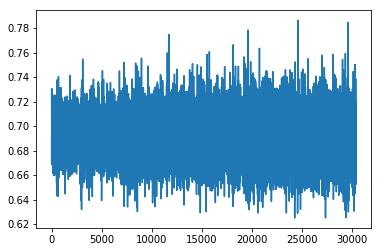

In [51]:
plt.plot(plot_d)

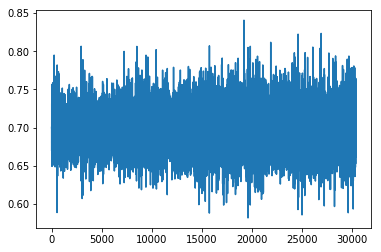

In [52]:
plt.plot(plot_g)